In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
#import foolbox
import tqdm
import imageio
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import os
from torch.utils.data import Dataset,DataLoader
import skimage.transform
import skimage
from skimage import io
import cv2
from torch.nn import functional as F
import copy

In [2]:
torch.cuda.set_device(3)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#calcyulating the mean and the standard deviation


In [4]:
model = torchvision.models.resnet152(pretrained=True, )

In [5]:
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet152
        self.resnet = model
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier1 = self.resnet.fc
       
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        out_x = self.features(x)
        
        # register the hook
        h = out_x.register_hook(self.activations_hook)
        
        # complete the forward pass
        x = self.avgpool(out_x)
        x = x.view((1, -1))
        x = self.classifier1(x)
       
        
        return x, out_x

In [7]:
mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406),std= (0.229, 0.224, 0.225))
    ]
)

In [8]:
class cam_dataset(Dataset):
    def __init__(self,img_transform1):
        #/workspace/data_fine_grain/cub200/raw/CUB_200_2011/(base) ironman@bigbox:~$ CUB_200_2011
        self.dir_path = './imagenet_fgsm/imagenet/fgsm/'
        self.files_list = []
        self.original_label = []
        self.misclassified_label = []
        self.img_transform1 = img_transform1
        
        
        for r, d, f in os.walk(self.dir_path):
            for file in f:
                if '.png' in file and "-checkpoint.png" not in file:
                    #print("here")
                    #print(file)
                    #print(file.split('.')[-2].split('_')[-2])
                    #print(file.split('.')[-2].split('_')[-1])
                    if(int(file.split('.')[-2].split('_')[-2])==int(file.split('.')[-2].split('_')[-1])):
                        #print(file)
                        self.files_list.append(os.path.join(r,file))
                        self.original_label.append(int(file.split('.')[-2].split('_')[-2]))
                        self.misclassified_label.append(int(file.split('.')[-2].split('_')[-1]))

        
            
    def __getitem__(self,index):
        #if(self.train):
           
            img1_path = self.files_list[index]
            img1_path = img1_path.rstrip()
            img1 = io.imread(img1_path)
            
            #print(img1.shape)
            if(img1.shape.__len__() == 2):
                img1 = np.repeat(img1[:, :, np.newaxis], 3, axis=2) 
            #print(img1_path)
            #plt.imshow(img1)
            img1 = img1.astype(np.float)
            img1 = cv2.resize(img1,(256,256),interpolation = cv2.INTER_AREA)
            img1 = img1/255.0
            img1 = self.img_transform1(img1)
            label = self.original_label[index]
            label = int(label)
            mislabel = self.misclassified_label[index]
            mislabel = int(mislabel)
            #print("check")
            #print(np.unique(img1))
            return {"img": img1, "label": label,"mislabel":mislabel,"path": img1_path}
   
        #return img1,img2,label
    def __len__(self):
        return len(self.original_label)


test_set = cam_dataset(transform)

testloader = DataLoader(test_set,batch_size =1,shuffle = True, num_workers =0)

In [9]:
data = test_set[0]

In [10]:
print(data['label'])

33


check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_22566_361_361.png
check t shape
(600, 800)


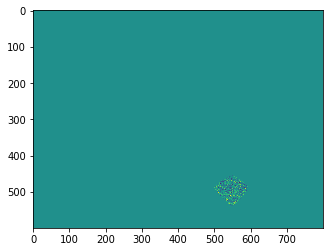

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_8396_27_27.png
check t shape
(385, 500)


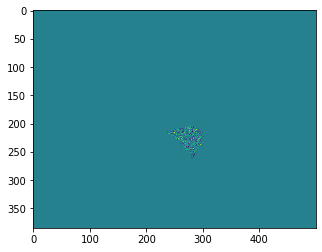

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_23853_982_982.png
check t shape
(375, 500)


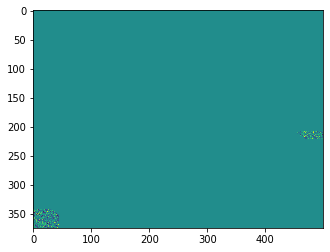

check the max index
760
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_1202_648_648.png
check t shape
(2039, 872)


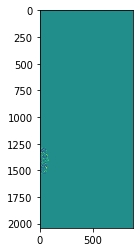

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_9540_235_235.png
check t shape
(424, 500)


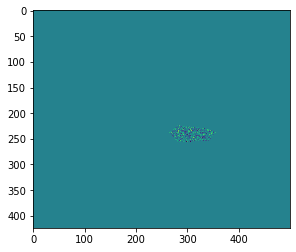

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_25631_310_310.png
check t shape
(375, 500)


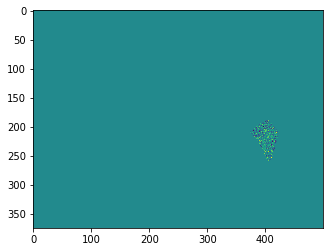

check the max index
792
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_16554_840_840.png
check t shape
(375, 500)


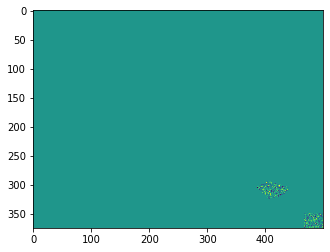

check the max index
212
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_19668_215_215.png
check t shape
(332, 500)


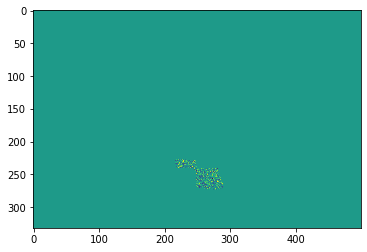

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_11093_31_31.png
check t shape
(375, 500)


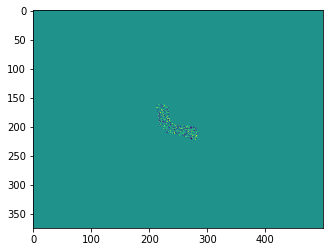

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_8659_31_31.png
check t shape
(333, 500)


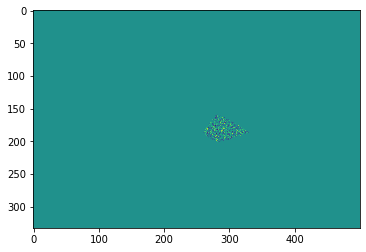

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_11166_361_361.png
check t shape
(456, 596)


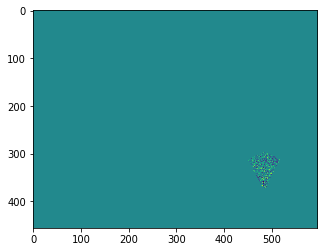

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_1593_886_886.png
check t shape
(800, 600)


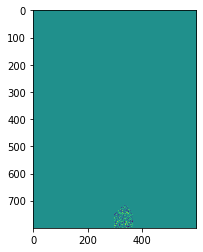

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_2877_33_33.png
check t shape
(375, 500)


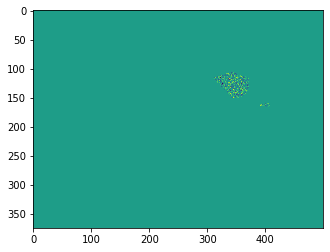

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_37971_469_469.png
check t shape
(334, 500)


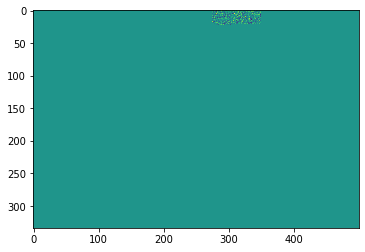

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_4662_581_581.png
check t shape
(393, 500)


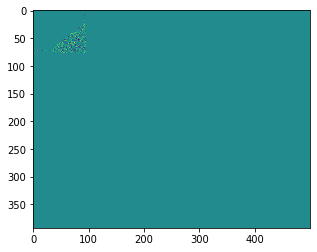

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_7931_218_218.png
check t shape
(263, 500)


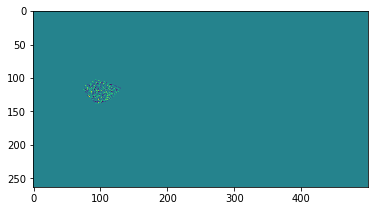

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_5359_873_873.png
check t shape
(500, 366)


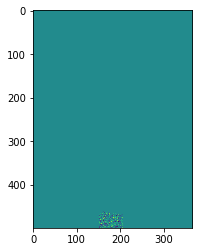

check the max index
337
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_1597_470_470.png
check t shape
(152, 250)


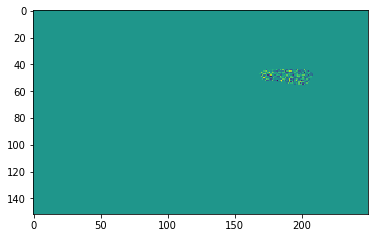

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_6634_670_670.png
check t shape
(333, 500)


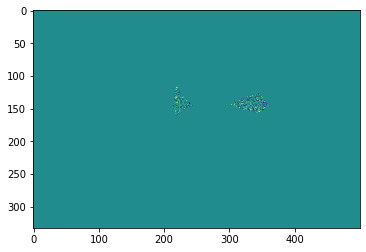

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_57191_429_429.png
check t shape
(260, 500)


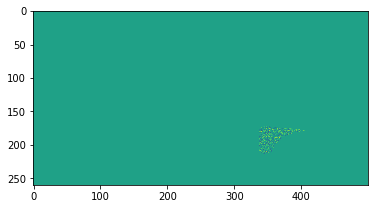

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_4281_235_235.png
check t shape
(500, 333)


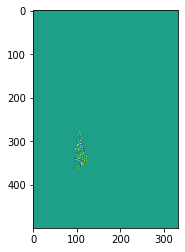

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_22772_92_92.png
check t shape
(500, 386)


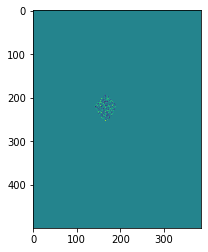

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_10285_363_363.png
check t shape
(300, 500)


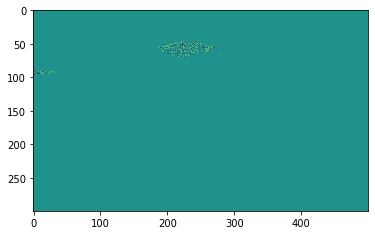

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_16565_713_713.png
check t shape
(400, 300)


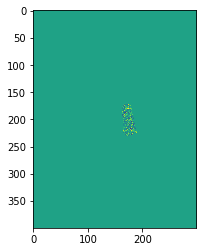

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_3837_935_935.png
check t shape
(375, 500)


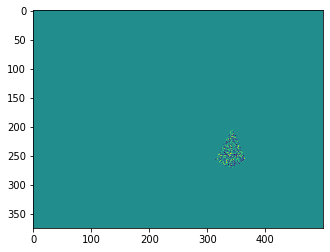

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_55672_673_673.png
check t shape
(374, 550)


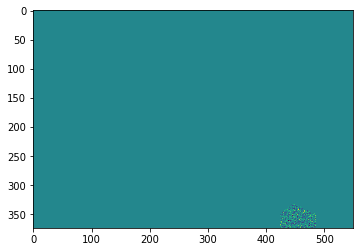

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_3924_696_696.png
check t shape
(370, 500)


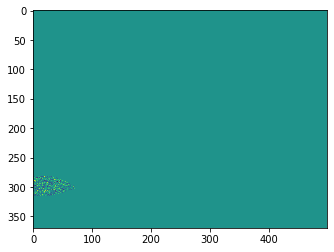

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_2211_469_469.png
check t shape
(528, 800)


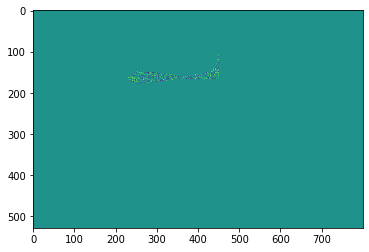

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_29554_648_648.png
check t shape
(500, 333)


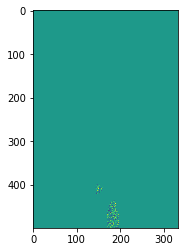

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_8277_568_568.png
check t shape
(466, 500)


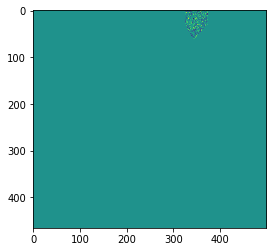

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_1227_648_648.png
check t shape
(334, 500)


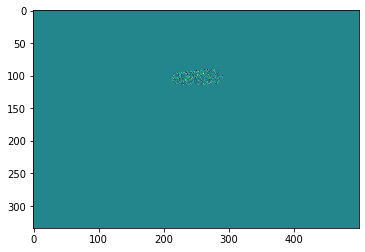

check the max index
526
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_4700_673_673.png
check t shape
(375, 500)


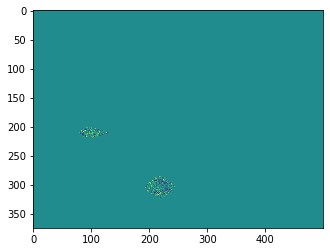

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_29150_310_310.png
check t shape
(377, 500)


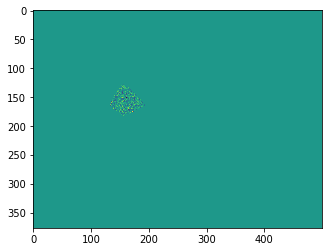

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_6377_429_429.png
check t shape
(354, 500)


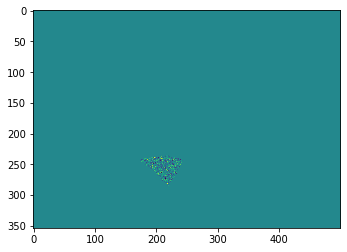

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_1127_696_696.png
check t shape
(375, 500)


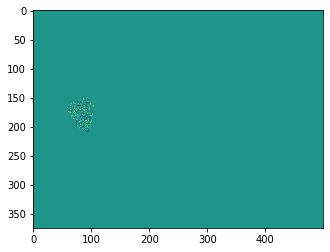

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_3209_885_885.png
check t shape
(130, 98)


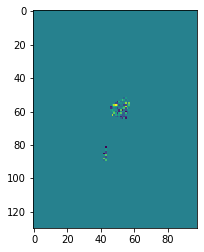

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_5760_873_873.png
check t shape
(500, 500)


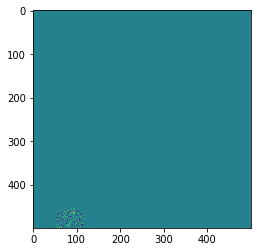

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_7415_696_696.png
check t shape
(375, 500)


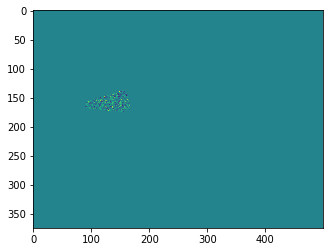

check the max index
70
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_27946_310_310.png
check t shape
(375, 500)


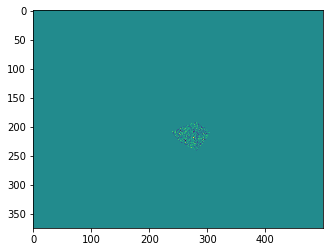

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_4112_21_21.png
check t shape
(339, 500)


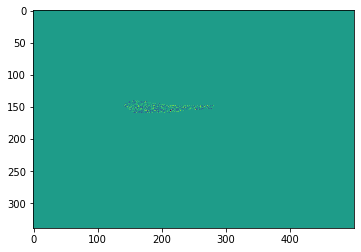

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_3573_605_605.png
check t shape
(500, 333)


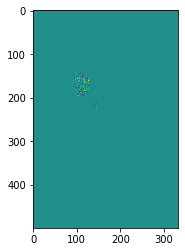

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_5734_982_982.png
check t shape
(333, 500)


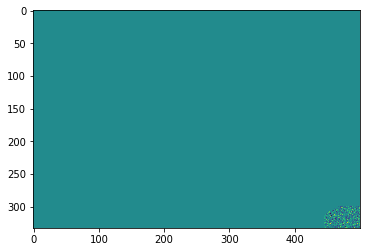

check the max index
585
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_6686_470_470.png
check t shape
(318, 744)


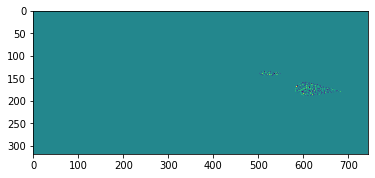

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_37013_840_840.png
check t shape
(500, 375)


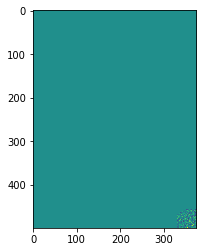

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_13610_896_896.png
check t shape
(375, 500)


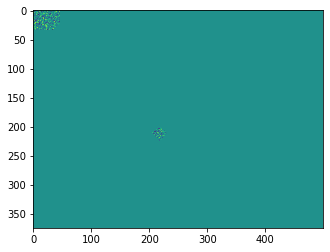

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_2001_713_713.png
check t shape
(444, 674)


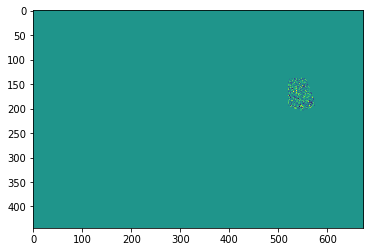

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_17462_988_988.png
check t shape
(375, 500)


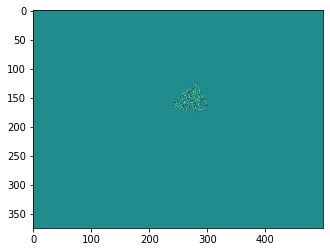

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_16525_469_469.png
check t shape
(500, 374)


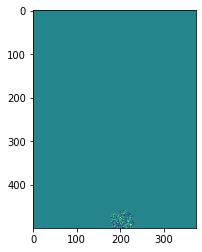

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_3343_363_363.png
check t shape
(179, 293)


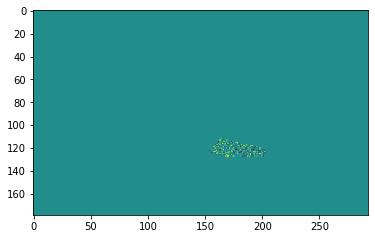

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_24344_513_513.png
check t shape
(411, 500)


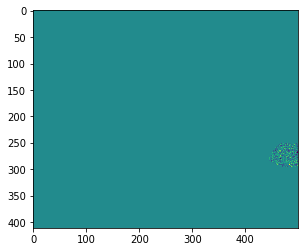

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_22323_92_92.png
check t shape
(345, 500)


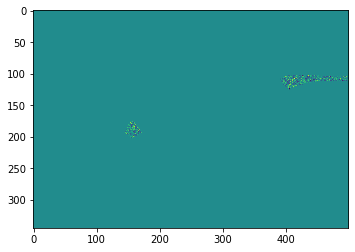

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_34549_673_673.png
check t shape
(300, 300)


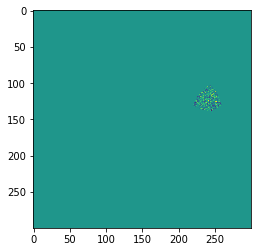

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_1376_975_975.png
check t shape
(256, 341)


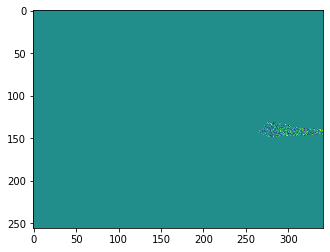

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_10700_21_21.png
check t shape
(413, 500)


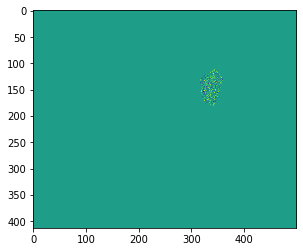

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_12378_352_352.png
check t shape
(333, 500)


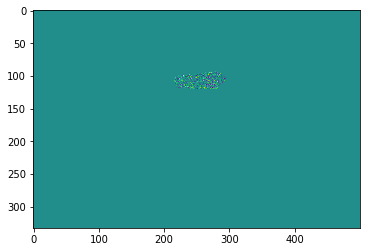

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_17317_432_432.png
check t shape
(468, 312)


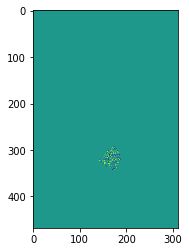

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_10181_670_670.png
check t shape
(500, 375)


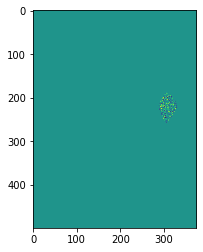

check the max index
904
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_1219_31_31.png
check t shape
(375, 500)


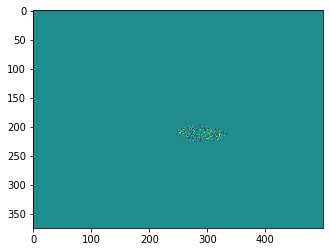

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_7709_696_696.png
check t shape
(333, 500)


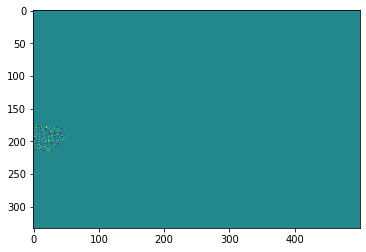

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_9154_873_873.png
check t shape
(375, 500)


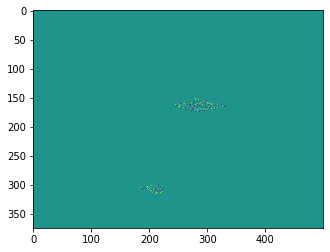

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_5416_935_935.png
check t shape
(375, 500)


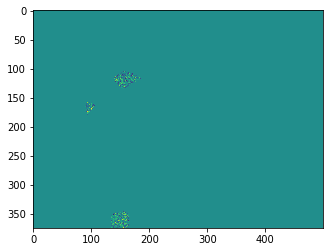

check the max index
527
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_15770_664_664.png
check t shape
(333, 500)


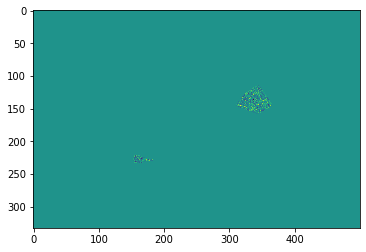

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_13929_361_361.png
check t shape
(328, 500)


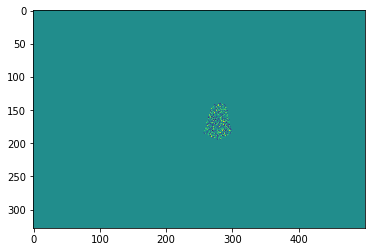

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_11450_470_470.png
check t shape
(407, 500)


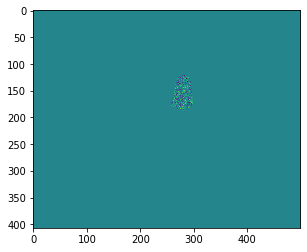

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_7760_550_550.png
check t shape
(375, 500)


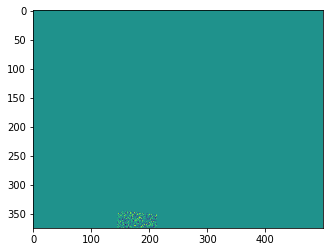

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_57267_979_979.png
check t shape
(500, 332)


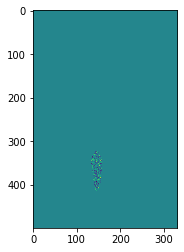

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_7574_885_885.png
check t shape
(690, 800)


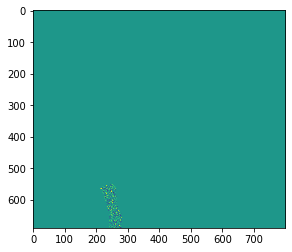

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_12018_316_316.png
check t shape
(360, 480)


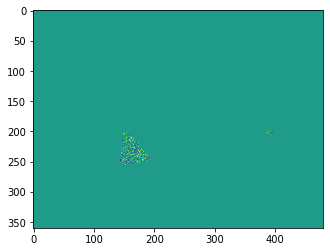

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_10535_664_664.png
check t shape
(338, 450)


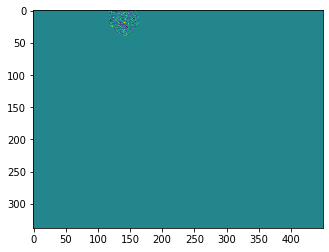

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_25210_896_896.png
check t shape
(420, 600)


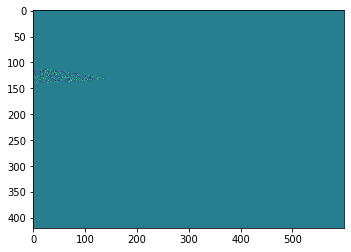

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_1282_988_988.png
check t shape
(500, 483)


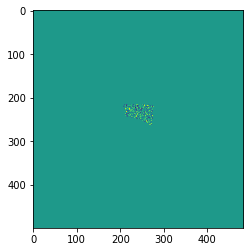

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_23776_896_896.png
check t shape
(390, 434)


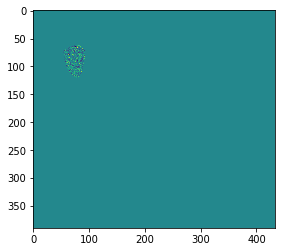

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_717_31_31.png
check t shape
(400, 500)


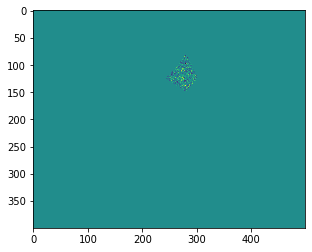

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_4918_979_979.png
check t shape
(1200, 1600)


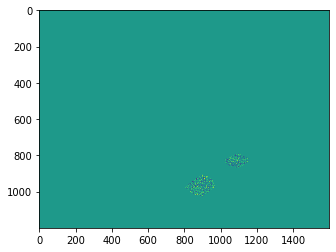

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_4279_886_886.png
check t shape
(500, 496)


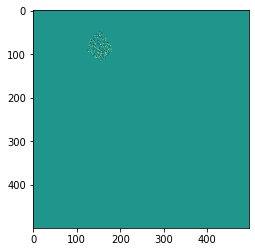

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_1640_21_21.png
check t shape
(330, 500)


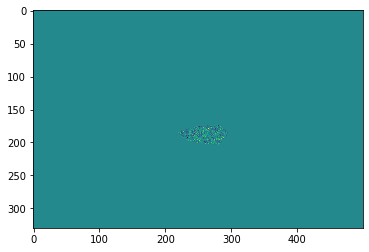

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_5722_215_215.png
check t shape
(336, 500)


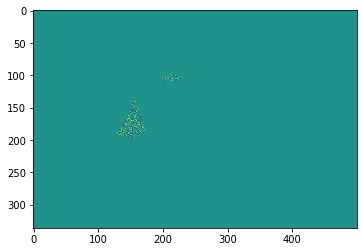

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_7809_566_566.png
check t shape
(183, 185)


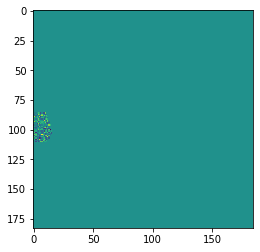

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_7070_316_316.png
check t shape
(500, 369)


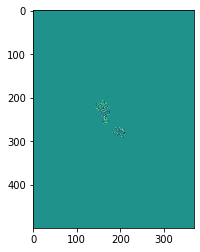

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_11025_886_886.png
check t shape
(375, 500)


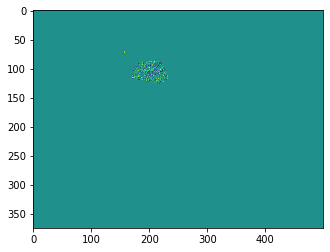

check the max index
824
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_19949_568_568.png
check t shape
(400, 300)


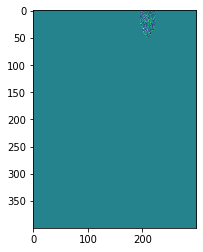

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_5400_404_404.png
check t shape
(120, 130)


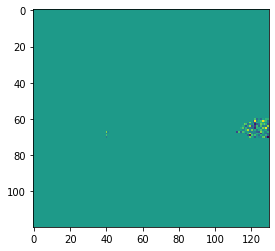

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_1402_361_361.png
check t shape
(500, 328)


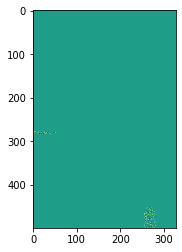

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_32441_469_469.png
check t shape
(353, 331)


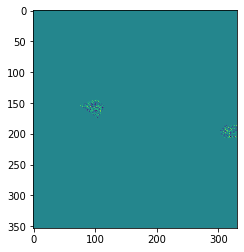

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_5552_979_979.png
check t shape
(282, 347)


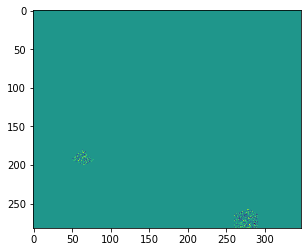

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_28907_429_429.png
check t shape
(375, 500)


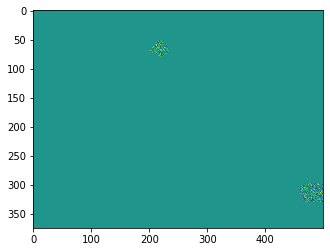

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_6860_218_218.png
check t shape
(500, 333)


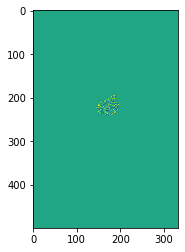

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_4892_696_696.png
check t shape
(500, 375)


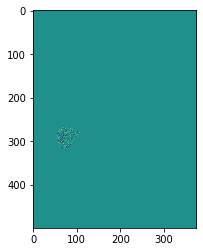

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_9_404_404.png
check t shape
(334, 500)


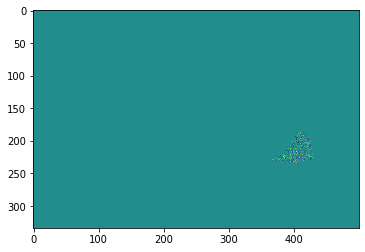

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_14521_232_232.png
check t shape
(500, 350)


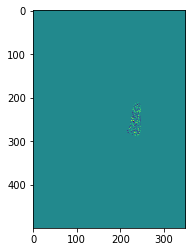

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_12333_979_979.png
check t shape
(300, 400)


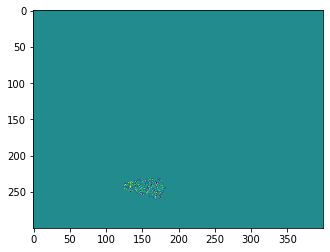

check the max index
638
638
./imagenet_fgsm/imagenet/fgsm/fgsm_n03710637_2533_638_638.png
check t shape
(500, 325)


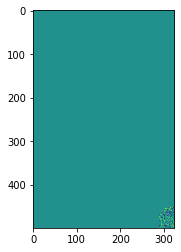

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_1589_218_218.png
check t shape
(120, 120)


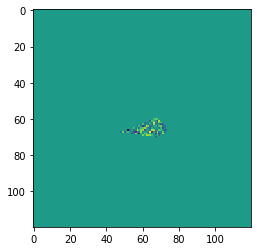

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_63211_513_513.png
check t shape
(334, 500)


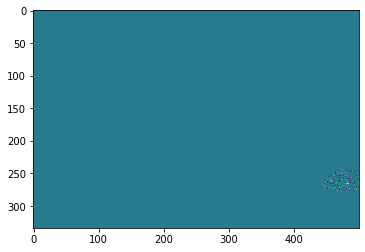

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_30159_33_33.png
check t shape
(600, 800)


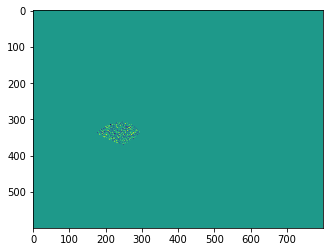

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_4185_804_804.png
check t shape
(240, 178)


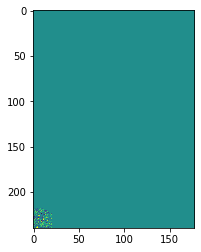

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_4716_696_696.png
check t shape
(375, 500)


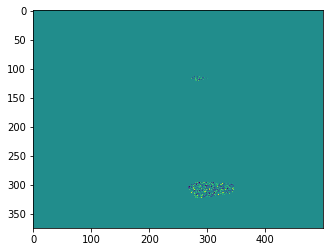

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_12416_670_670.png
check t shape
(453, 500)


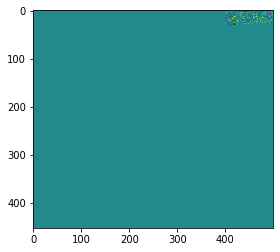

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_15969_432_432.png
check t shape
(275, 500)


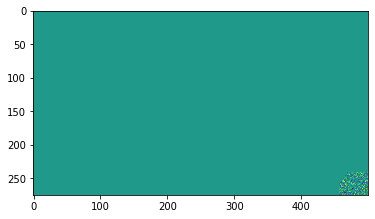

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_9987_873_873.png
check t shape
(375, 500)


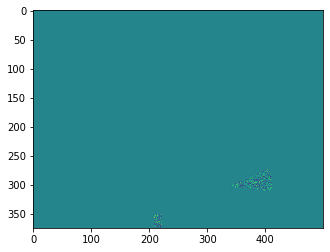

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_56001_913_913.png
check t shape
(339, 443)


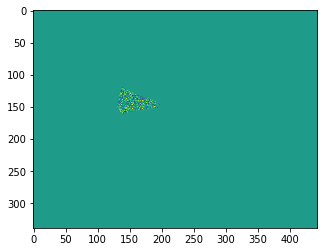

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_9771_215_215.png
check t shape
(768, 1024)


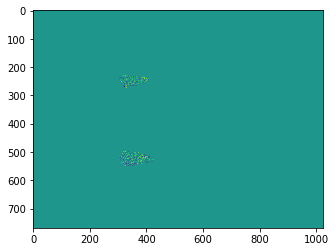

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_785_316_316.png
check t shape
(435, 500)


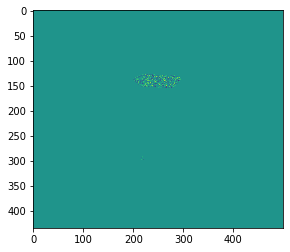

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_5263_988_988.png
check t shape
(434, 500)


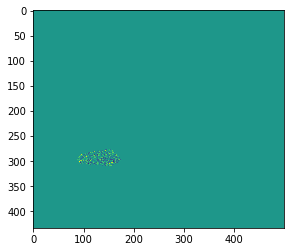

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_10_316_316.png
check t shape
(375, 500)


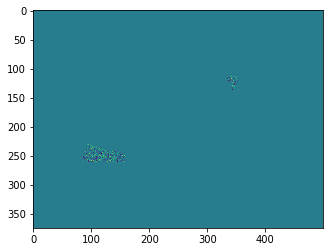

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_7812_31_31.png
check t shape
(1998, 3024)


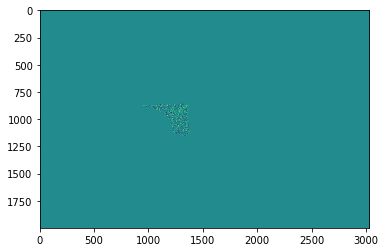

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_34010_975_975.png
check t shape
(301, 500)


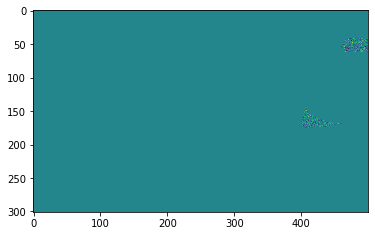

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_13632_21_21.png
check t shape
(333, 500)


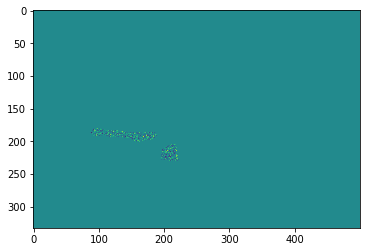

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_9313_428_428.png
check t shape
(375, 500)


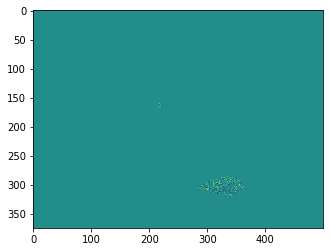

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_11269_92_92.png
check t shape
(386, 500)


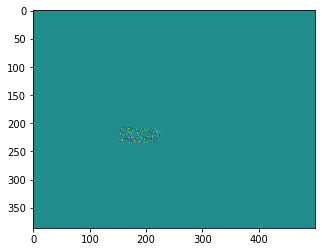

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_12063_27_27.png
check t shape
(333, 500)


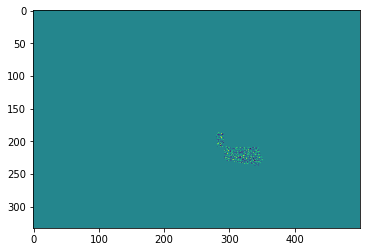

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_7977_885_885.png
check t shape
(150, 150)


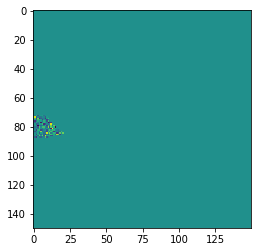

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_2150_235_235.png
check t shape
(375, 500)


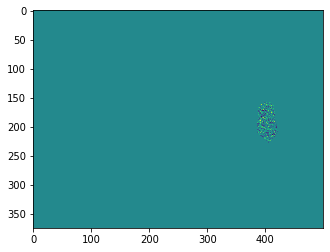

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_19011_432_432.png
check t shape
(500, 375)


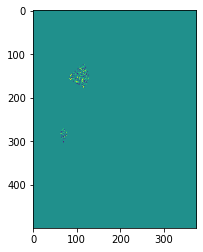

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_11312_886_886.png
check t shape
(500, 332)


/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater_equal
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less


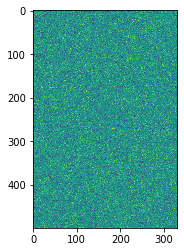

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_8024_27_27.png
check t shape
(334, 500)


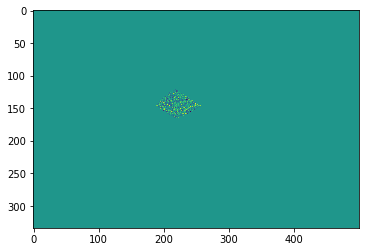

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_56426_566_566.png
check t shape
(674, 468)


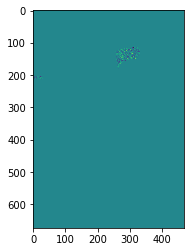

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_8292_361_361.png
check t shape
(333, 500)


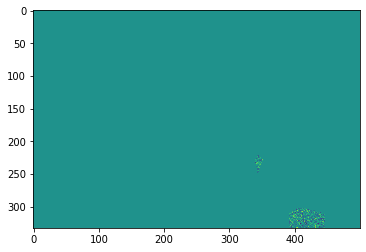

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_3313_352_352.png
check t shape
(333, 500)


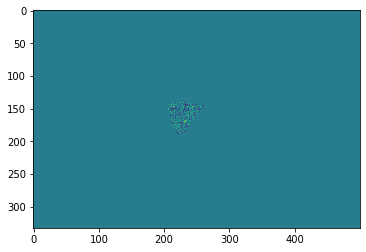

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_22709_232_232.png
check t shape
(333, 500)


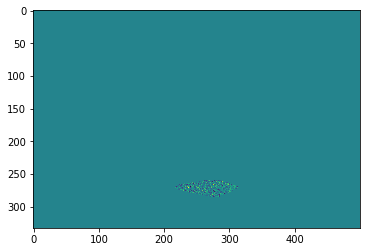

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_13148_21_21.png
check t shape
(576, 406)


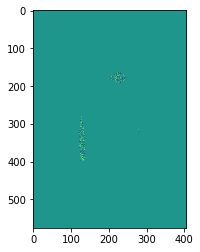

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_8502_232_232.png
check t shape
(500, 331)


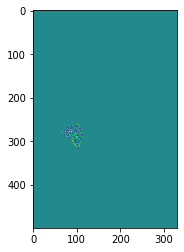

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_13_886_886.png
check t shape
(500, 375)


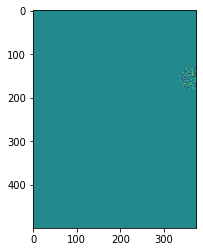

check the max index
958
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_22268_979_979.png
check t shape
(375, 500)


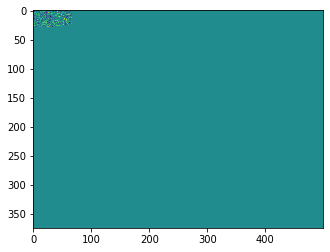

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_10461_664_664.png
check t shape
(358, 499)


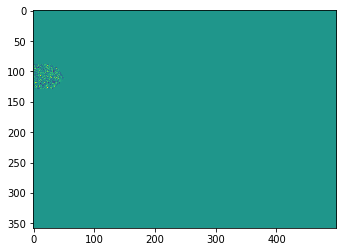

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_12861_235_235.png
check t shape
(435, 640)


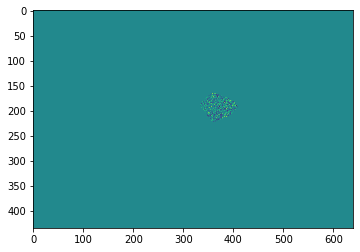

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_9879_361_361.png
check t shape
(345, 500)


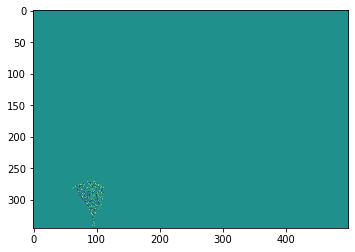

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_12695_469_469.png
check t shape
(318, 417)


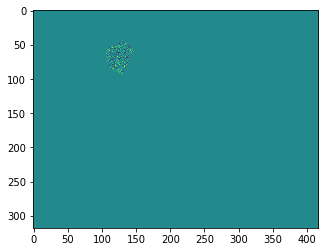

check the max index
638
638
./imagenet_fgsm/imagenet/fgsm/fgsm_n03710637_9473_638_638.png
check t shape
(500, 500)


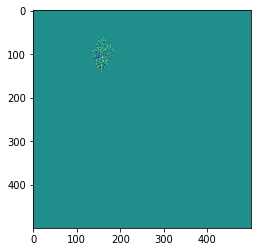

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_2773_215_215.png
check t shape
(375, 500)


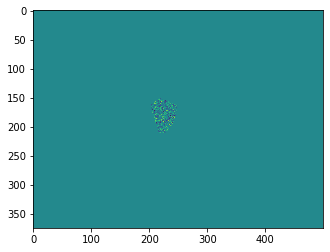

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_44149_429_429.png
check t shape
(333, 500)


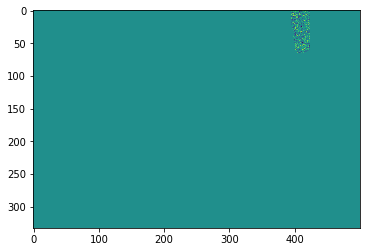

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_3032_218_218.png
check t shape
(333, 500)


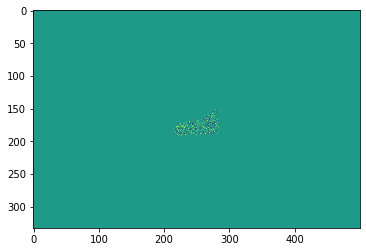

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_4617_31_31.png
check t shape
(333, 500)


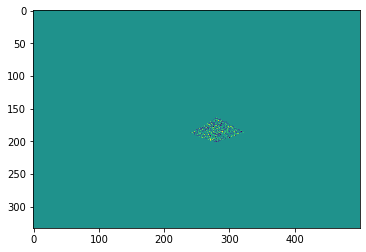

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_12668_896_896.png
check t shape
(375, 500)


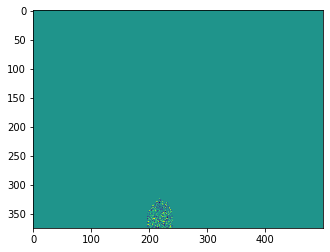

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_76086_998_998.png
check t shape
(500, 375)


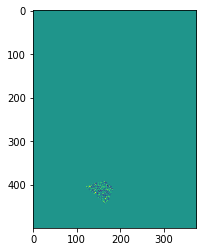

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_858_92_92.png
check t shape
(500, 500)


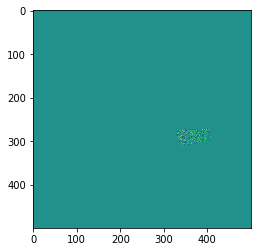

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_4527_27_27.png
check t shape
(375, 500)


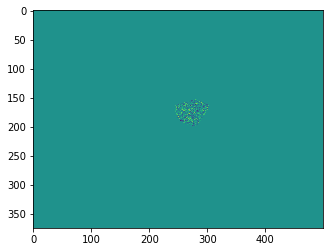

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_871_886_886.png
check t shape
(375, 500)


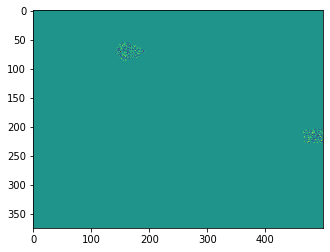

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_3907_428_428.png
check t shape
(375, 500)


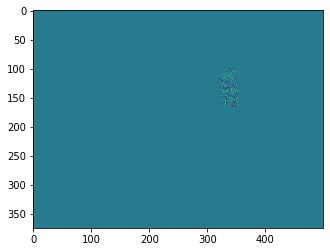

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_17210_896_896.png
check t shape
(138, 138)


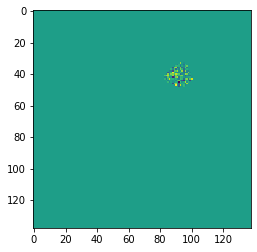

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_4269_804_804.png
check t shape
(500, 334)


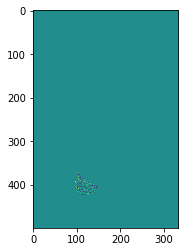

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_598_605_605.png
check t shape
(333, 500)


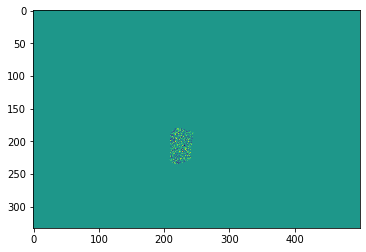

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_73502_673_673.png
check t shape
(333, 500)


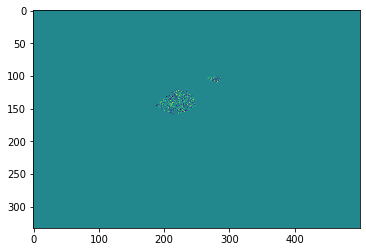

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_12763_696_696.png
check t shape
(361, 500)


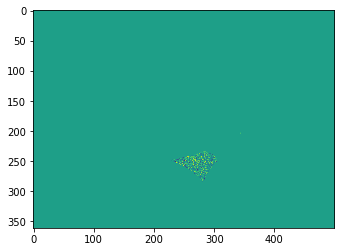

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_1849_428_428.png
check t shape
(382, 500)


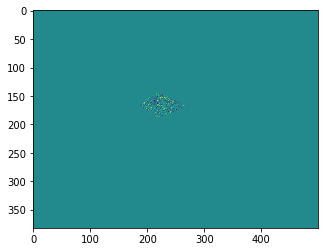

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_1543_630_630.png
check t shape
(298, 250)


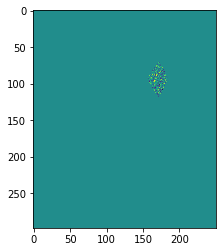

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_243_469_469.png
check t shape
(302, 346)


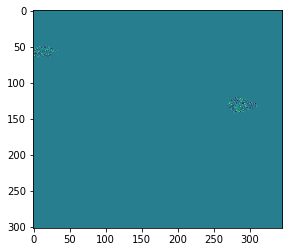

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_4847_232_232.png
check t shape
(160, 200)


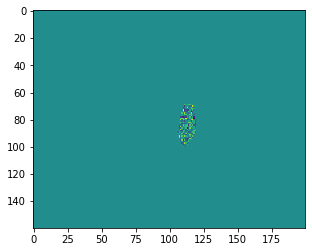

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_63390_566_566.png
check t shape
(480, 640)


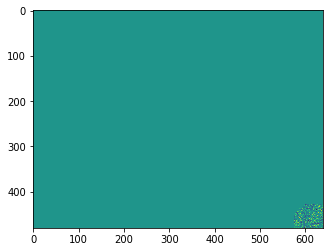

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_3417_470_470.png
check t shape
(731, 650)


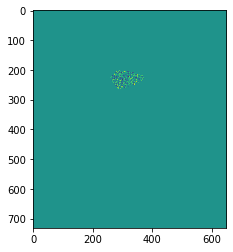

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_453_605_605.png
check t shape
(375, 500)


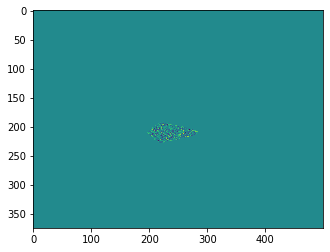

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_1716_428_428.png
check t shape
(375, 500)


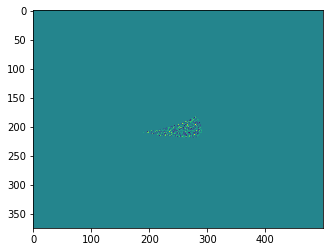

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_4466_363_363.png
check t shape
(360, 480)


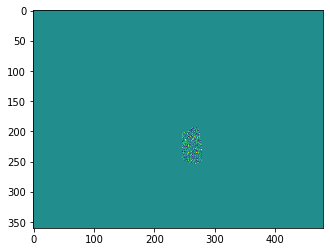

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_2607_404_404.png
check t shape
(334, 500)


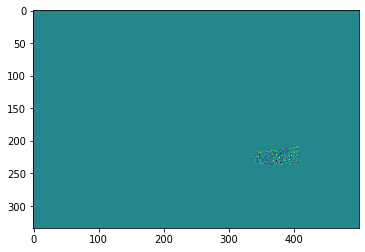

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_30134_673_673.png
check t shape
(371, 470)


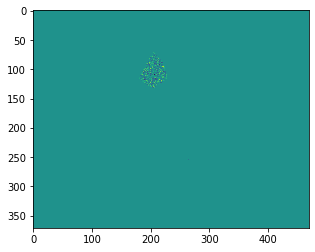

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_17011_404_404.png
check t shape
(333, 500)


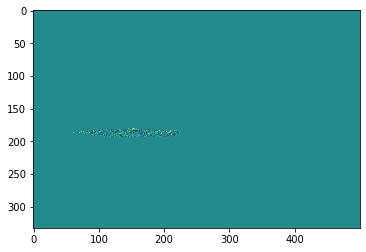

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_13998_513_513.png
check t shape
(422, 321)


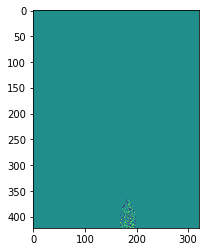

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_8718_469_469.png
check t shape
(333, 500)


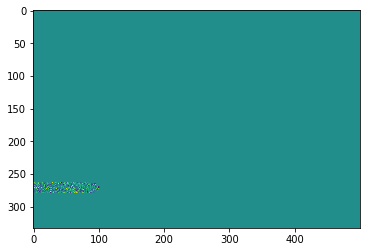

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_273_92_92.png
check t shape
(500, 361)


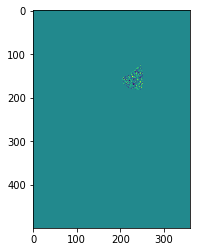

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_19812_840_840.png
check t shape
(500, 332)


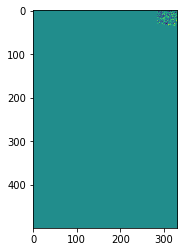

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_12798_21_21.png
check t shape
(500, 419)


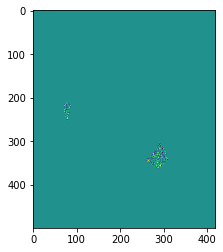

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_868_92_92.png
check t shape
(381, 500)


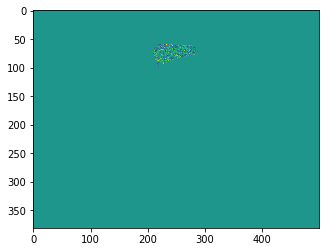

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_6096_361_361.png
check t shape
(160, 240)


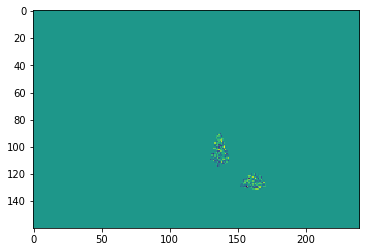

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_71891_979_979.png
check t shape
(375, 560)


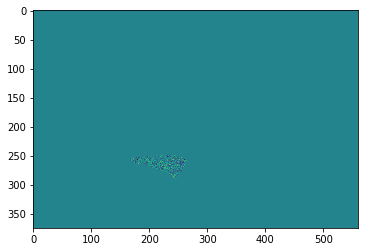

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_41186_840_840.png
check t shape
(351, 500)


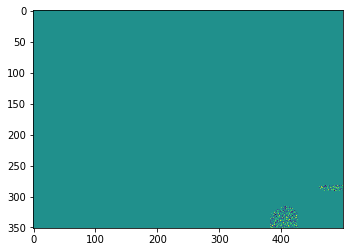

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_2594_232_232.png
check t shape
(592, 768)


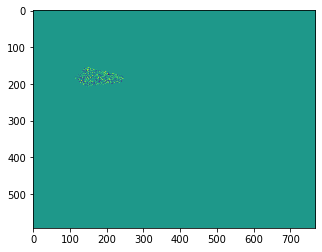

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_9892_316_316.png
check t shape
(375, 500)


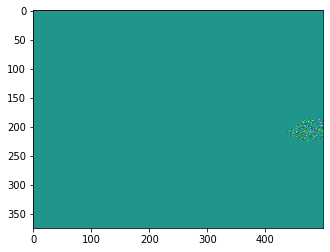

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_5297_27_27.png
check t shape
(349, 500)


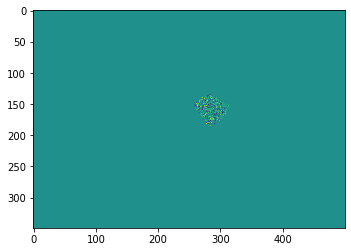

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_4835_363_363.png
check t shape
(490, 580)


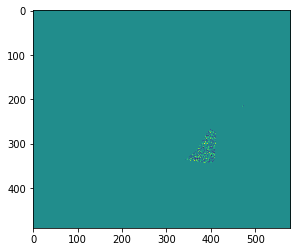

check the max index
794
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_5558_885_885.png
check t shape
(250, 200)


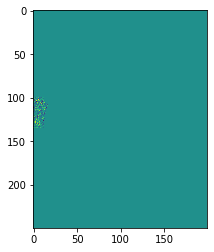

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_16643_432_432.png
check t shape
(333, 500)


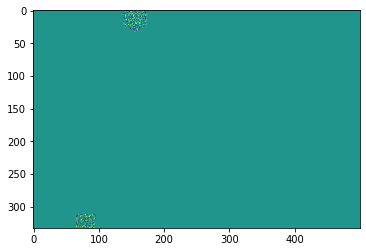

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_11566_885_885.png
check t shape
(200, 200)


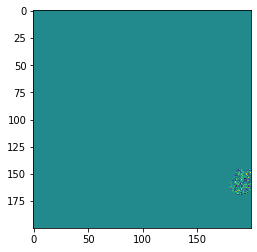

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_5320_630_630.png
check t shape
(375, 500)


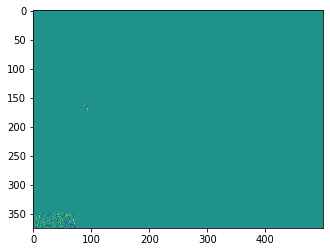

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_3867_873_873.png
check t shape
(500, 375)


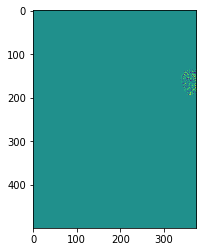

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_73408_913_913.png
check t shape
(333, 500)


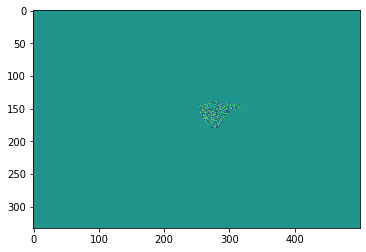

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_7997_988_988.png
check t shape
(375, 500)


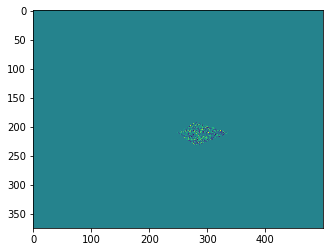

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_5378_470_470.png
check t shape
(262, 200)


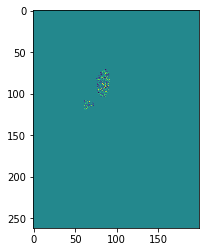

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_14515_713_713.png
check t shape
(450, 600)


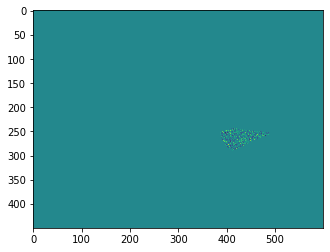

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_4237_428_428.png
check t shape
(375, 500)


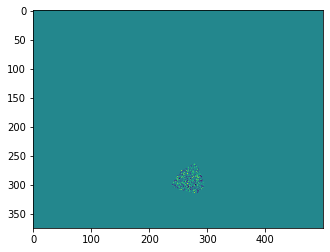

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_8725_873_873.png
check t shape
(450, 600)


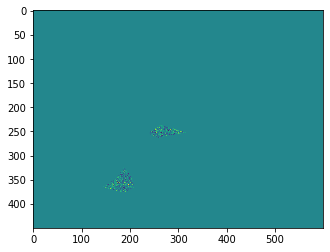

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_1758_673_673.png
check t shape
(349, 500)


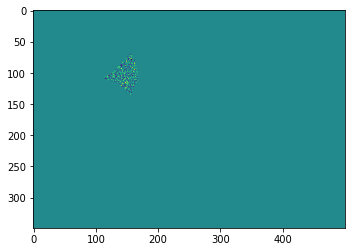

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_9593_232_232.png
check t shape
(853, 1280)


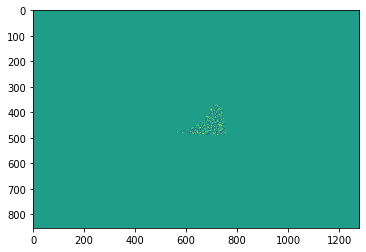

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_3673_470_470.png
check t shape
(424, 265)


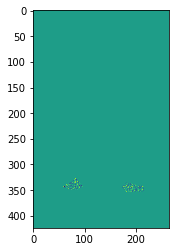

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_20813_232_232.png
check t shape
(332, 500)


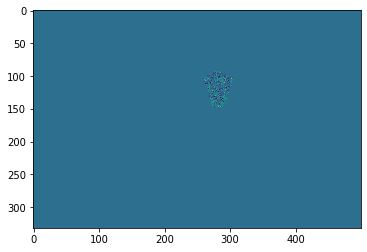

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_33293_975_975.png
check t shape
(400, 240)


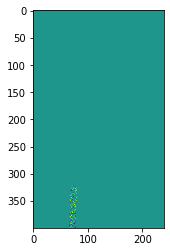

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_1578_804_804.png
check t shape
(360, 360)


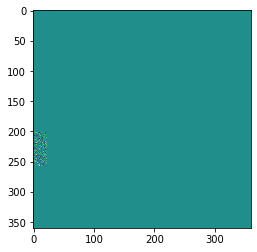

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_8251_568_568.png
check t shape
(500, 333)


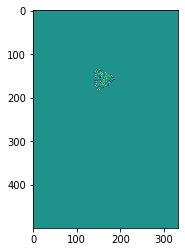

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_6637_470_470.png
check t shape
(402, 600)


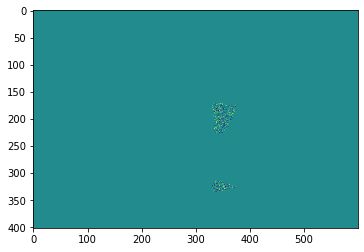

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_6559_363_363.png
check t shape
(300, 400)


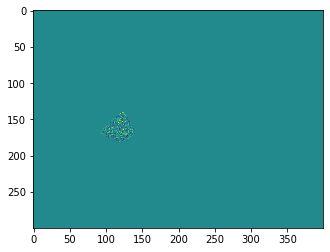

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_4646_31_31.png
check t shape
(500, 344)


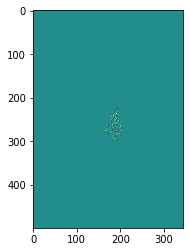

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_2459_352_352.png
check t shape
(492, 600)


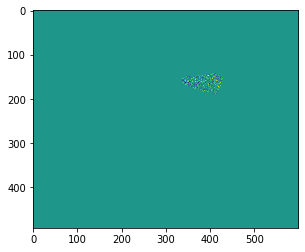

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_5492_935_935.png
check t shape
(380, 500)


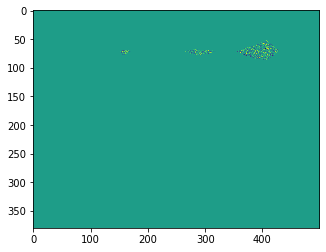

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_4188_448_448.png
check t shape
(500, 375)


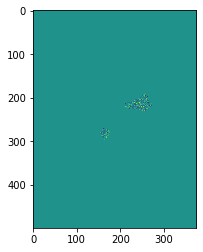

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_23702_235_235.png
check t shape
(104, 120)


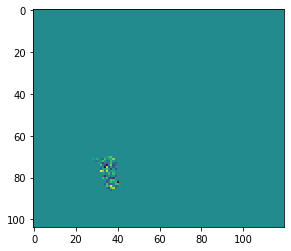

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_16420_664_664.png
check t shape
(375, 500)


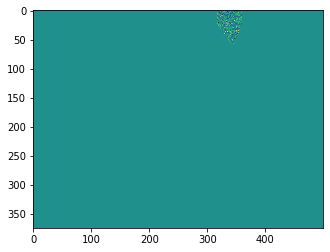

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_22627_896_896.png
check t shape
(333, 500)


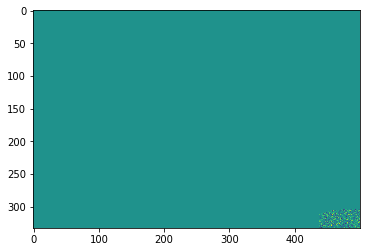

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_2974_316_316.png
check t shape
(375, 500)


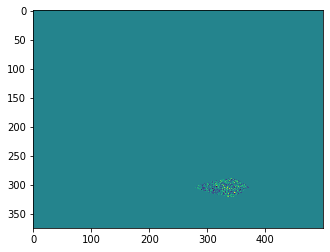

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_4774_361_361.png
check t shape
(310, 413)


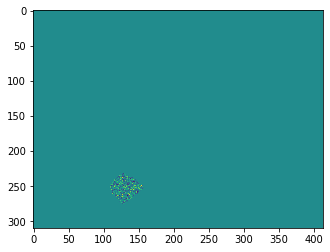

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_21490_33_33.png
check t shape
(331, 500)


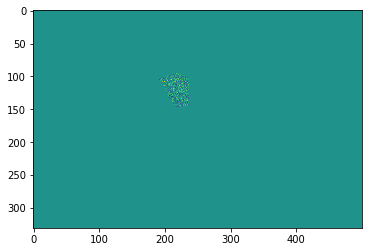

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_1145_215_215.png
check t shape
(333, 500)


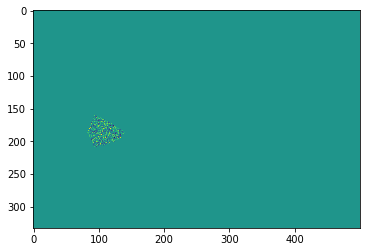

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_7567_979_979.png
check t shape
(225, 300)


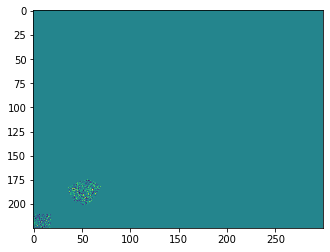

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_13335_404_404.png
check t shape
(332, 500)


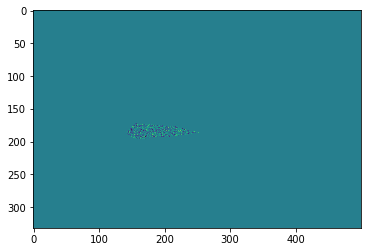

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_1253_840_840.png
check t shape
(500, 375)


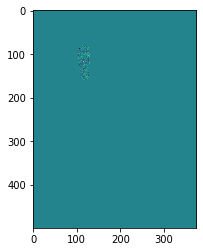

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_36329_988_988.png
check t shape
(460, 696)


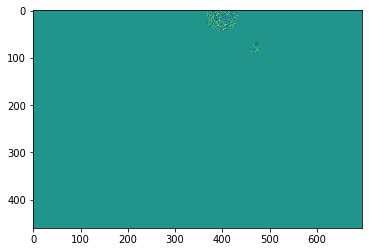

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_11754_566_566.png
check t shape
(640, 480)


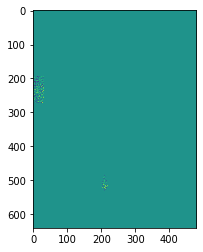

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_499_27_27.png
check t shape
(324, 500)


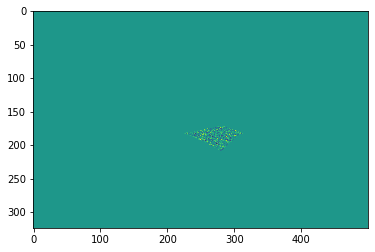

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_36564_513_513.png
check t shape
(576, 768)


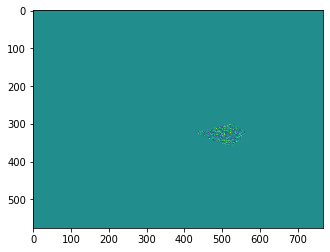

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_4885_605_605.png
check t shape
(500, 334)


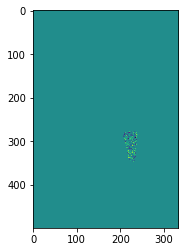

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_1524_218_218.png
check t shape
(131, 100)


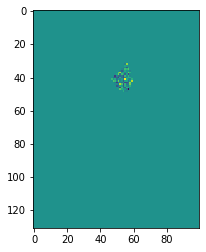

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_15472_404_404.png
check t shape
(375, 500)


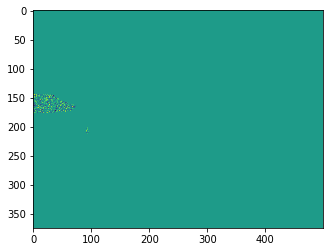

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_15636_21_21.png
check t shape
(367, 500)


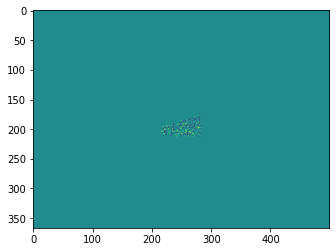

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_13114_648_648.png
check t shape
(500, 375)


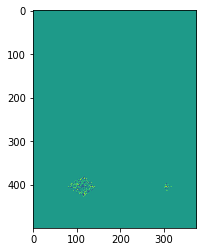

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_14132_648_648.png
check t shape
(375, 500)


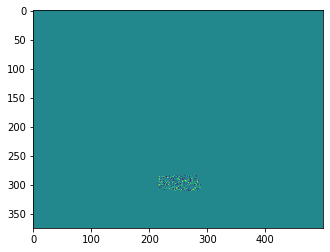

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_506_873_873.png
check t shape
(375, 500)


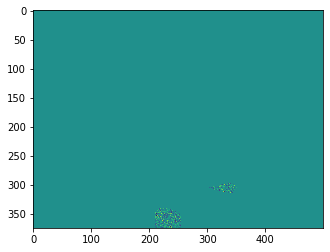

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_1824_429_429.png
check t shape
(375, 500)


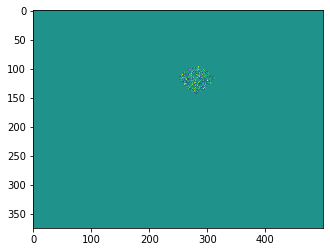

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_9399_432_432.png
check t shape
(250, 250)


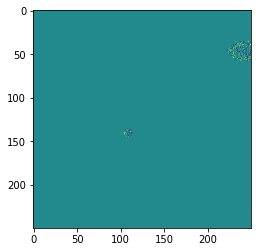

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_9254_975_975.png
check t shape
(960, 1280)


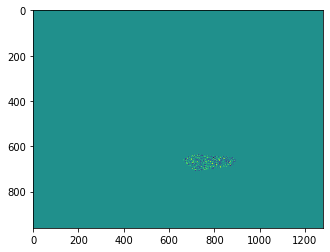

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_2642_550_550.png
check t shape
(160, 160)


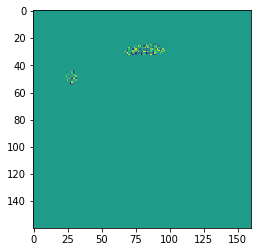

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_66893_979_979.png
check t shape
(383, 800)


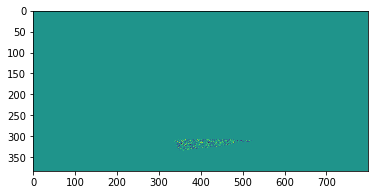

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_815_713_713.png
check t shape
(304, 405)


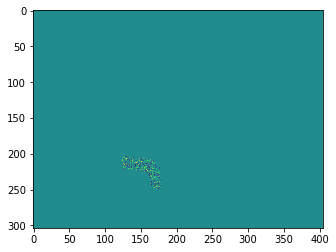

check the max index
428
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_14468_469_469.png
check t shape
(333, 500)


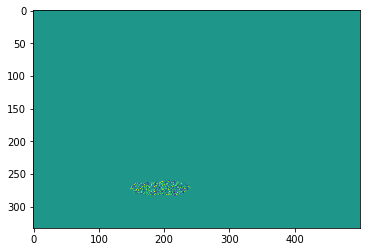

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_4185_988_988.png
check t shape
(375, 500)


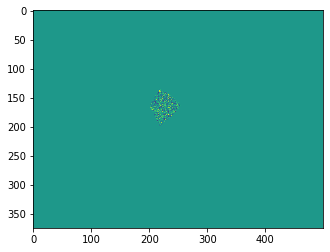

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_37356_979_979.png
check t shape
(375, 500)


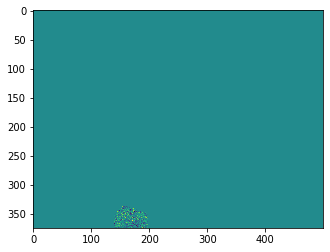

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_1162_550_550.png
check t shape
(400, 394)


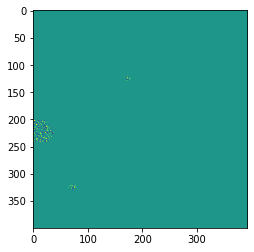

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_37249_513_513.png
check t shape
(391, 700)


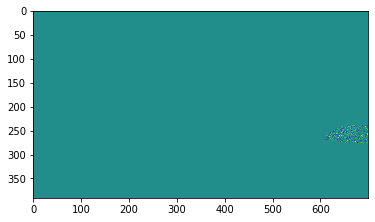

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_16149_235_235.png
check t shape
(375, 500)


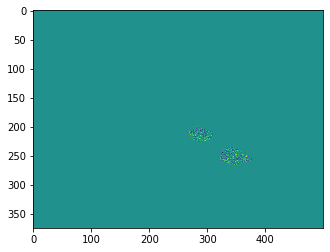

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_4824_804_804.png
check t shape
(332, 500)


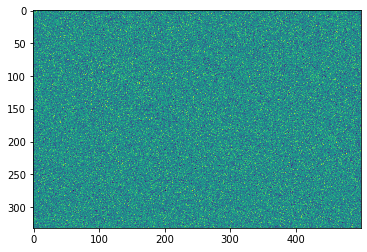

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_6888_218_218.png
check t shape
(334, 500)


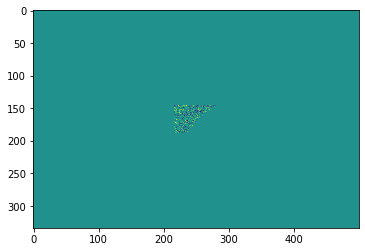

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_12896_404_404.png
check t shape
(375, 500)


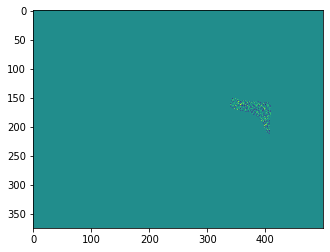

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_36812_235_235.png
check t shape
(333, 500)


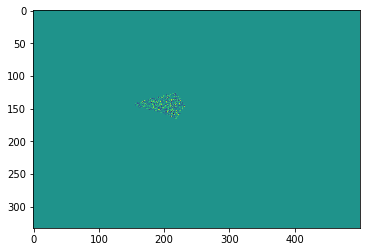

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_1291_404_404.png
check t shape
(310, 500)


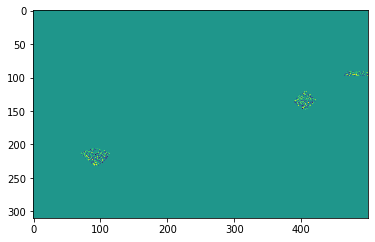

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_3371_218_218.png
check t shape
(375, 500)


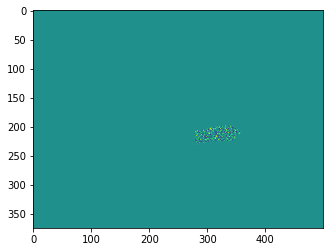

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_2656_998_998.png
check t shape
(500, 375)


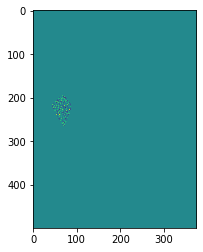

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_1097_21_21.png
check t shape
(333, 500)


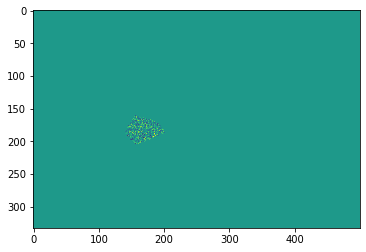

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_14049_568_568.png
check t shape
(375, 500)


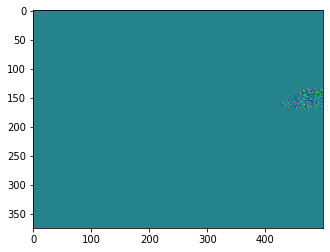

check the max index
638
638
./imagenet_fgsm/imagenet/fgsm/fgsm_n03710637_8075_638_638.png
check t shape
(400, 265)


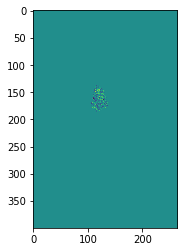

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_7279_404_404.png
check t shape
(375, 500)


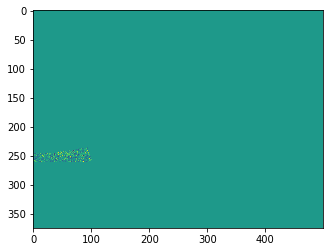

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_15086_235_235.png
check t shape
(80, 80)


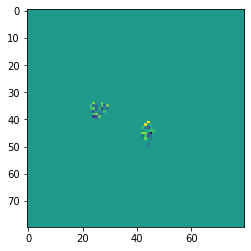

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_21542_448_448.png
check t shape
(500, 375)


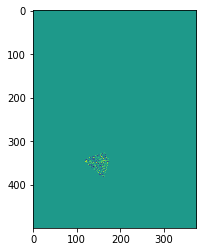

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_880_605_605.png
check t shape
(373, 280)


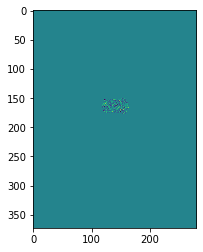

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_7218_21_21.png
check t shape
(371, 500)


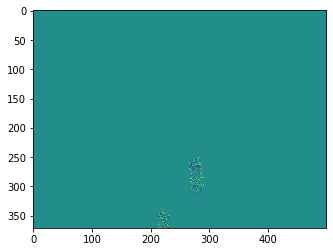

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_19963_404_404.png
check t shape
(254, 500)


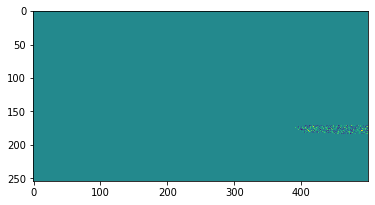

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_12794_428_428.png
check t shape
(332, 500)


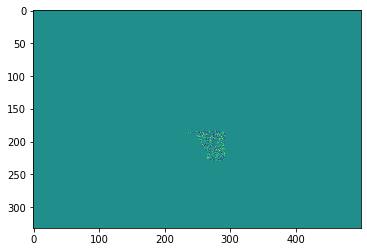

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_5249_428_428.png
check t shape
(500, 375)


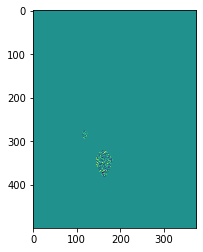

check the max index
607
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_2585_470_470.png
check t shape
(201, 298)


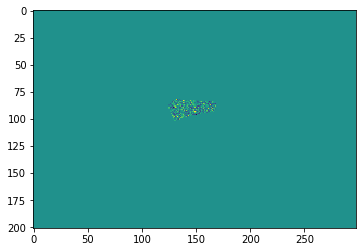

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_6991_713_713.png
check t shape
(300, 400)


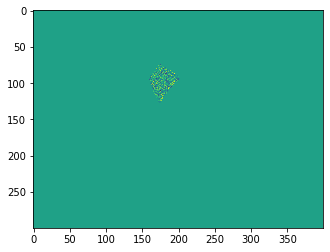

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_1637_232_232.png
check t shape
(375, 500)


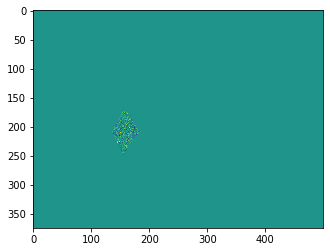

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_1906_566_566.png
check t shape
(520, 466)


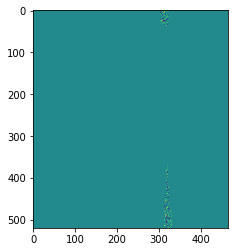

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_16968_235_235.png
check t shape
(500, 333)


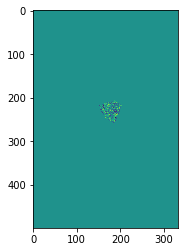

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_8917_316_316.png
check t shape
(375, 500)


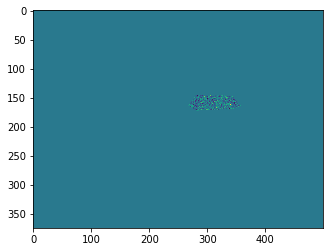

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_647_873_873.png
check t shape
(393, 500)


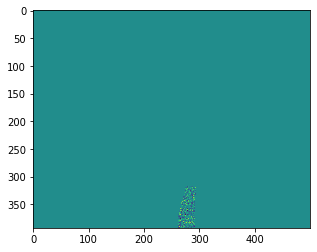

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_20546_235_235.png
check t shape
(290, 402)


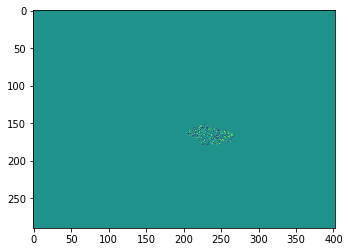

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_21960_581_581.png
check t shape
(333, 500)


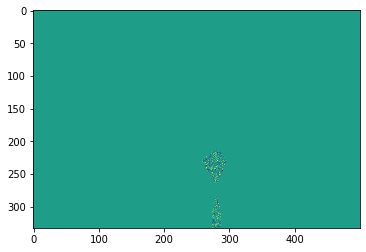

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_4166_218_218.png
check t shape
(400, 535)


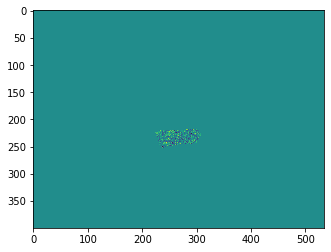

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_14668_975_975.png
check t shape
(375, 500)


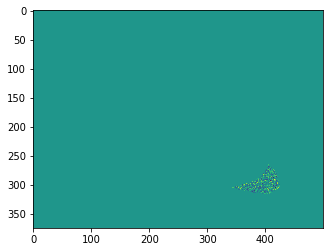

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_812_975_975.png
check t shape
(239, 360)


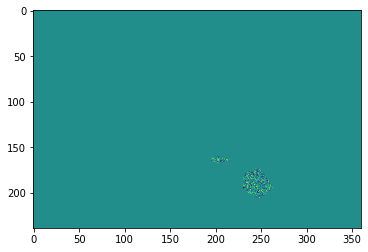

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_4276_215_215.png
check t shape
(654, 800)


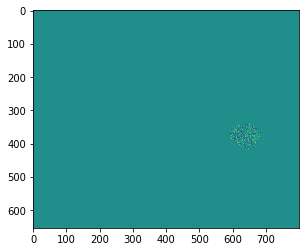

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_9845_232_232.png
check t shape
(484, 587)


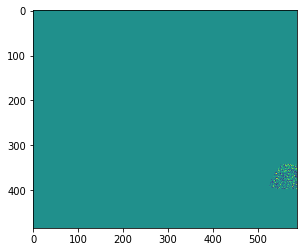

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_14308_913_913.png
check t shape
(375, 500)


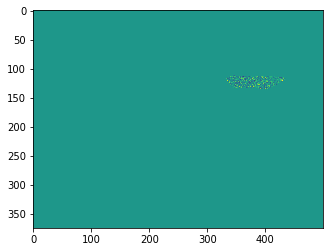

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_22835_568_568.png
check t shape
(333, 500)


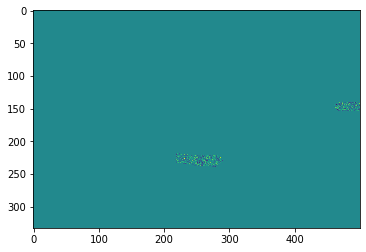

check the max index
648
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_31930_896_896.png
check t shape
(500, 375)


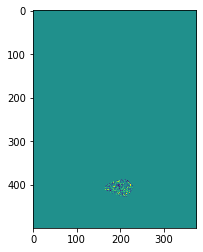

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_7411_713_713.png
check t shape
(500, 374)


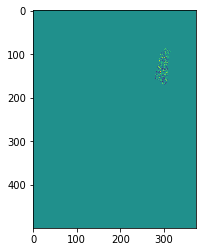

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_11317_550_550.png
check t shape
(160, 160)


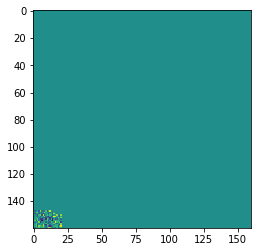

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_4711_31_31.png
check t shape
(334, 500)


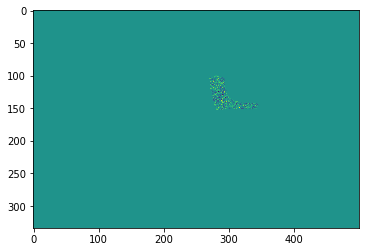

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_7121_648_648.png
check t shape
(350, 263)


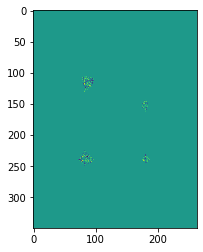

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_4920_664_664.png
check t shape
(1181, 1574)


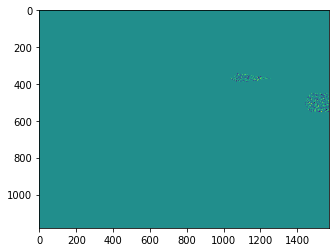

check the max index
769
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_4377_316_316.png
check t shape
(375, 500)


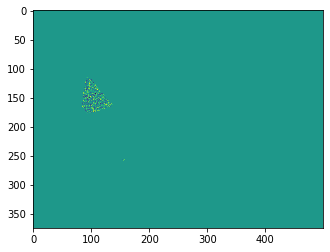

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_7444_988_988.png
check t shape
(375, 500)


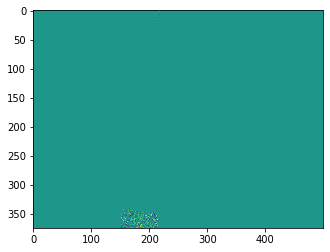

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_11511_469_469.png
check t shape
(442, 294)


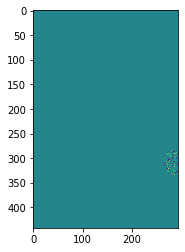

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_1429_804_804.png
check t shape
(245, 320)


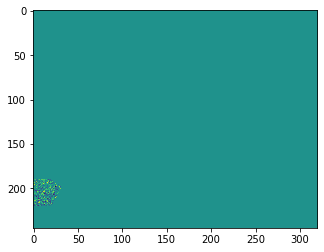

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_30513_21_21.png
check t shape
(333, 500)


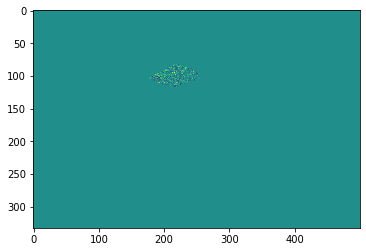

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_6566_550_550.png
check t shape
(222, 150)


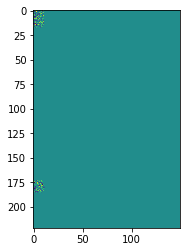

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_5598_218_218.png
check t shape
(344, 421)


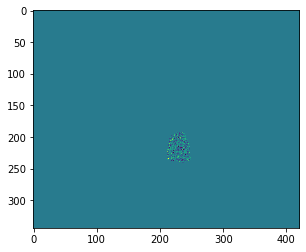

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_90528_513_513.png
check t shape
(375, 500)


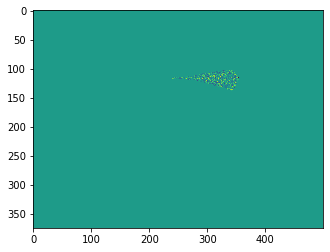

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_15097_404_404.png
check t shape
(457, 500)


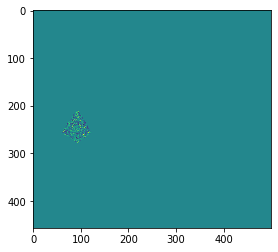

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_10208_568_568.png
check t shape
(375, 500)


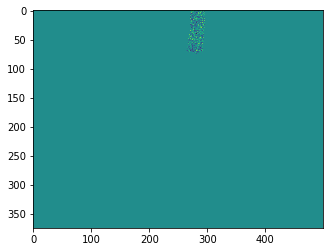

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_1612_429_429.png
check t shape
(533, 800)


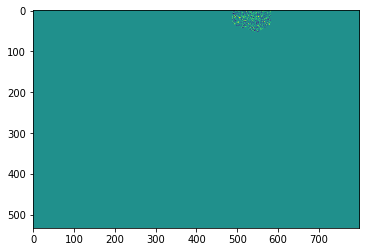

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_30576_998_998.png
check t shape
(332, 500)


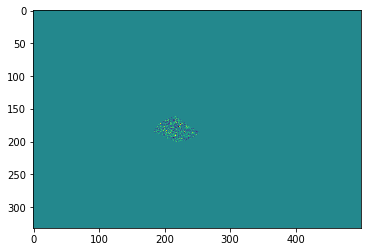

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_7507_988_988.png
check t shape
(375, 500)


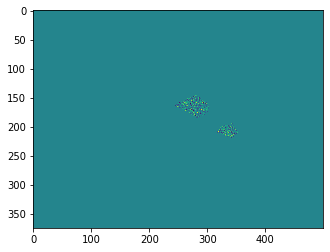

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_3690_885_885.png
check t shape
(225, 300)


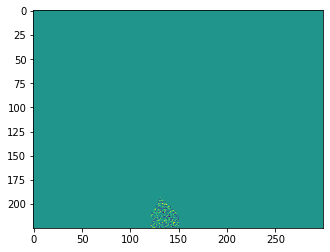

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_8153_218_218.png
check t shape
(333, 500)


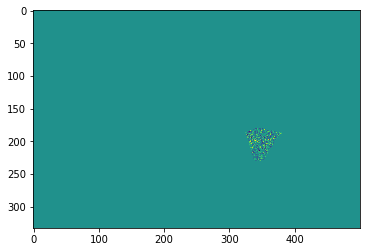

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_11917_21_21.png
check t shape
(433, 500)


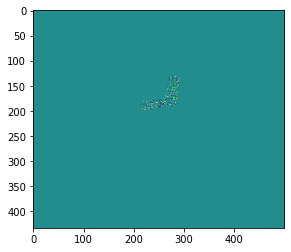

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_29784_988_988.png
check t shape
(375, 500)


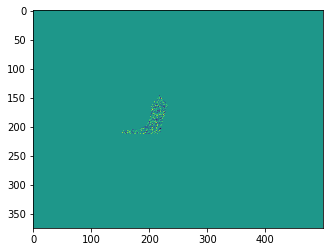

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_5620_670_670.png
check t shape
(375, 500)


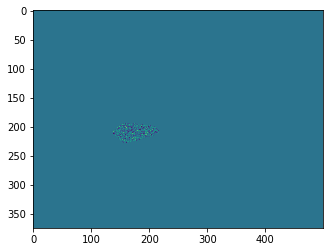

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_49632_979_979.png
check t shape
(500, 370)


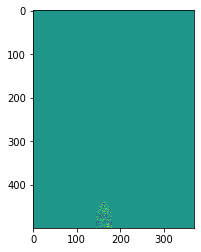

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_318_896_896.png
check t shape
(375, 500)


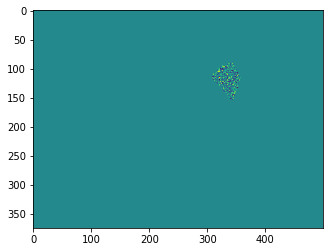

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_1670_913_913.png
check t shape
(333, 500)


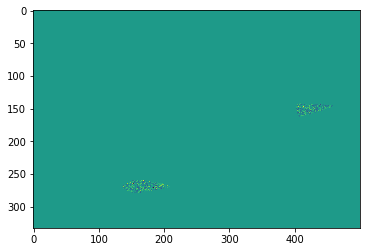

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_7819_27_27.png
check t shape
(333, 500)


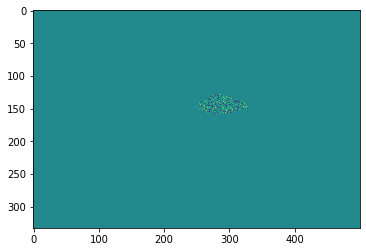

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_3181_605_605.png
check t shape
(375, 500)


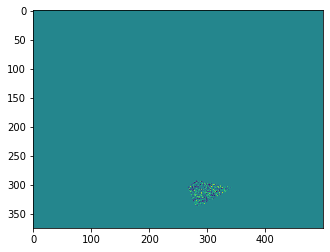

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_14059_581_581.png
check t shape
(333, 500)


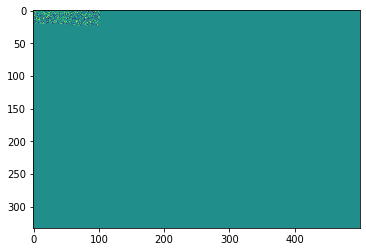

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_34832_670_670.png
check t shape
(574, 640)


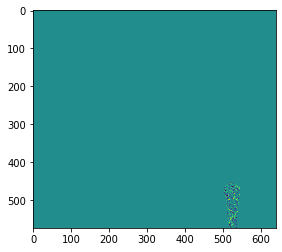

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_3311_804_804.png
check t shape
(375, 500)


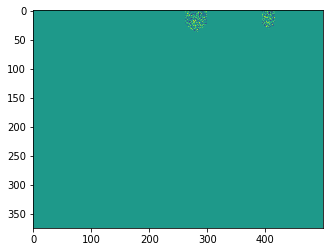

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_6668_648_648.png
check t shape
(299, 240)


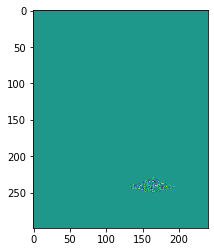

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_2568_804_804.png
check t shape
(240, 144)


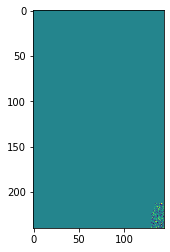

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_6645_804_804.png
check t shape
(500, 334)


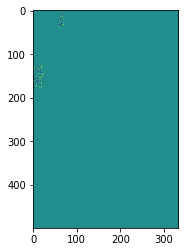

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_19828_696_696.png
check t shape
(500, 400)


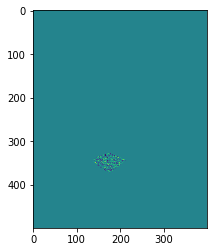

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_16618_664_664.png
check t shape
(375, 500)


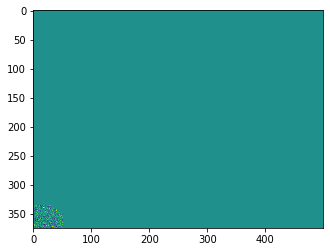

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_11382_713_713.png
check t shape
(375, 500)


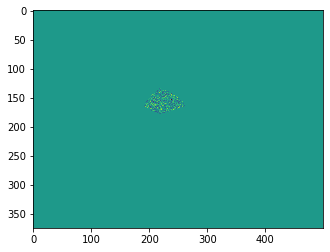

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_10267_470_470.png
check t shape
(360, 360)


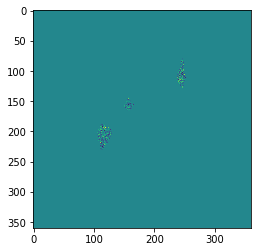

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_13843_469_469.png
check t shape
(365, 500)


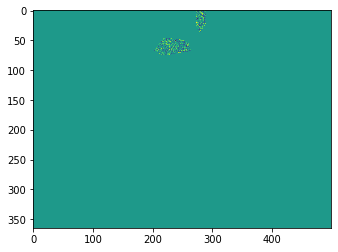

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_53377_470_470.png
check t shape
(375, 500)


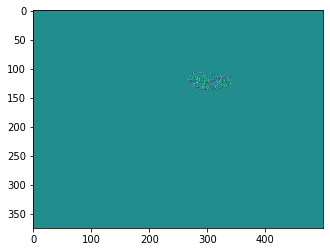

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_11895_470_470.png
check t shape
(863, 585)


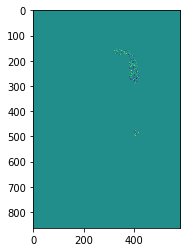

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_2567_630_630.png
check t shape
(82, 124)


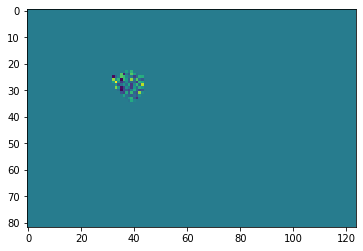

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_4712_886_886.png
check t shape
(1200, 774)


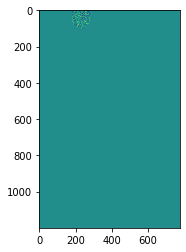

check the max index
462
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_28152_840_840.png
check t shape
(336, 600)


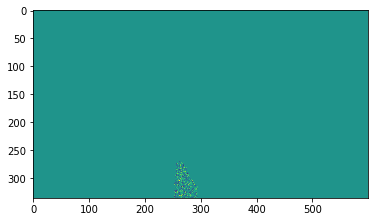

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_26263_896_896.png
check t shape
(480, 384)


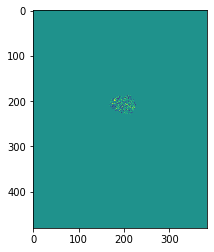

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_11525_428_428.png
check t shape
(375, 500)


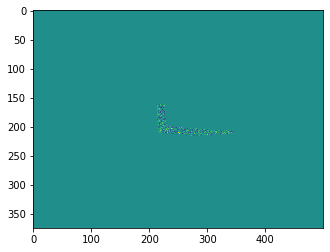

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_7109_31_31.png
check t shape
(500, 332)


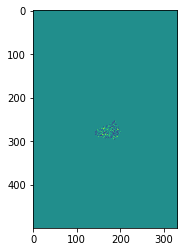

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_13976_21_21.png
check t shape
(333, 500)


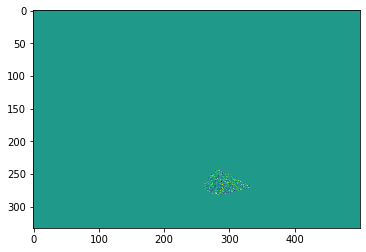

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_2746_935_935.png
check t shape
(375, 500)


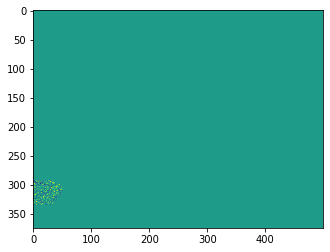

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_652_363_363.png
check t shape
(334, 500)


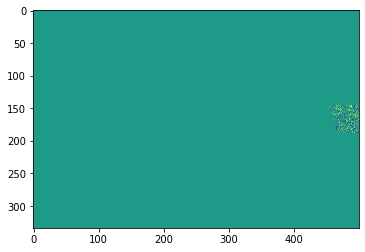

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_17127_975_975.png
check t shape
(375, 500)


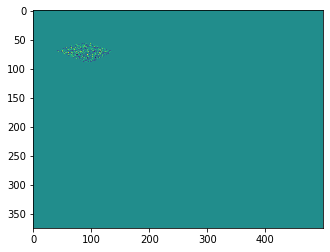

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_4637_630_630.png
check t shape
(500, 375)


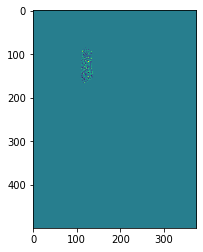

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_58085_979_979.png
check t shape
(333, 500)


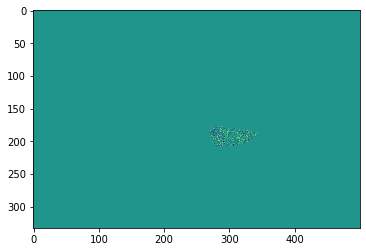

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_16931_235_235.png
check t shape
(375, 500)


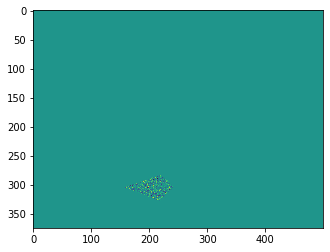

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_2919_316_316.png
check t shape
(375, 500)


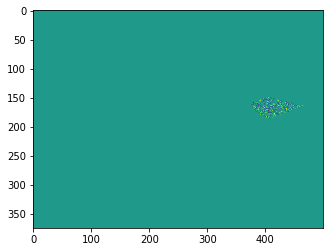

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_2046_92_92.png
check t shape
(500, 334)


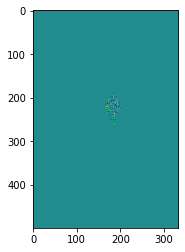

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_11401_886_886.png
check t shape
(375, 500)


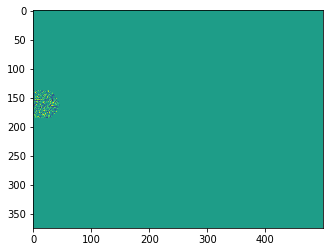

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_9435_21_21.png
check t shape
(365, 500)


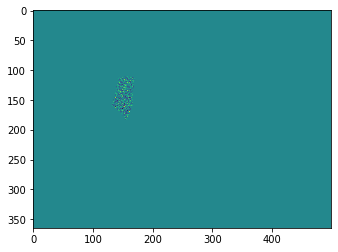

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_4022_33_33.png
check t shape
(334, 500)


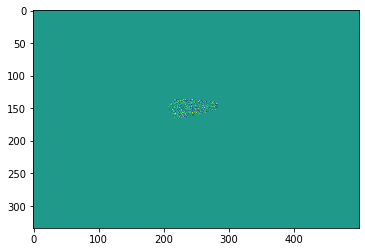

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_2887_215_215.png
check t shape
(758, 833)


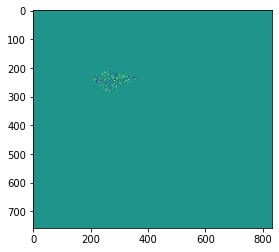

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_9760_232_232.png
check t shape
(600, 800)


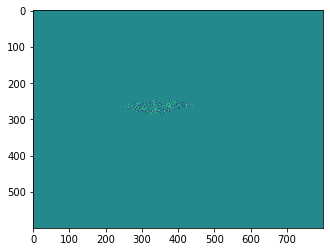

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_27147_979_979.png
check t shape
(375, 500)


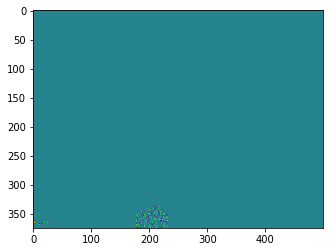

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_22493_352_352.png
check t shape
(375, 500)


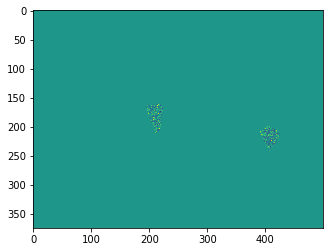

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_962_664_664.png
check t shape
(405, 540)


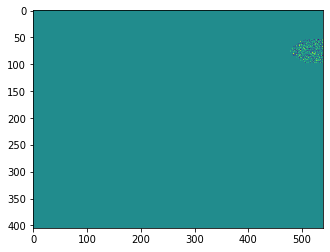

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_4928_215_215.png
check t shape
(1024, 1544)


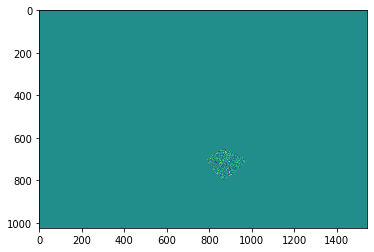

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_18572_27_27.png
check t shape
(333, 500)


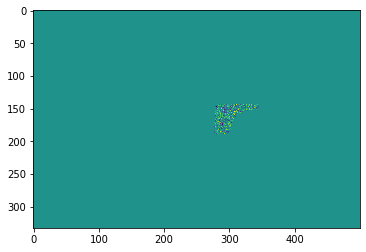

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_3260_605_605.png
check t shape
(329, 425)


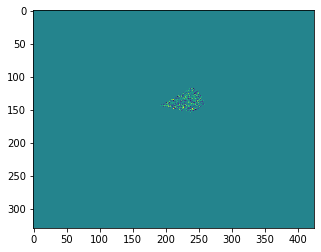

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_79656_998_998.png
check t shape
(283, 425)


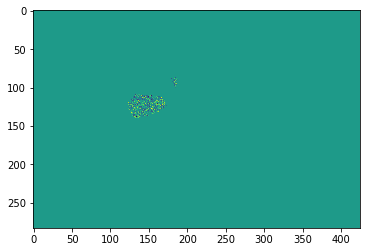

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_8185_316_316.png
check t shape
(500, 426)


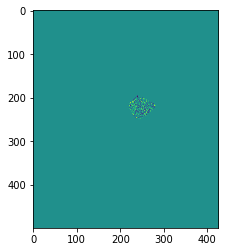

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_24896_982_982.png
check t shape
(333, 500)


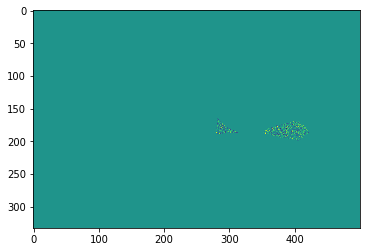

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_13899_566_566.png
check t shape
(500, 334)


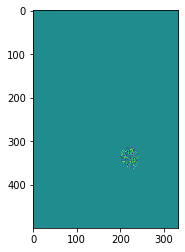

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_5784_673_673.png
check t shape
(320, 480)


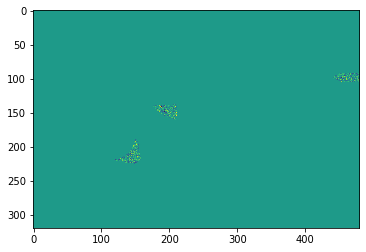

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_43755_429_429.png
check t shape
(333, 500)


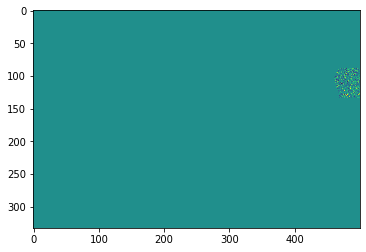

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_30703_310_310.png
check t shape
(500, 409)


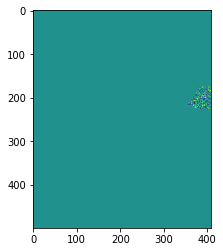

check the max index
36
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_10181_33_33.png
check t shape
(375, 500)


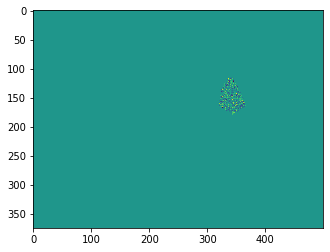

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_7628_673_673.png
check t shape
(400, 242)


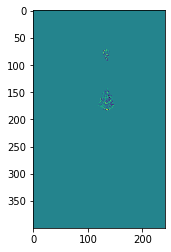

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_9798_713_713.png
check t shape
(480, 640)


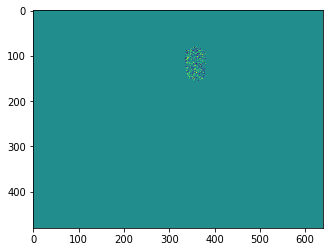

check the max index
462
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_25111_840_840.png
check t shape
(334, 500)


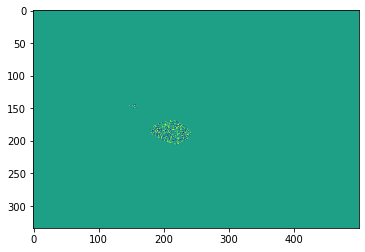

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_14812_21_21.png
check t shape
(341, 348)


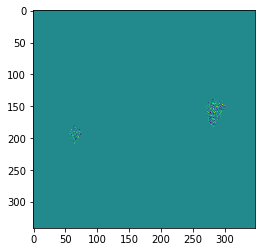

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_10493_886_886.png
check t shape
(500, 334)


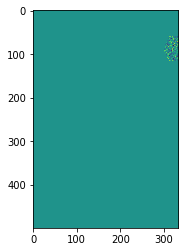

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_19050_896_896.png
check t shape
(375, 500)


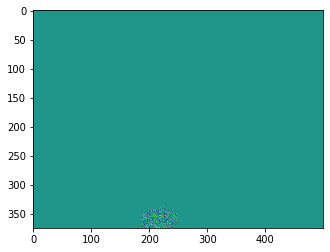

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_5132_885_885.png
check t shape
(113, 150)


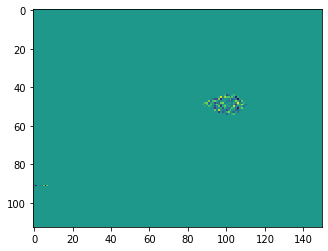

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_4982_648_648.png
check t shape
(1600, 1200)


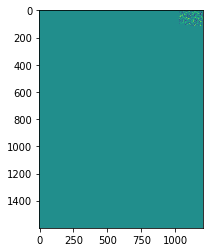

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_52276_566_566.png
check t shape
(900, 578)


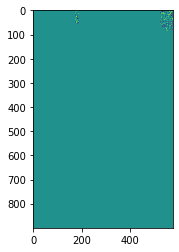

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_8554_648_648.png
check t shape
(500, 375)


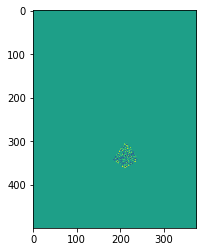

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_334_988_988.png
check t shape
(269, 380)


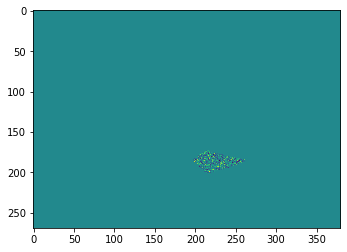

check the max index
638
638
./imagenet_fgsm/imagenet/fgsm/fgsm_n03710637_10690_638_638.png
check t shape
(364, 471)


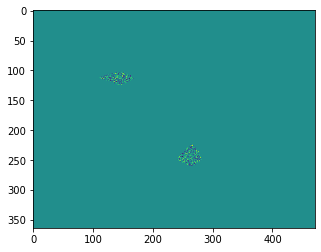

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_9681_982_982.png
check t shape
(500, 321)


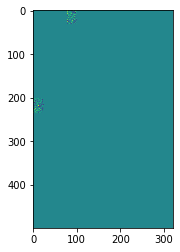

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_3305_713_713.png
check t shape
(332, 400)


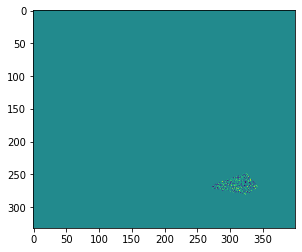

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_8867_630_630.png
check t shape
(375, 500)


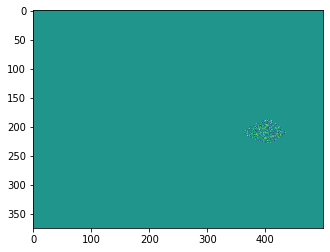

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_3690_605_605.png
check t shape
(450, 322)


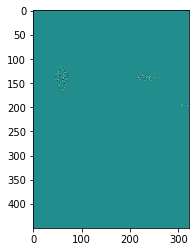

check the max index
225
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_79892_235_235.png
check t shape
(500, 328)


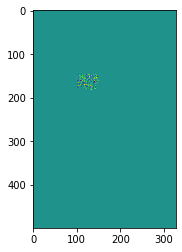

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_34656_469_469.png
check t shape
(379, 259)


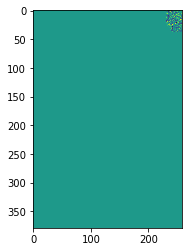

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_4492_886_886.png
check t shape
(981, 469)


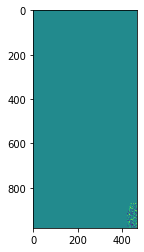

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_1335_232_232.png
check t shape
(373, 437)


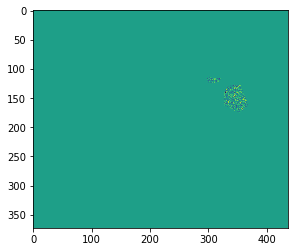

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_12092_232_232.png
check t shape
(333, 500)


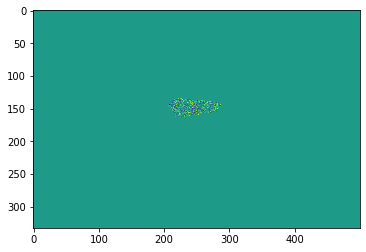

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_14797_886_886.png
check t shape
(375, 500)


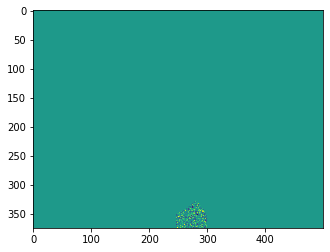

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_388_605_605.png
check t shape
(375, 500)


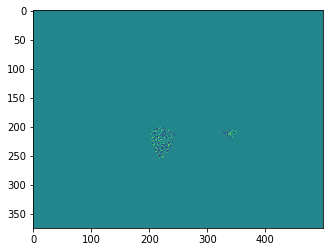

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_5056_581_581.png
check t shape
(375, 500)


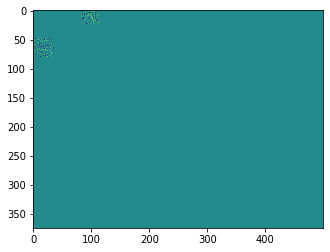

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_14158_428_428.png
check t shape
(333, 500)


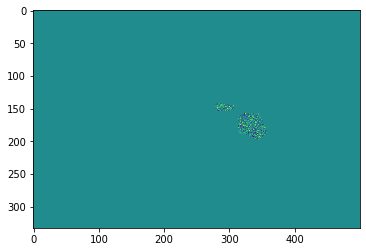

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_3110_404_404.png
check t shape
(375, 500)


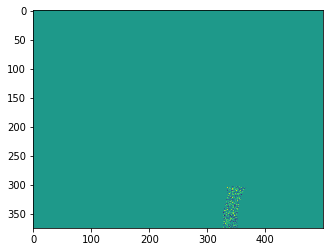

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_49_840_840.png
check t shape
(560, 560)


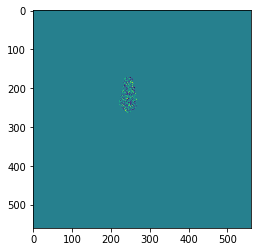

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_2460_896_896.png
check t shape
(333, 500)


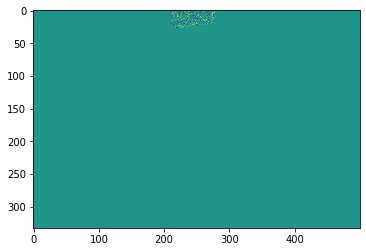

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_9749_363_363.png
check t shape
(450, 567)


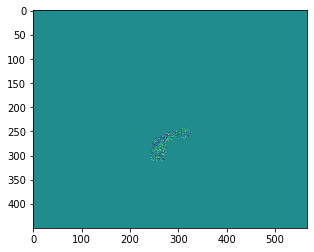

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_23154_840_840.png
check t shape
(500, 375)


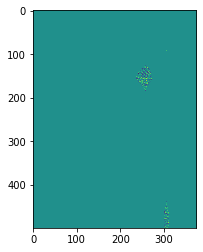

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_2673_804_804.png
check t shape
(375, 500)


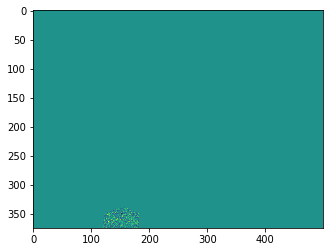

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_1502_550_550.png
check t shape
(567, 446)


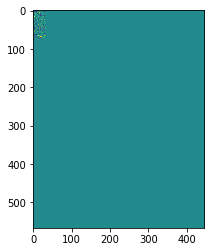

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_21408_979_979.png
check t shape
(375, 500)


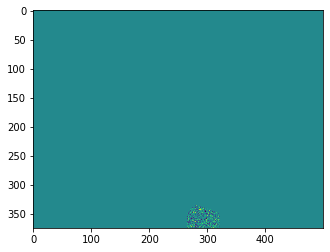

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_60091_979_979.png
check t shape
(500, 332)


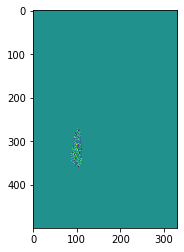

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_5808_913_913.png
check t shape
(333, 500)


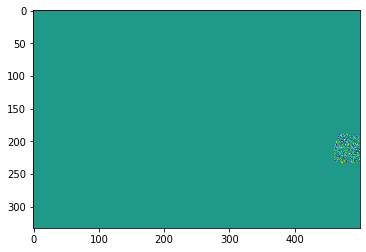

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_17367_469_469.png
check t shape
(320, 500)


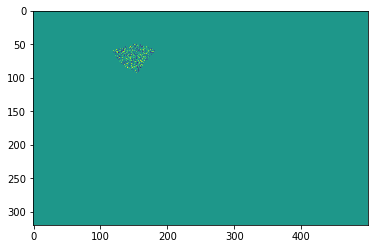

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_13935_21_21.png
check t shape
(500, 372)


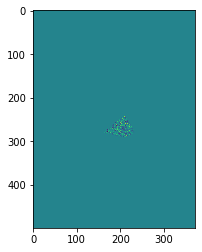

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_4994_428_428.png
check t shape
(377, 500)


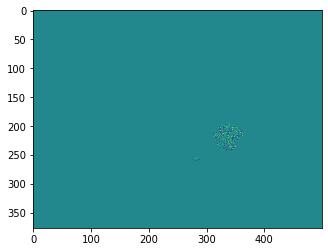

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_4835_27_27.png
check t shape
(228, 320)


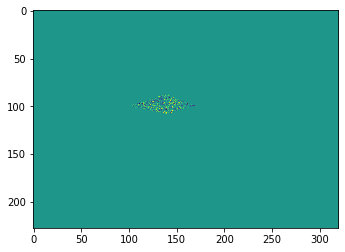

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_35196_896_896.png
check t shape
(275, 300)


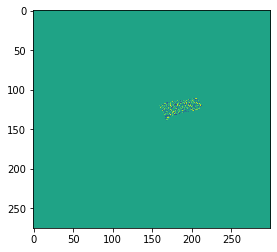

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_14855_470_470.png
check t shape
(500, 281)


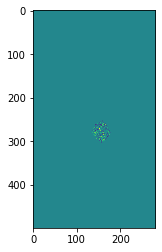

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_9061_935_935.png
check t shape
(424, 500)


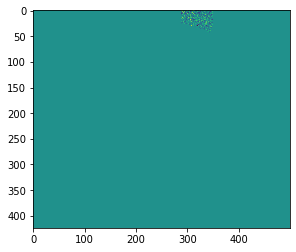

check the max index
784
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_13427_513_513.png
check t shape
(2046, 638)


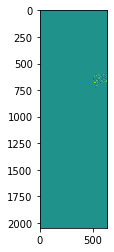

check the max index
264
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_11699_232_232.png
check t shape
(525, 700)


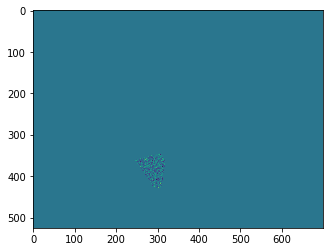

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_12281_428_428.png
check t shape
(375, 500)


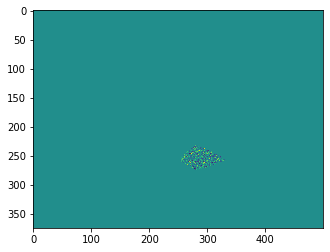

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_661_218_218.png
check t shape
(333, 500)


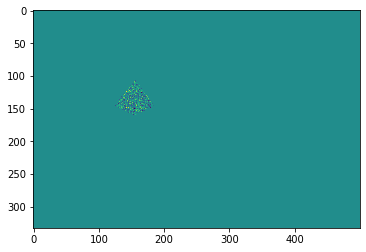

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_7673_27_27.png
check t shape
(375, 500)


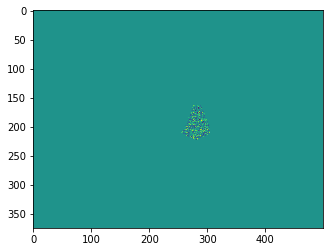

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_21556_448_448.png
check t shape
(480, 439)


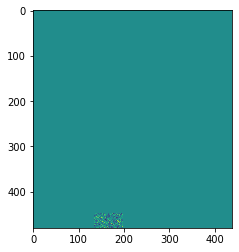

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_5518_469_469.png
check t shape
(181, 258)


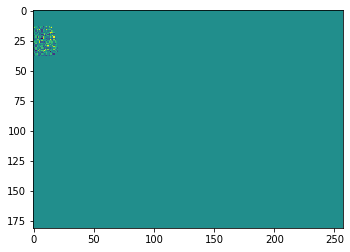

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_2562_428_428.png
check t shape
(150, 200)


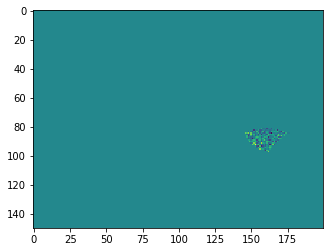

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_9479_696_696.png
check t shape
(500, 375)


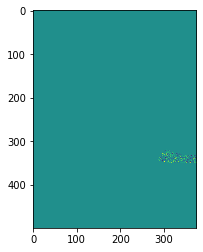

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_23645_470_470.png
check t shape
(500, 375)


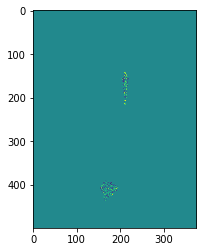

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_21586_982_982.png
check t shape
(500, 333)


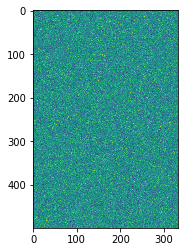

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_13400_998_998.png
check t shape
(384, 285)


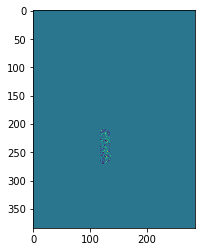

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_1849_673_673.png
check t shape
(328, 500)


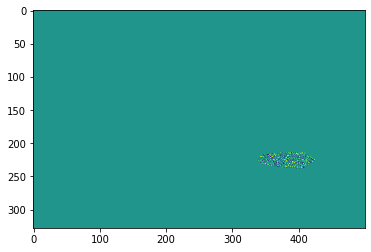

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_10144_840_840.png
check t shape
(400, 500)


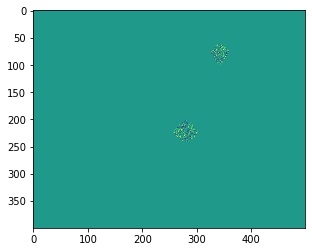

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_10561_361_361.png
check t shape
(372, 500)


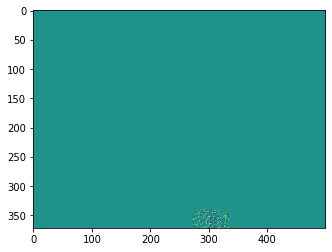

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_17186_448_448.png
check t shape
(375, 500)


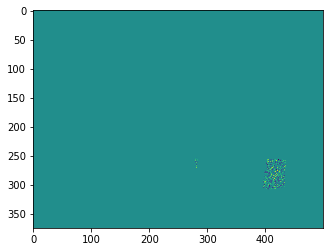

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_22691_92_92.png
check t shape
(336, 500)


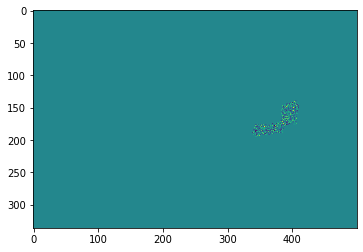

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_1454_630_630.png
check t shape
(250, 250)


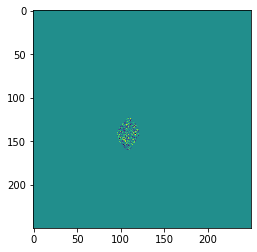

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_10206_215_215.png
check t shape
(333, 500)


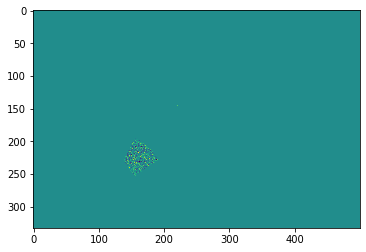

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_10161_648_648.png
check t shape
(332, 500)


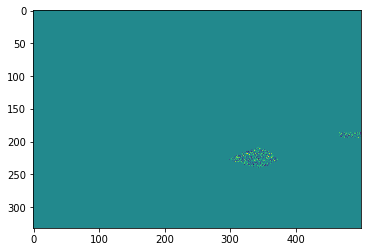

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_19693_885_885.png
check t shape
(500, 380)


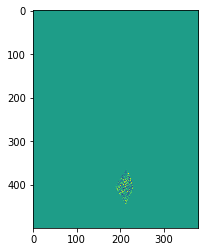

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_9580_566_566.png
check t shape
(320, 240)


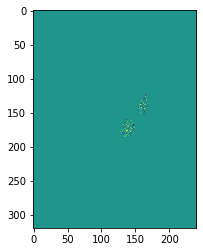

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_9961_913_913.png
check t shape
(374, 500)


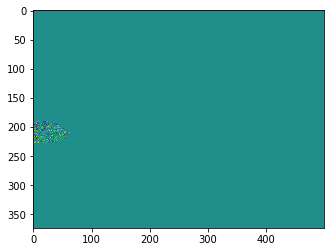

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_16035_232_232.png
check t shape
(333, 500)


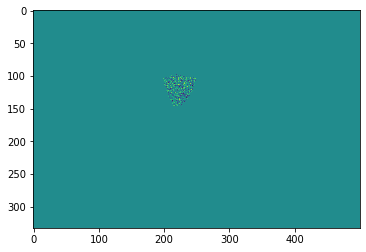

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_25247_361_361.png
check t shape
(219, 300)


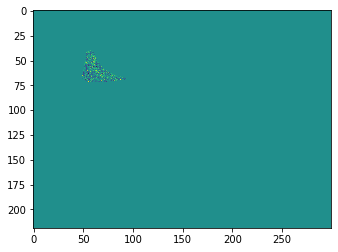

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_1477_550_550.png
check t shape
(280, 280)


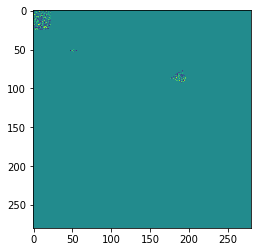

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_2551_92_92.png
check t shape
(500, 338)


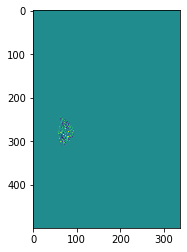

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_8380_21_21.png
check t shape
(401, 500)


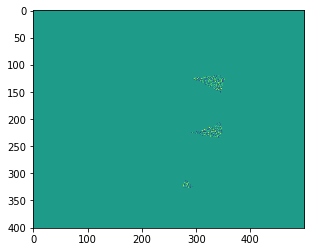

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_38914_896_896.png
check t shape
(300, 400)


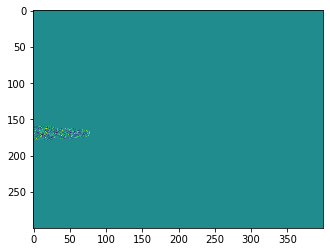

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_5446_316_316.png
check t shape
(375, 500)


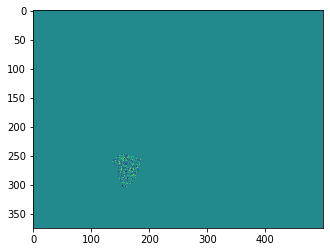

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_14063_886_886.png
check t shape
(375, 500)


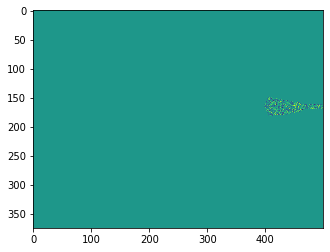

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_2328_913_913.png
check t shape
(375, 500)


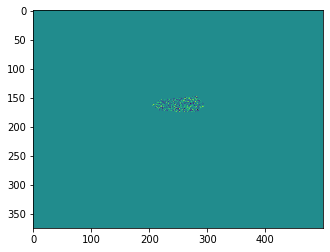

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_32672_33_33.png
check t shape
(375, 500)


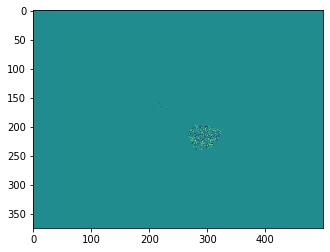

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_21158_975_975.png
check t shape
(354, 500)


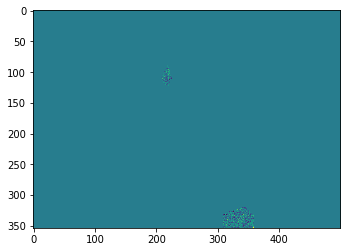

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_4909_469_469.png
check t shape
(172, 225)


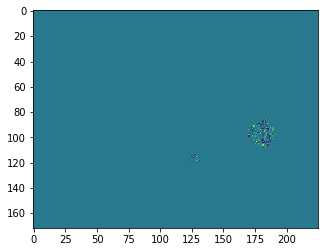

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_27194_873_873.png
check t shape
(375, 500)


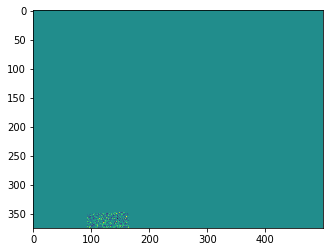

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_3394_21_21.png
check t shape
(333, 500)


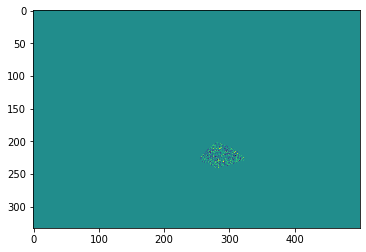

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_35828_470_470.png
check t shape
(333, 500)


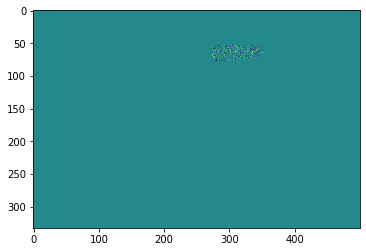

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_28538_998_998.png
check t shape
(1200, 1600)


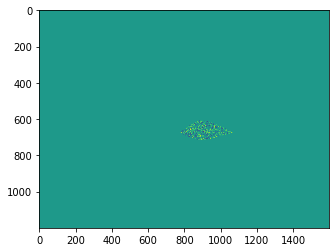

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_8728_92_92.png
check t shape
(500, 375)


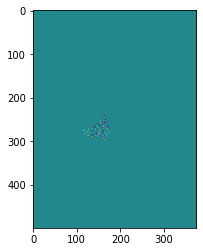

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_3184_873_873.png
check t shape
(480, 640)


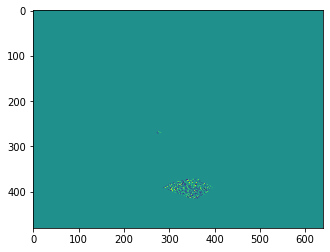

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_5841_581_581.png
check t shape
(333, 500)


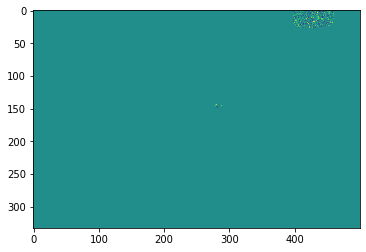

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_85592_979_979.png
check t shape
(400, 534)


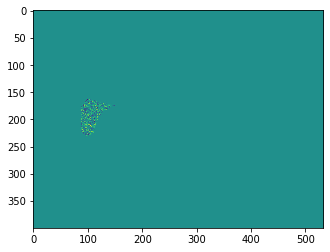

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_10533_429_429.png
check t shape
(375, 500)


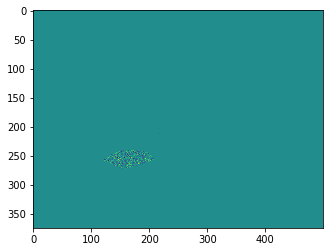

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_12776_913_913.png
check t shape
(462, 308)


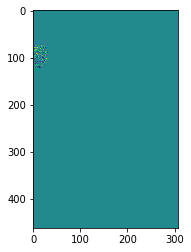

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_342_873_873.png
check t shape
(500, 375)


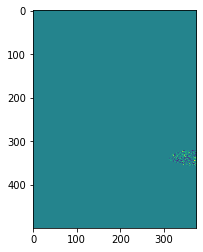

check the max index
987
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_1376_998_998.png
check t shape
(480, 640)


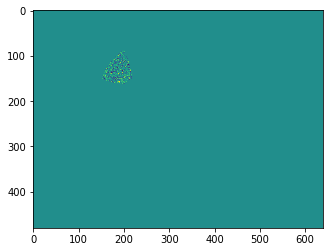

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_10567_886_886.png
check t shape
(500, 333)


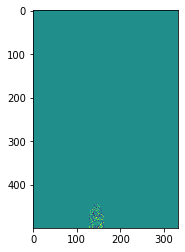

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_20407_235_235.png
check t shape
(375, 500)


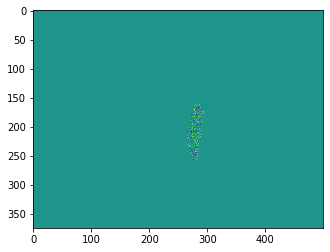

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_4245_218_218.png
check t shape
(500, 335)


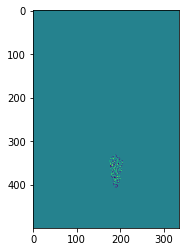

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_10624_648_648.png
check t shape
(435, 280)


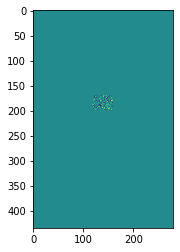

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_6334_218_218.png
check t shape
(333, 500)


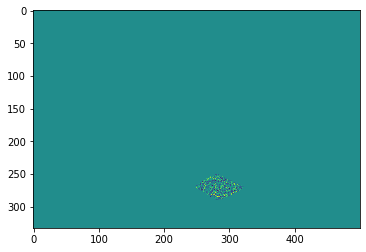

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_1828_92_92.png
check t shape
(391, 500)


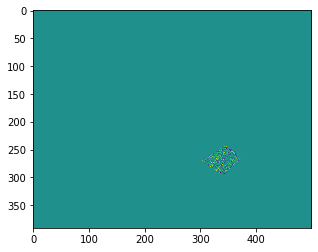

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_13934_885_885.png
check t shape
(400, 400)


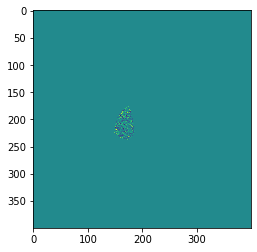

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_3728_21_21.png
check t shape
(321, 500)


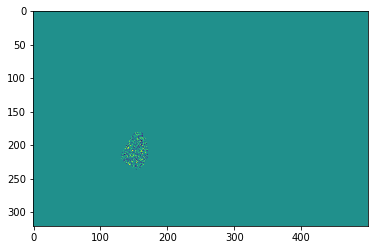

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_7917_428_428.png
check t shape
(500, 375)


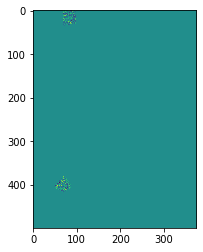

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_2959_448_448.png
check t shape
(375, 500)


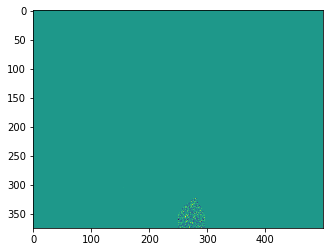

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_21116_840_840.png
check t shape
(360, 360)


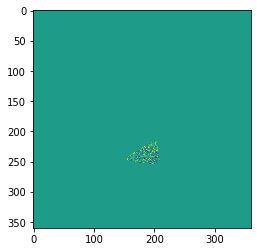

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_3816_664_664.png
check t shape
(375, 500)


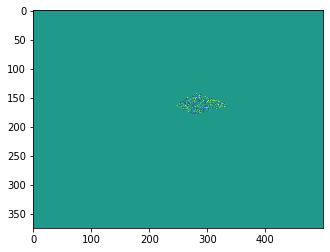

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_16362_513_513.png
check t shape
(747, 560)


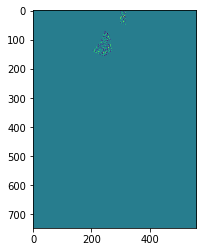

check the max index
230
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_3104_232_232.png
check t shape
(374, 500)


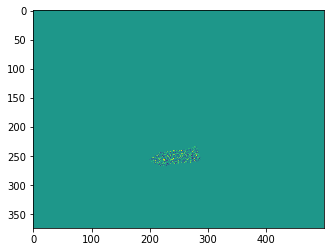

check the max index
887
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_6185_885_885.png
check t shape
(394, 525)


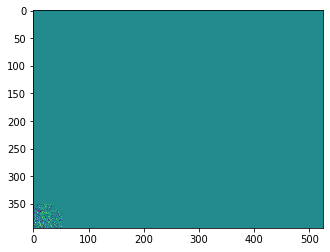

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_5228_896_896.png
check t shape
(333, 500)


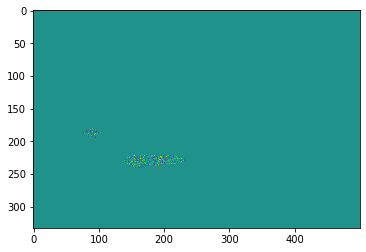

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_9139_988_988.png
check t shape
(333, 500)


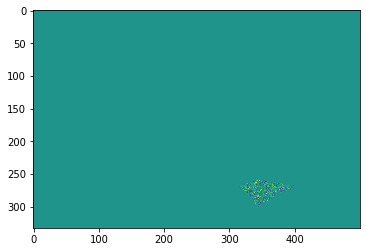

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_31003_566_566.png
check t shape
(500, 335)


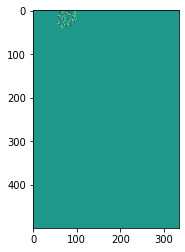

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_11141_896_896.png
check t shape
(500, 375)


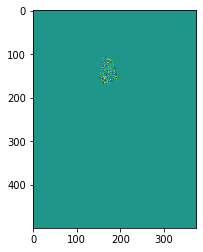

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_21012_513_513.png
check t shape
(480, 640)


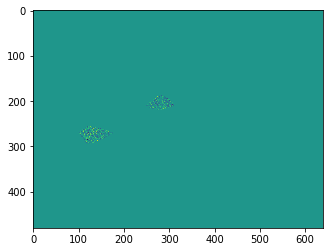

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_5951_673_673.png
check t shape
(358, 500)


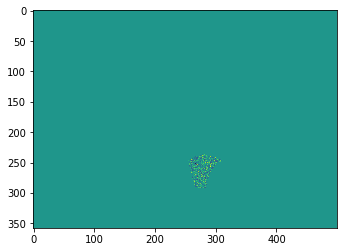

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_19798_232_232.png
check t shape
(333, 500)


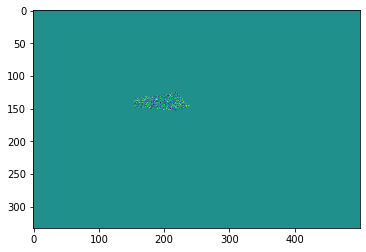

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_923_696_696.png
check t shape
(375, 500)


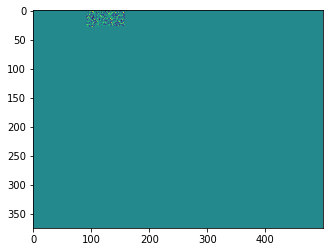

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_87877_513_513.png
check t shape
(335, 500)


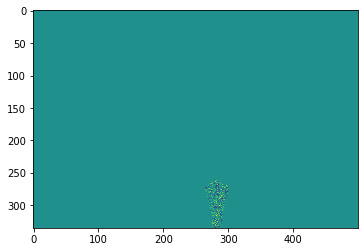

check the max index
489
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_24704_840_840.png
check t shape
(494, 500)


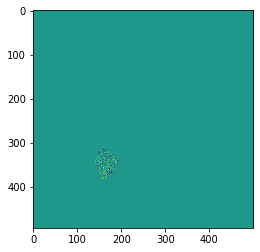

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_5394_429_429.png
check t shape
(400, 400)


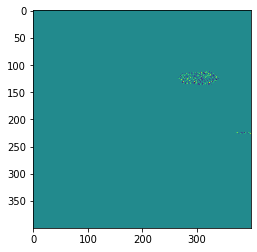

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_4963_982_982.png
check t shape
(500, 333)


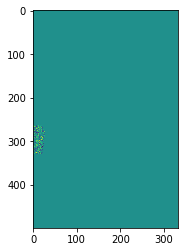

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_9410_215_215.png
check t shape
(462, 500)


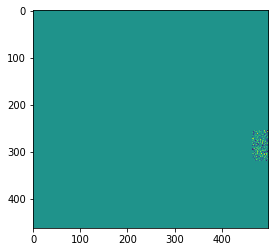

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_1874_232_232.png
check t shape
(375, 500)


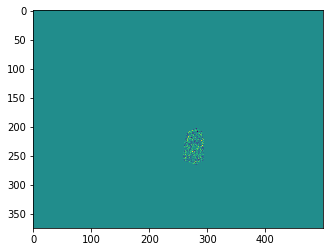

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_16213_566_566.png
check t shape
(598, 900)


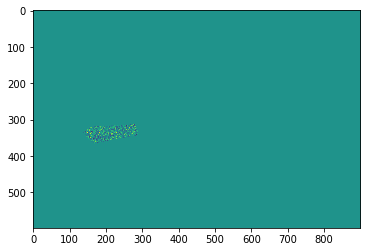

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_1166_469_469.png
check t shape
(512, 501)


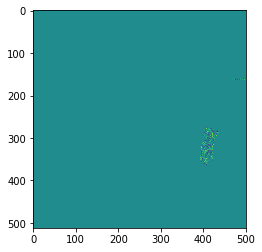

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_5239_568_568.png
check t shape
(629, 450)


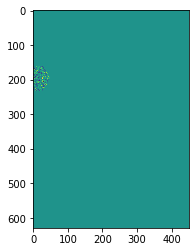

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_6960_670_670.png
check t shape
(500, 441)


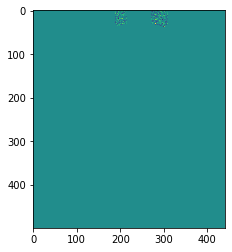

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_30176_310_310.png
check t shape
(343, 500)


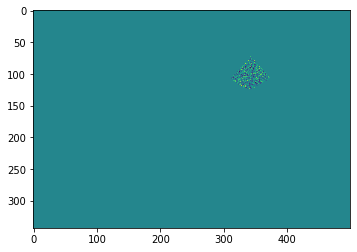

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_21181_696_696.png
check t shape
(500, 500)


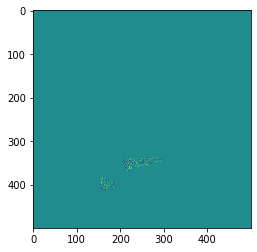

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_2508_696_696.png
check t shape
(380, 269)


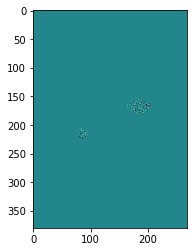

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_27024_448_448.png
check t shape
(333, 500)


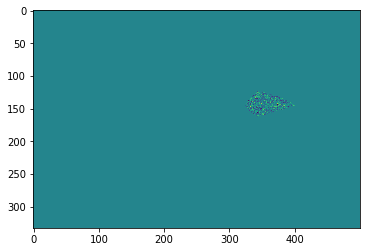

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_19353_469_469.png
check t shape
(337, 500)


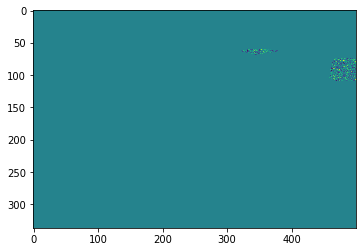

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_7250_670_670.png
check t shape
(377, 500)


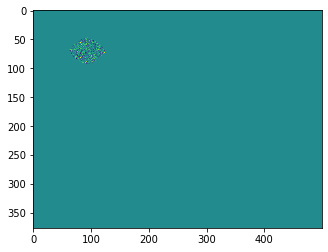

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_30847_979_979.png
check t shape
(375, 500)


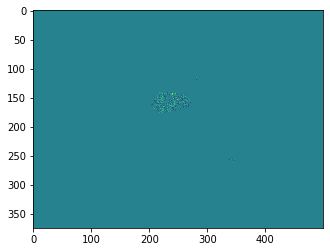

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_2721_316_316.png
check t shape
(360, 500)


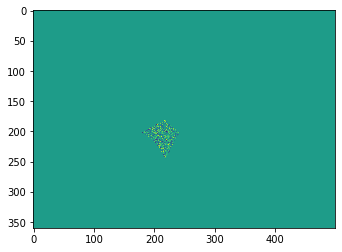

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_19712_982_982.png
check t shape
(500, 333)


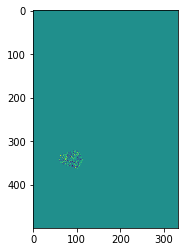

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_12387_352_352.png
check t shape
(334, 500)


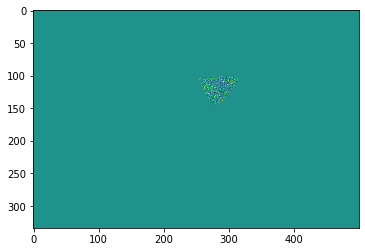

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_11474_31_31.png
check t shape
(333, 500)


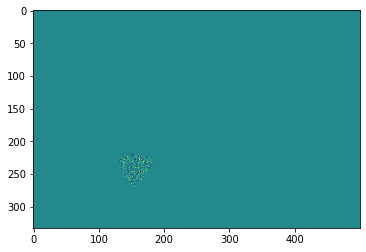

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_3828_988_988.png
check t shape
(333, 500)


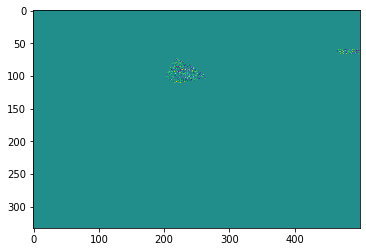

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_16537_33_33.png
check t shape
(333, 500)


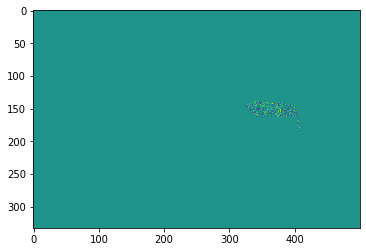

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_1549_316_316.png
check t shape
(480, 640)


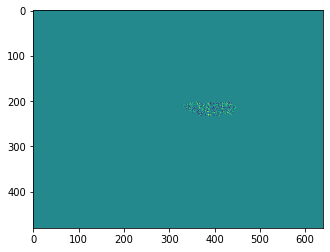

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_10583_840_840.png
check t shape
(500, 384)


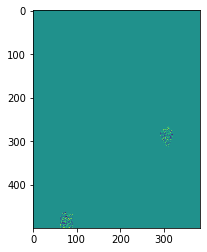

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_22528_896_896.png
check t shape
(333, 500)


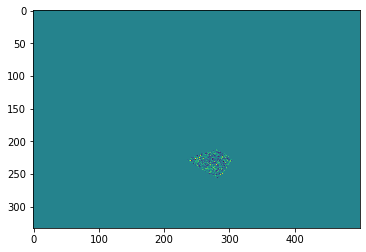

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_5259_648_648.png
check t shape
(500, 375)


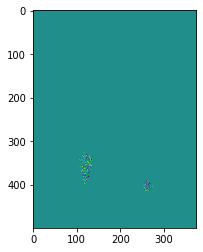

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_2765_873_873.png
check t shape
(1600, 1200)


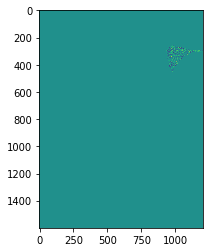

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_1931_429_429.png
check t shape
(257, 270)


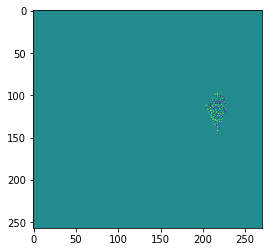

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_26811_670_670.png
check t shape
(500, 375)


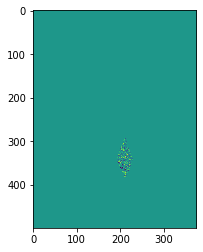

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_2265_361_361.png
check t shape
(500, 431)


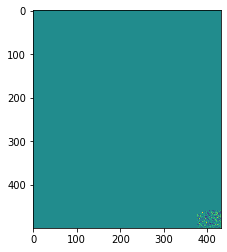

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_2688_448_448.png
check t shape
(492, 500)


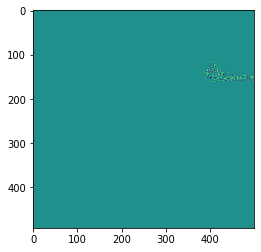

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_3689_605_605.png
check t shape
(500, 375)


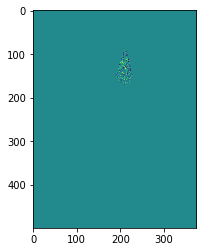

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_12024_913_913.png
check t shape
(282, 500)


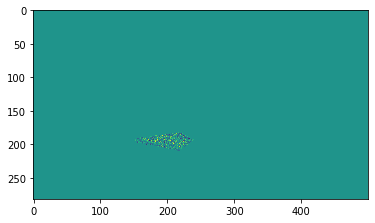

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_8941_988_988.png
check t shape
(375, 500)


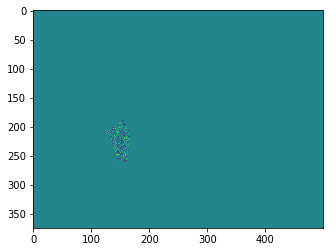

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_9401_404_404.png
check t shape
(329, 500)


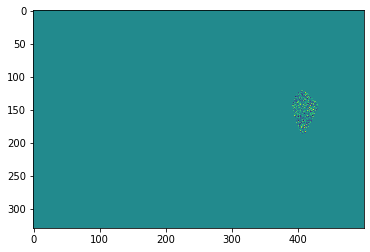

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_32106_979_979.png
check t shape
(375, 500)


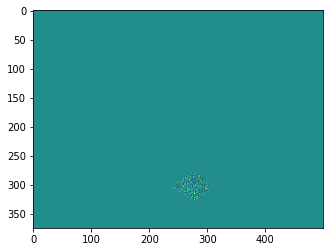

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_19417_982_982.png
check t shape
(358, 500)


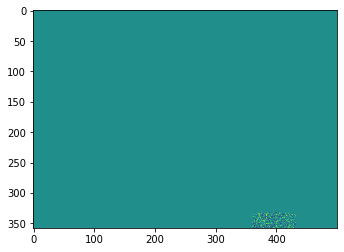

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_5876_673_673.png
check t shape
(375, 500)


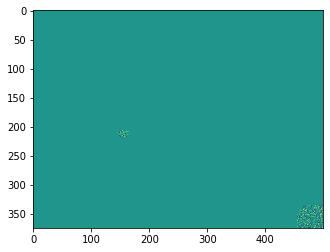

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_8760_428_428.png
check t shape
(315, 500)


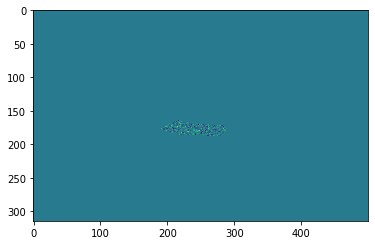

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_77895_513_513.png
check t shape
(500, 339)


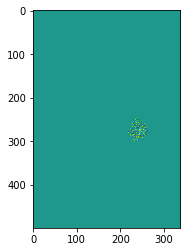

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_9072_581_581.png
check t shape
(375, 500)


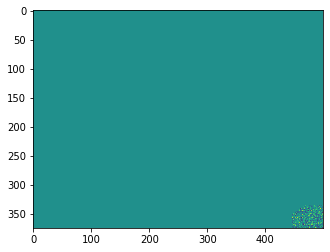

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_40004_673_673.png
check t shape
(347, 450)


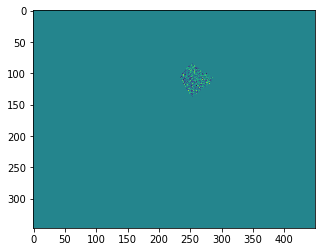

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_30710_469_469.png
check t shape
(266, 300)


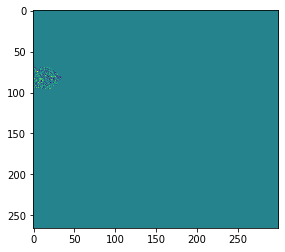

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_143_27_27.png
check t shape
(375, 500)


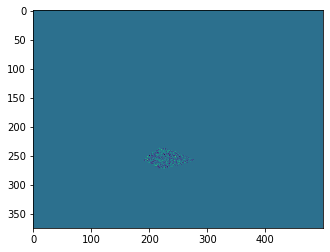

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_300_235_235.png
check t shape
(500, 375)


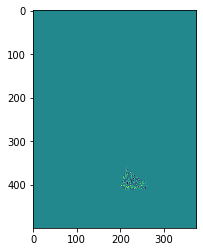

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_89057_979_979.png
check t shape
(297, 396)


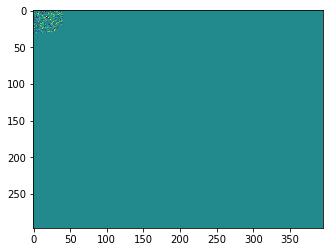

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_6904_469_469.png
check t shape
(448, 600)


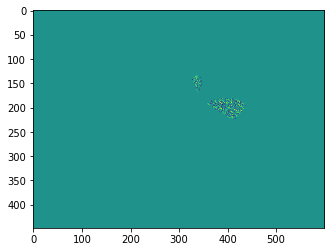

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_11020_31_31.png
check t shape
(376, 609)


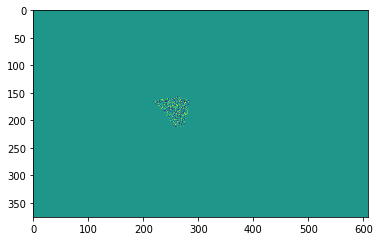

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_4230_568_568.png
check t shape
(590, 340)


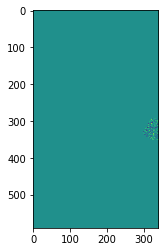

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_12147_235_235.png
check t shape
(379, 500)


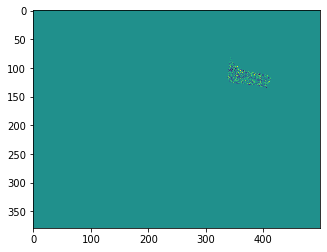

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_981_935_935.png
check t shape
(334, 500)


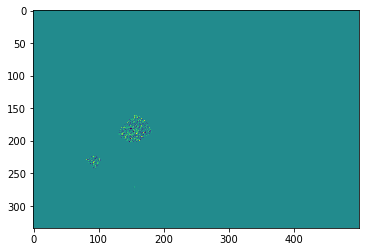

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_13522_469_469.png
check t shape
(250, 230)


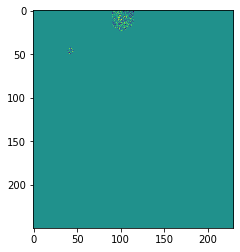

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_1246_873_873.png
check t shape
(500, 375)


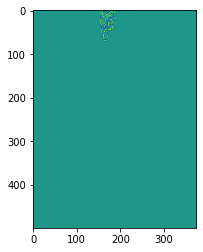

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_2275_982_982.png
check t shape
(500, 436)


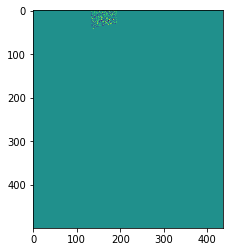

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_6501_979_979.png
check t shape
(374, 500)


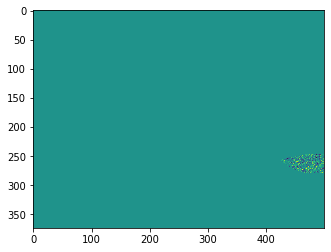

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_7251_568_568.png
check t shape
(391, 500)


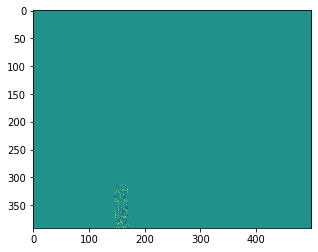

check the max index
876
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_1025_896_896.png
check t shape
(500, 375)


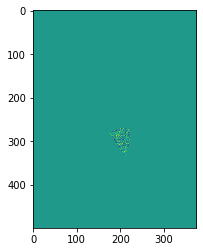

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_10673_840_840.png
check t shape
(500, 375)


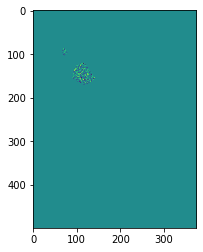

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_846_605_605.png
check t shape
(375, 500)


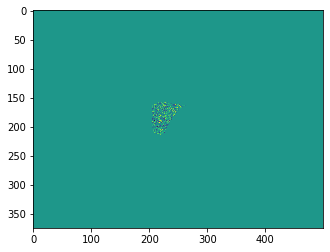

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_6984_363_363.png
check t shape
(560, 689)


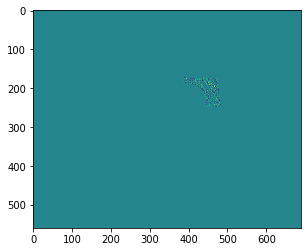

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_15396_31_31.png
check t shape
(777, 1171)


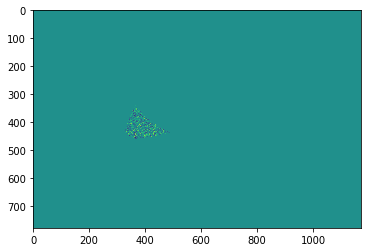

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_6952_428_428.png
check t shape
(375, 500)


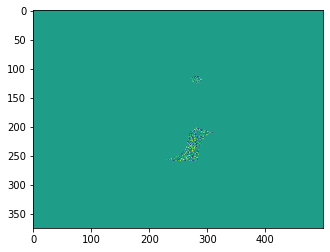

check the max index
891
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_33553_469_469.png
check t shape
(430, 282)


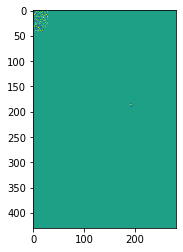

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_26421_988_988.png
check t shape
(375, 500)


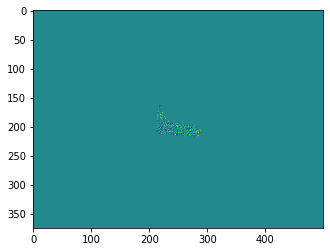

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_3981_215_215.png
check t shape
(375, 500)


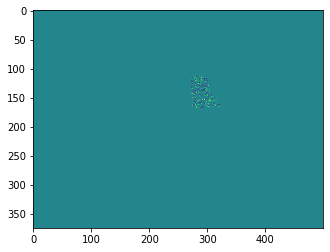

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_23024_975_975.png
check t shape
(333, 500)


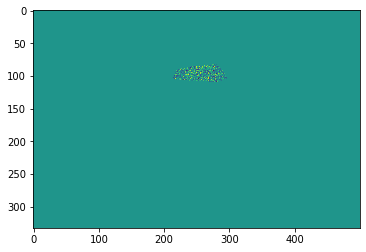

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_4327_913_913.png
check t shape
(375, 500)


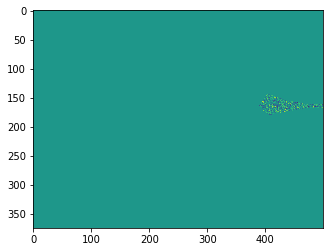

check the max index
909
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_34856_469_469.png
check t shape
(546, 640)


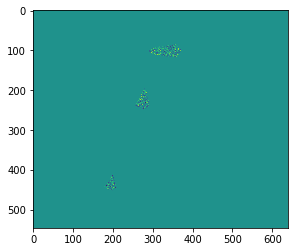

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_1359_218_218.png
check t shape
(220, 313)


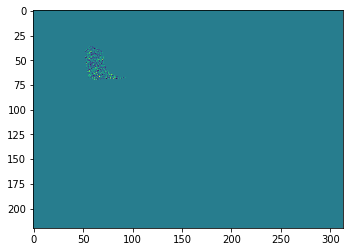

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_3224_605_605.png
check t shape
(272, 500)


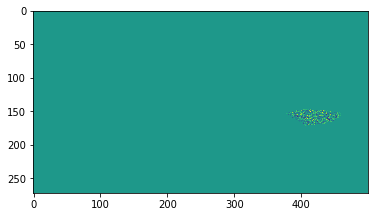

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_32925_429_429.png
check t shape
(201, 300)


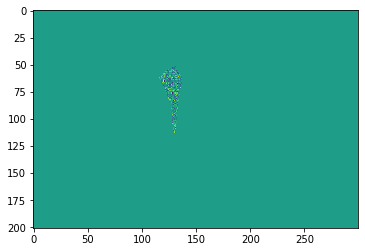

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_7163_232_232.png
check t shape
(375, 500)


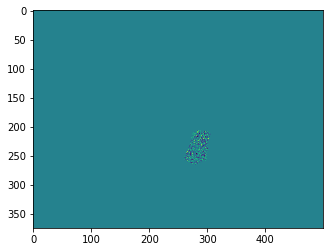

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_33278_235_235.png
check t shape
(720, 900)


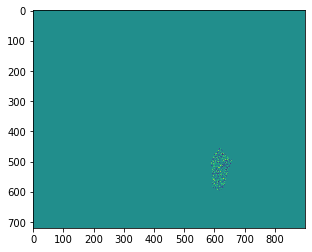

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_4539_363_363.png
check t shape
(270, 360)


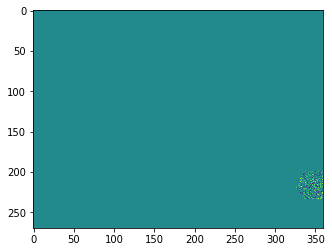

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_7062_605_605.png
check t shape
(333, 500)


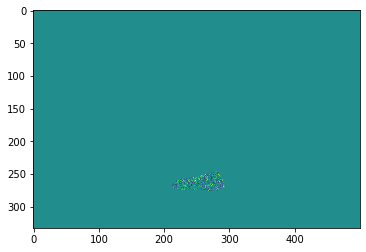

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_10632_235_235.png
check t shape
(390, 500)


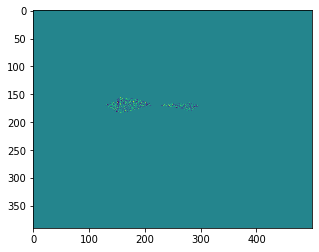

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_481_448_448.png
check t shape
(475, 426)


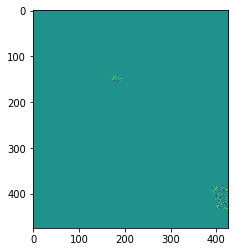

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_7703_886_886.png
check t shape
(640, 963)


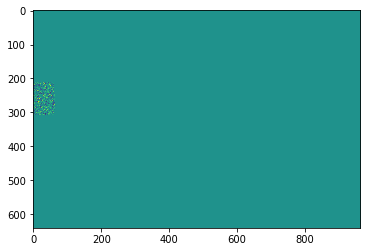

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_17198_469_469.png
check t shape
(177, 200)


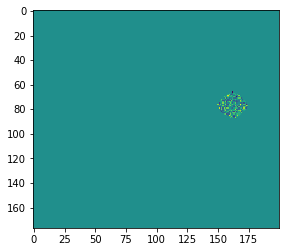

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_711_568_568.png
check t shape
(500, 375)


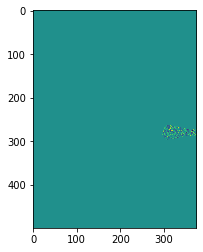

check the max index
335
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_55951_998_998.png
check t shape
(938, 1465)


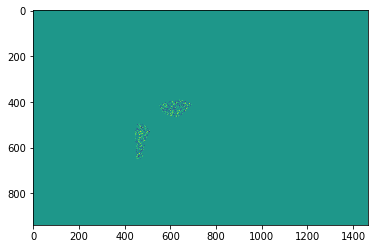

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_1656_804_804.png
check t shape
(225, 225)


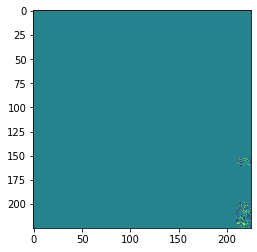

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_8730_31_31.png
check t shape
(432, 500)


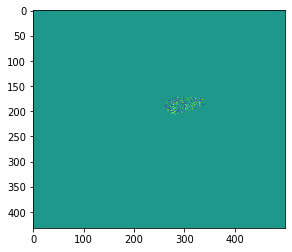

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_21563_310_310.png
check t shape
(375, 500)


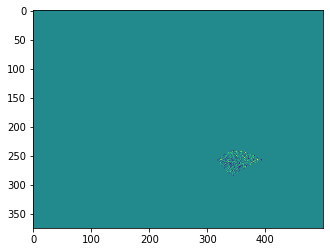

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_14842_673_673.png
check t shape
(250, 320)


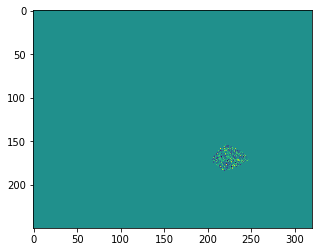

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_10304_232_232.png
check t shape
(341, 500)


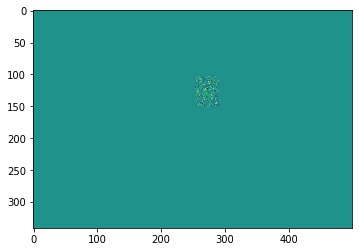

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_27396_310_310.png
check t shape
(375, 500)


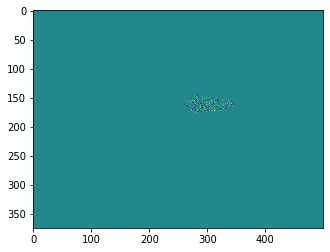

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_33552_469_469.png
check t shape
(500, 375)


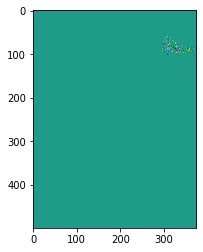

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_9245_470_470.png
check t shape
(400, 500)


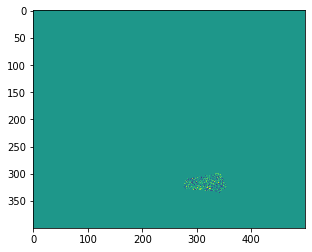

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_4475_630_630.png
check t shape
(231, 240)


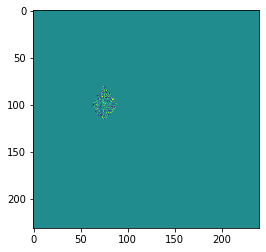

check the max index
312
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_19449_310_310.png
check t shape
(96, 96)


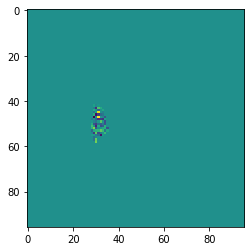

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_39562_429_429.png
check t shape
(375, 500)


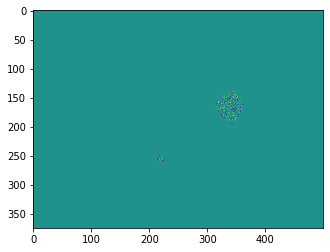

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_9797_886_886.png
check t shape
(500, 375)


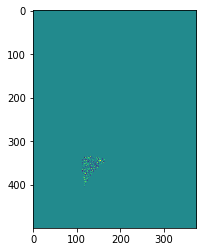

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_27776_21_21.png
check t shape
(500, 333)


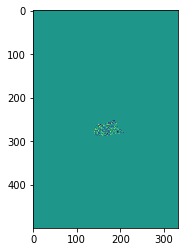

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_12226_316_316.png
check t shape
(500, 388)


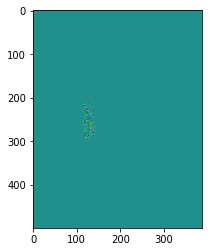

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_18462_873_873.png
check t shape
(333, 500)


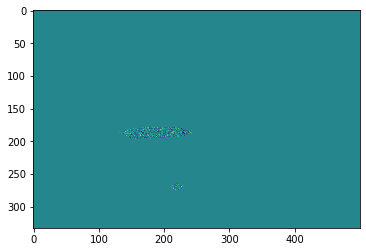

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_59133_235_235.png
check t shape
(223, 156)


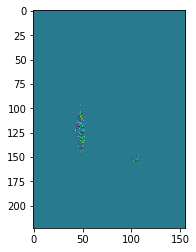

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_57293_670_670.png
check t shape
(525, 700)


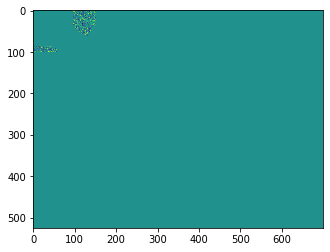

check the max index
527
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_9549_664_664.png
check t shape
(375, 500)


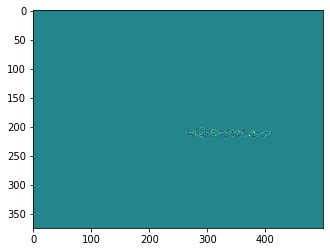

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_263_470_470.png
check t shape
(332, 250)


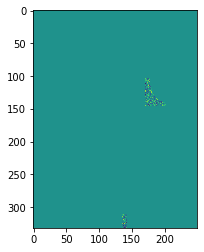

check the max index
212
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_1150_218_218.png
check t shape
(335, 500)


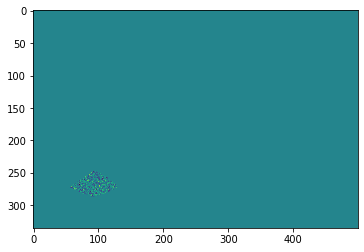

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_8149_886_886.png
check t shape
(375, 500)


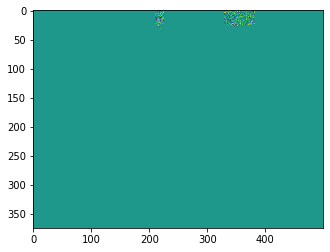

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_18772_975_975.png
check t shape
(375, 500)


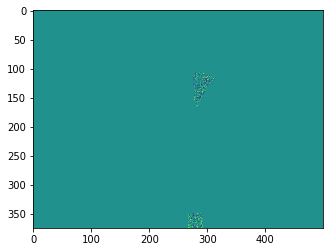

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_396_31_31.png
check t shape
(278, 500)


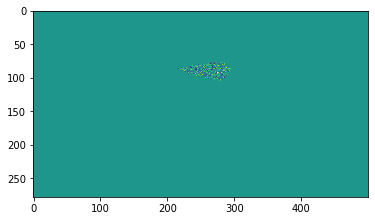

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_9817_886_886.png
check t shape
(375, 500)


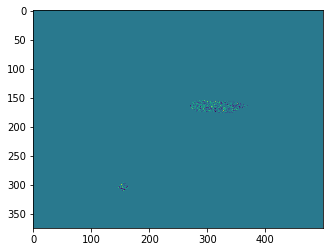

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_33240_429_429.png
check t shape
(250, 250)


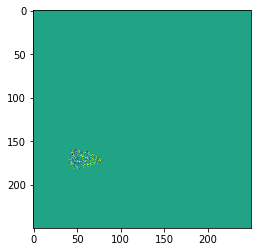

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_13039_21_21.png
check t shape
(500, 357)


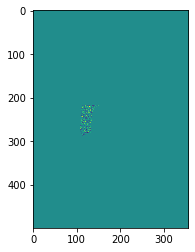

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_16012_432_432.png
check t shape
(333, 500)


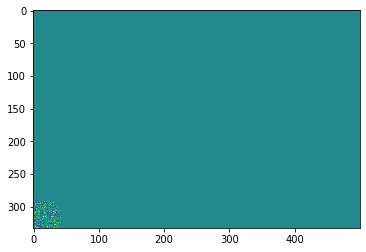

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_4519_218_218.png
check t shape
(333, 500)


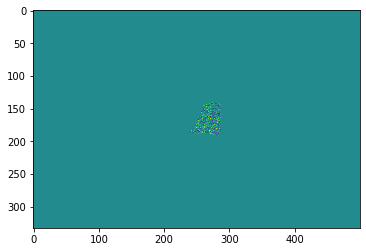

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_11599_232_232.png
check t shape
(325, 450)


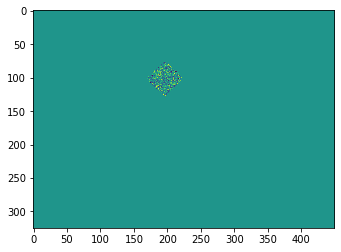

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_5567_470_470.png
check t shape
(500, 563)


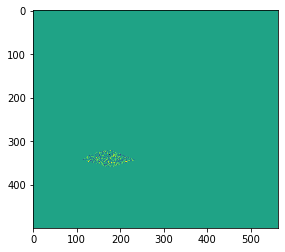

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_85474_513_513.png
check t shape
(500, 351)


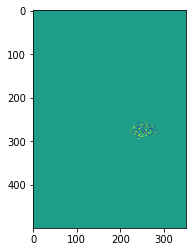

check the max index
411
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_7602_885_885.png
check t shape
(300, 400)


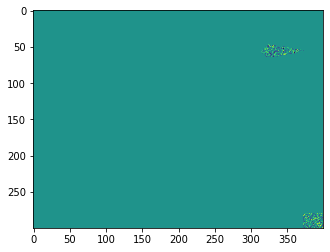

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_31220_469_469.png
check t shape
(360, 480)


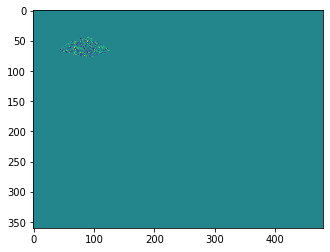

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_2867_363_363.png
check t shape
(143, 200)


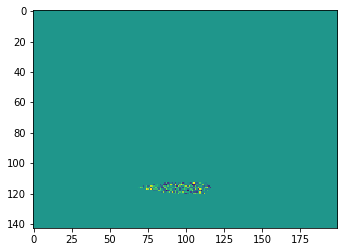

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_10664_316_316.png
check t shape
(336, 500)


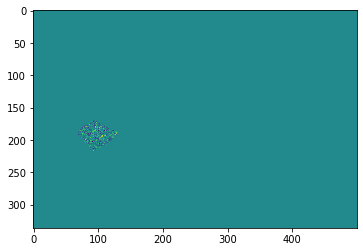

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_24614_873_873.png
check t shape
(375, 500)


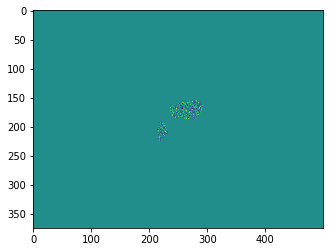

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_4323_235_235.png
check t shape
(375, 500)


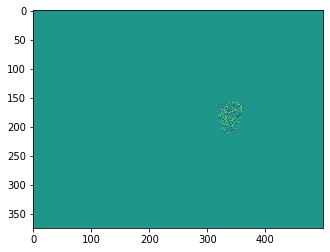

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_5110_886_886.png
check t shape
(500, 375)


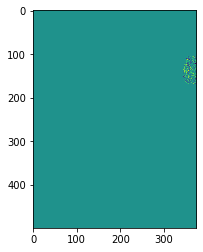

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_3861_352_352.png
check t shape
(290, 500)


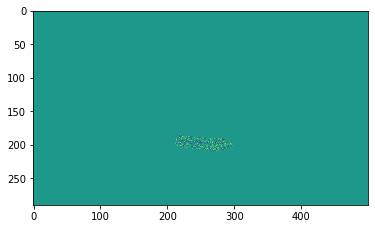

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_427_605_605.png
check t shape
(507, 504)


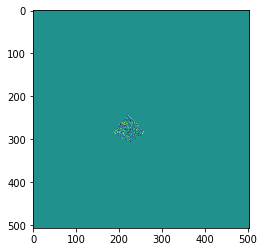

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_2687_235_235.png
check t shape
(375, 500)


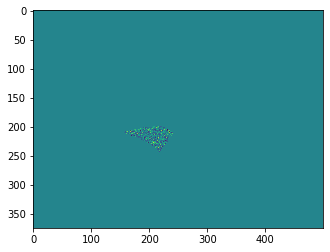

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_15973_982_982.png
check t shape
(500, 500)


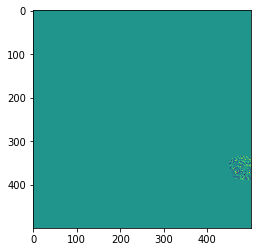

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_25705_429_429.png
check t shape
(333, 500)


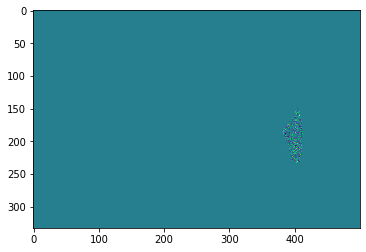

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_229_935_935.png
check t shape
(375, 500)


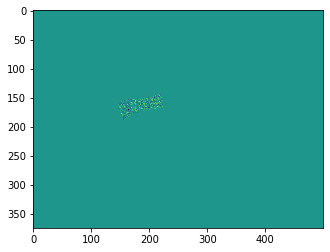

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_28497_432_432.png
check t shape
(375, 500)


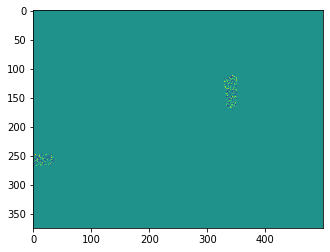

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_10665_873_873.png
check t shape
(335, 500)


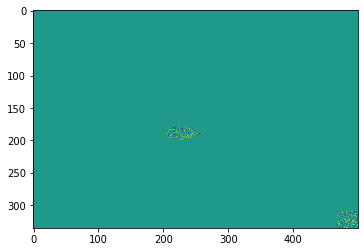

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_37864_361_361.png
check t shape
(267, 400)


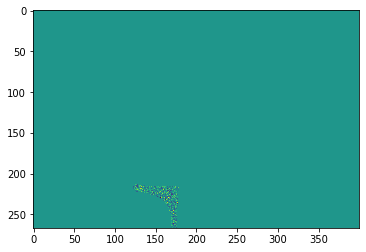

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_32230_432_432.png
check t shape
(500, 350)


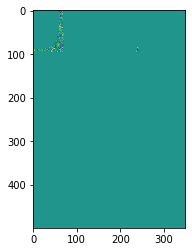

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_18118_979_979.png
check t shape
(360, 480)


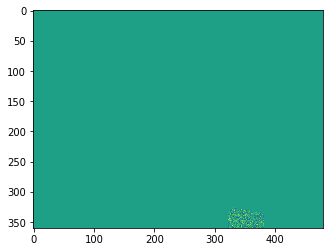

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_47246_566_566.png
check t shape
(333, 500)


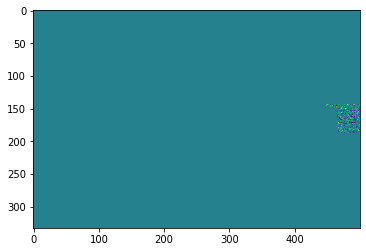

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_48123_979_979.png
check t shape
(500, 375)


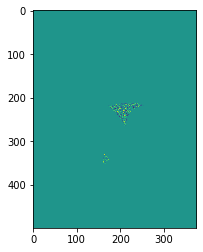

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_32629_840_840.png
check t shape
(375, 500)


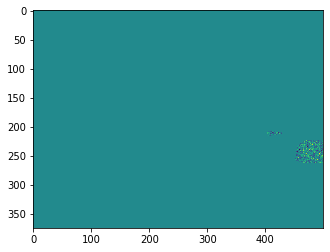

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_4813_605_605.png
check t shape
(375, 500)


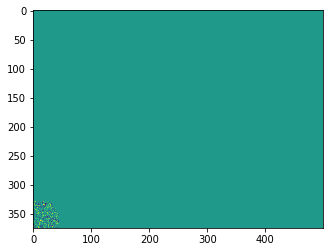

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_8733_428_428.png
check t shape
(247, 252)


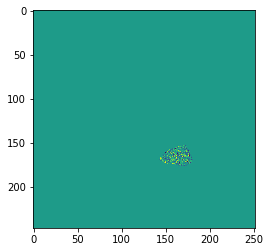

check the max index
526
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_22426_664_664.png
check t shape
(281, 500)


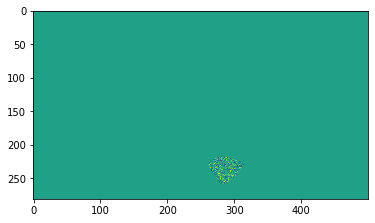

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_5892_935_935.png
check t shape
(375, 500)


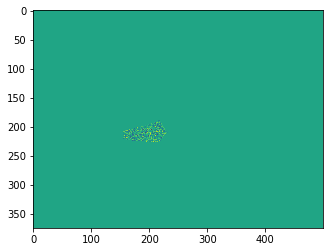

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_502_470_470.png
check t shape
(640, 480)


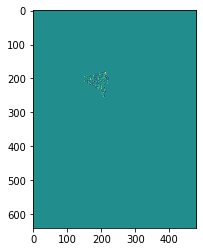

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_88_713_713.png
check t shape
(424, 476)


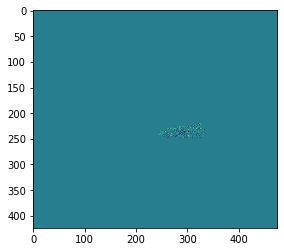

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_9853_448_448.png
check t shape
(327, 500)


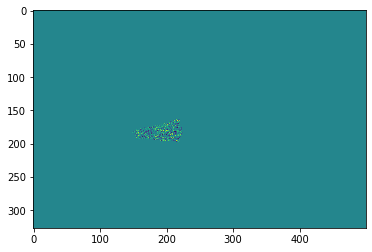

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_848_550_550.png
check t shape
(641, 454)


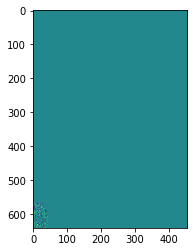

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_23165_896_896.png
check t shape
(500, 375)


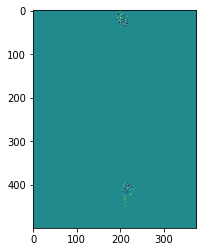

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_1625_448_448.png
check t shape
(500, 375)


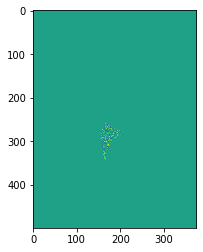

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_6088_696_696.png
check t shape
(281, 500)


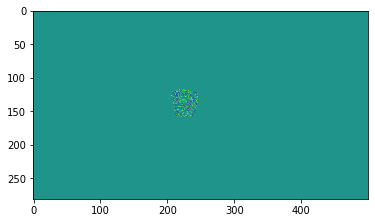

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_5549_713_713.png
check t shape
(300, 400)


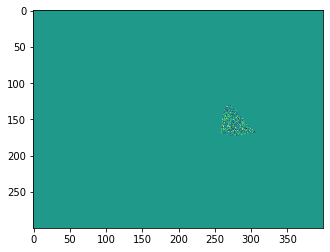

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_77881_979_979.png
check t shape
(500, 375)


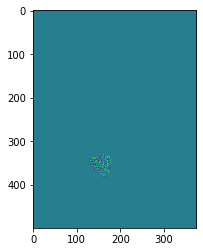

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_34971_470_470.png
check t shape
(375, 500)


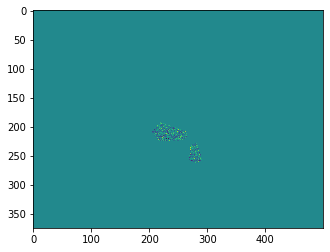

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_26760_310_310.png
check t shape
(331, 670)


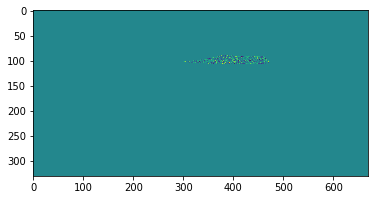

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_6384_935_935.png
check t shape
(375, 500)


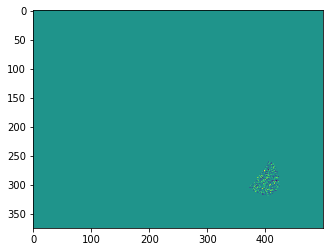

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_1695_429_429.png
check t shape
(360, 360)


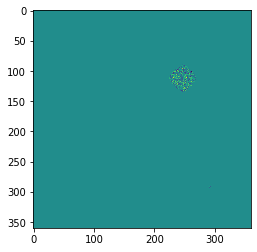

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_7432_885_885.png
check t shape
(600, 800)


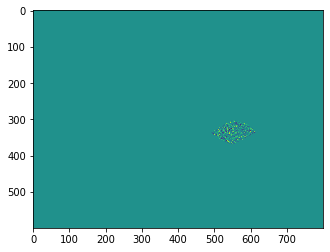

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_19411_232_232.png
check t shape
(333, 500)


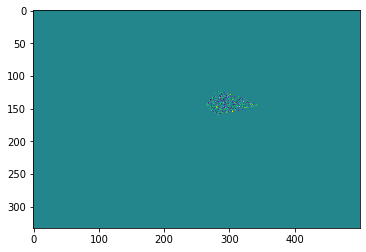

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_30274_975_975.png
check t shape
(332, 500)


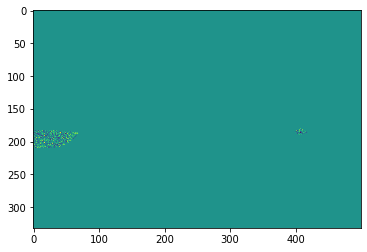

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_21688_648_648.png
check t shape
(500, 334)


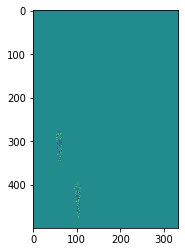

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_41241_469_469.png
check t shape
(800, 800)


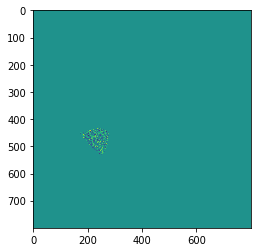

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_590_913_913.png
check t shape
(375, 500)


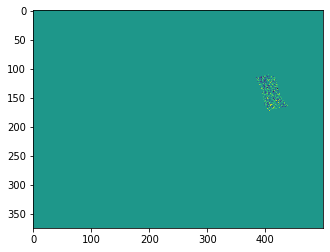

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_4857_935_935.png
check t shape
(375, 500)


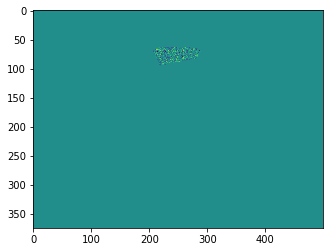

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_4170_218_218.png
check t shape
(377, 500)


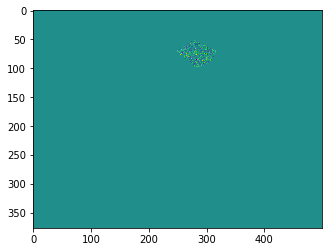

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_34188_470_470.png
check t shape
(433, 500)


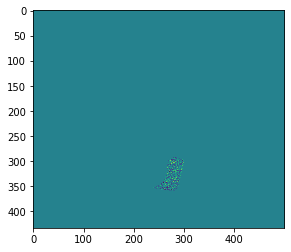

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_1302_935_935.png
check t shape
(375, 500)


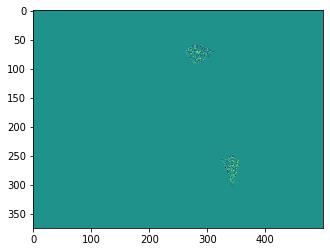

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_2070_363_363.png
check t shape
(291, 500)


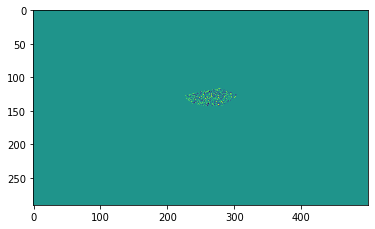

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_10003_232_232.png
check t shape
(333, 500)


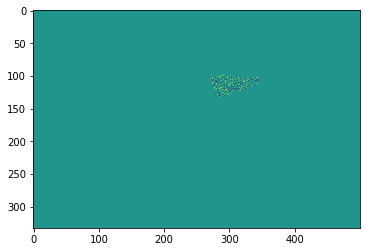

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_9856_886_886.png
check t shape
(500, 375)


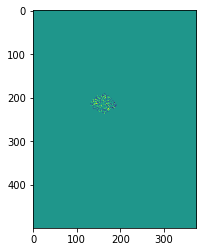

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_26579_840_840.png
check t shape
(480, 320)


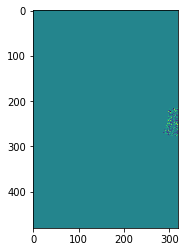

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_6375_316_316.png
check t shape
(375, 500)


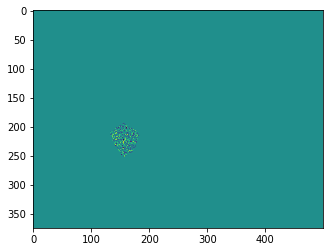

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_21495_840_840.png
check t shape
(375, 500)


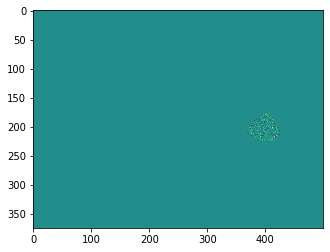

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_16960_404_404.png
check t shape
(160, 240)


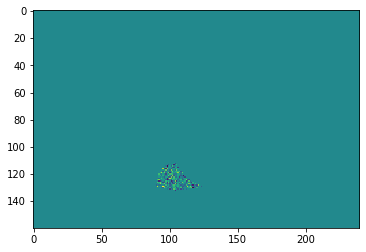

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_27074_310_310.png
check t shape
(347, 500)


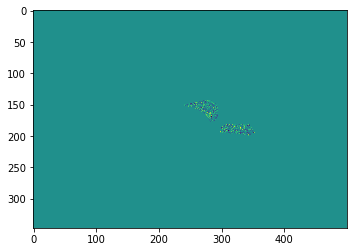

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_165_92_92.png
check t shape
(399, 500)


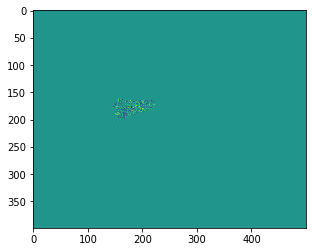

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_29870_310_310.png
check t shape
(402, 500)


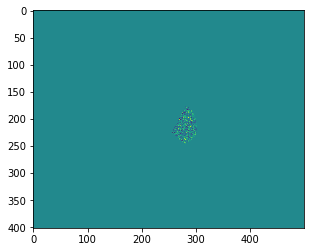

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_2279_630_630.png
check t shape
(375, 500)


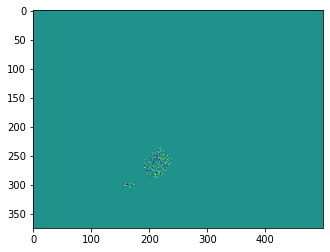

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_31618_470_470.png
check t shape
(500, 375)


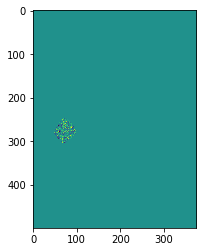

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_8770_935_935.png
check t shape
(403, 504)


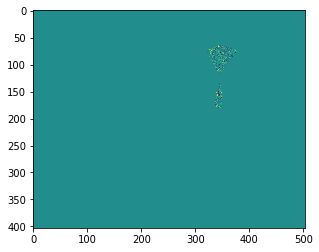

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_1787_218_218.png
check t shape
(369, 400)


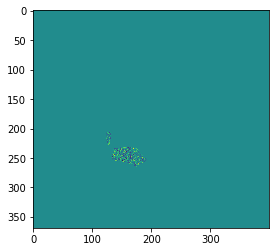

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_5351_568_568.png
check t shape
(2704, 1800)


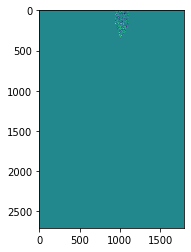

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_7248_404_404.png
check t shape
(160, 240)


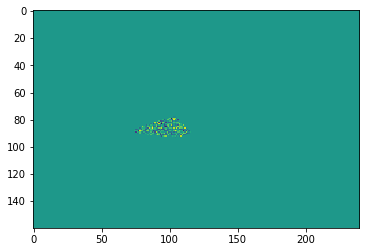

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_12945_27_27.png
check t shape
(333, 500)


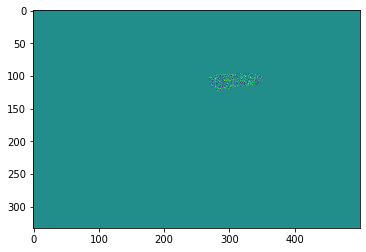

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_2880_550_550.png
check t shape
(500, 375)


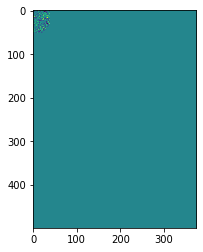

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_3389_363_363.png
check t shape
(333, 500)


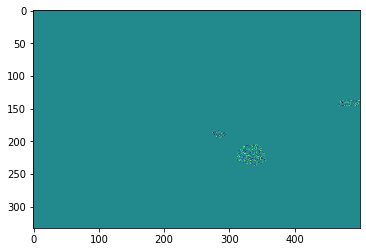

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_11466_568_568.png
check t shape
(500, 375)


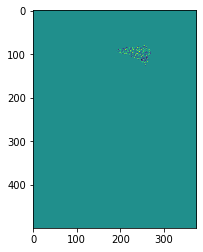

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_15892_27_27.png
check t shape
(336, 500)


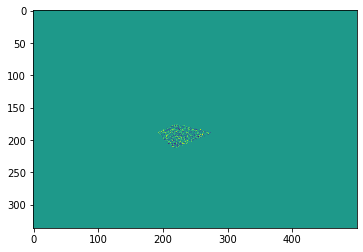

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_55008_235_235.png
check t shape
(600, 600)


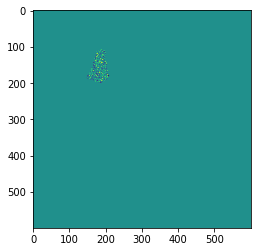

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_27898_975_975.png
check t shape
(375, 500)


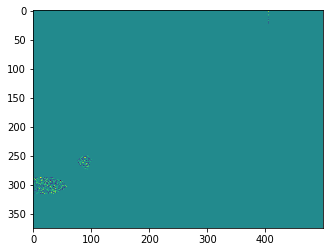

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_978_363_363.png
check t shape
(750, 1000)


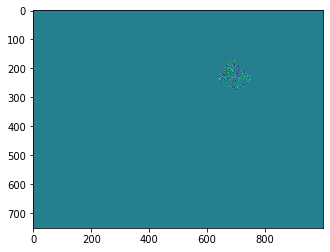

check the max index
742
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_13361_713_713.png
check t shape
(413, 695)


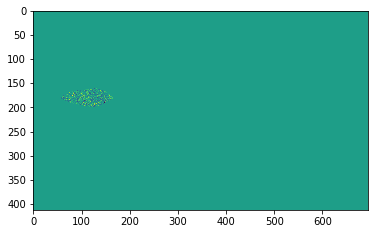

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_28142_885_885.png
check t shape
(380, 500)


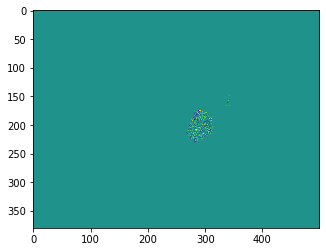

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_10620_673_673.png
check t shape
(500, 333)


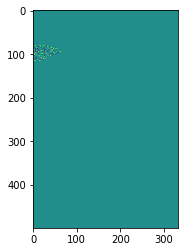

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_17449_913_913.png
check t shape
(333, 500)


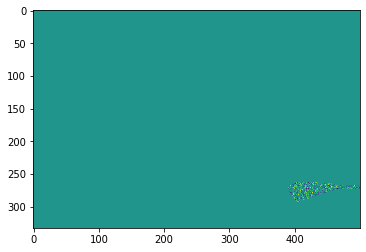

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_29063_670_670.png
check t shape
(375, 500)


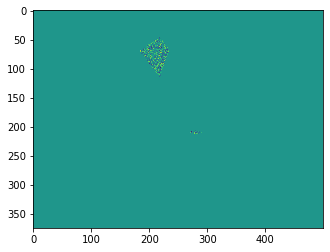

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_2843_428_428.png
check t shape
(375, 500)


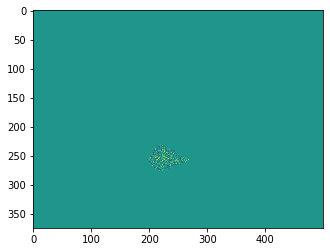

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_9676_886_886.png
check t shape
(500, 333)


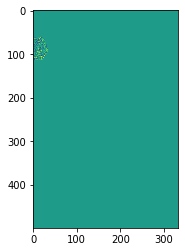

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_4839_935_935.png
check t shape
(375, 500)


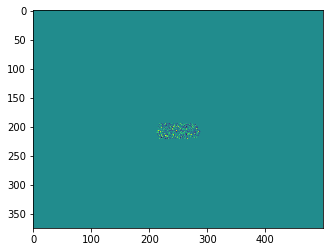

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_5828_218_218.png
check t shape
(333, 500)


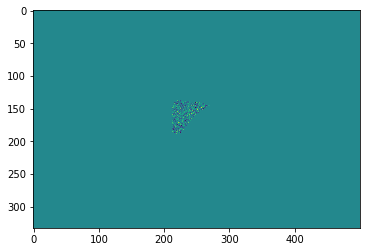

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_32827_975_975.png
check t shape
(375, 500)


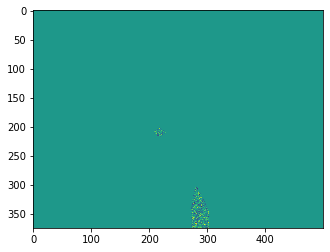

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_5401_470_470.png
check t shape
(386, 580)


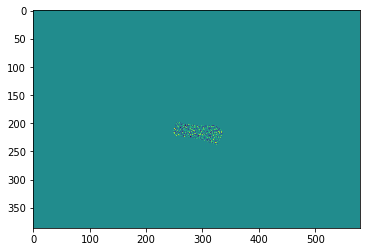

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_1198_550_550.png
check t shape
(160, 160)


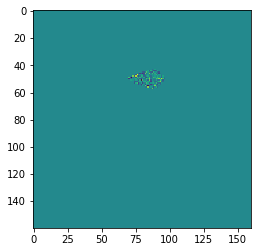

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_43590_998_998.png
check t shape
(500, 333)


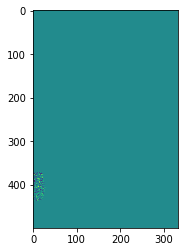

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_4482_935_935.png
check t shape
(333, 500)


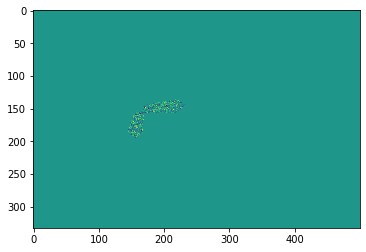

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_2588_352_352.png
check t shape
(500, 333)


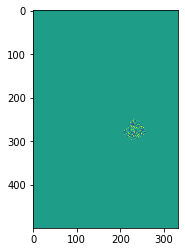

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_1769_566_566.png
check t shape
(375, 500)


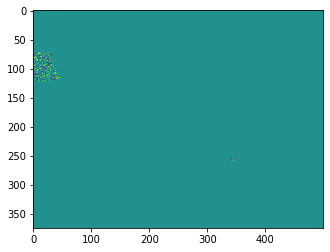

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_3785_935_935.png
check t shape
(375, 500)


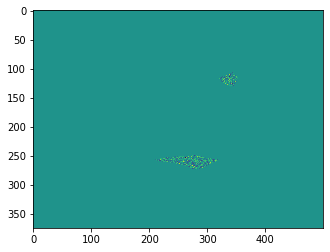

check the max index
526
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_3923_673_673.png
check t shape
(333, 500)


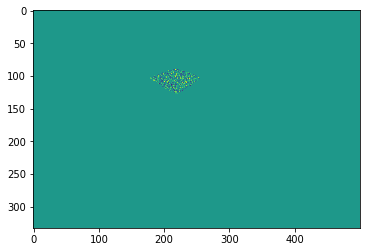

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_2121_648_648.png
check t shape
(480, 319)


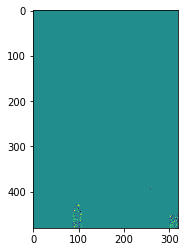

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_12667_352_352.png
check t shape
(500, 356)


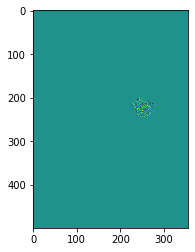

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_21539_568_568.png
check t shape
(640, 480)


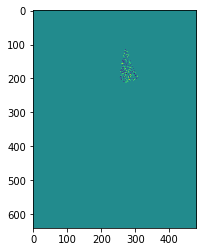

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_1304_448_448.png
check t shape
(500, 500)


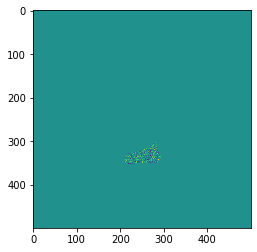

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_3186_605_605.png
check t shape
(342, 450)


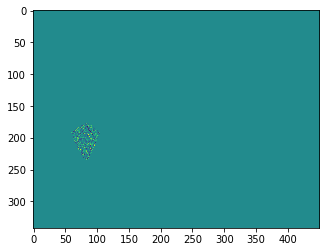

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_8574_235_235.png
check t shape
(333, 500)


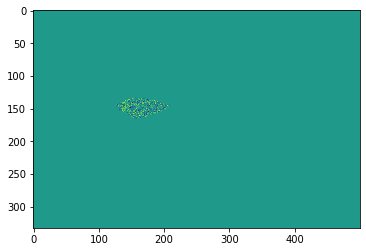

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_19732_432_432.png
check t shape
(500, 375)


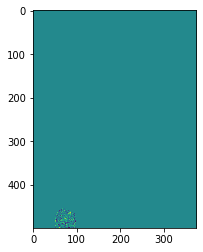

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_20999_27_27.png
check t shape
(333, 500)


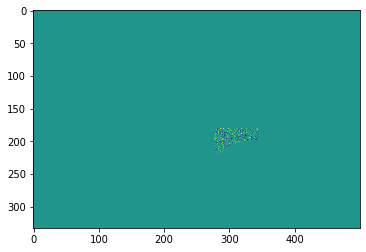

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_13140_840_840.png
check t shape
(343, 500)


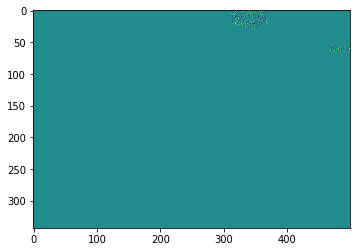

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_4188_404_404.png
check t shape
(274, 500)


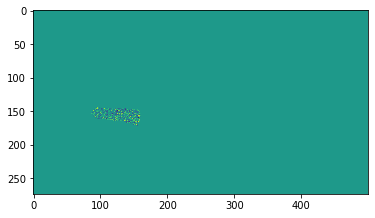

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_1158_804_804.png
check t shape
(150, 150)


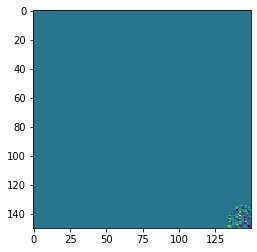

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_40409_235_235.png
check t shape
(250, 250)


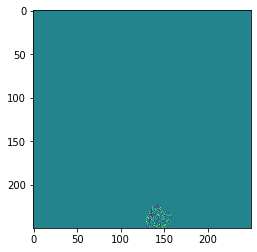

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_2937_696_696.png
check t shape
(500, 375)


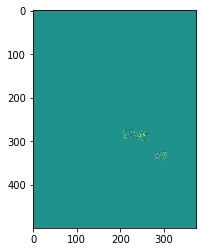

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_2025_630_630.png
check t shape
(375, 500)


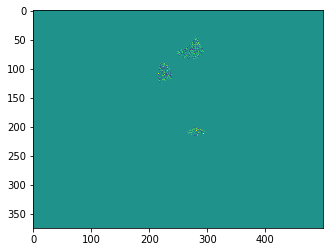

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_4535_886_886.png
check t shape
(800, 502)


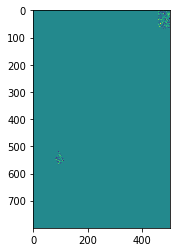

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_17035_232_232.png
check t shape
(333, 500)


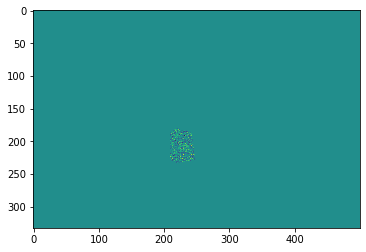

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_11087_232_232.png
check t shape
(500, 333)


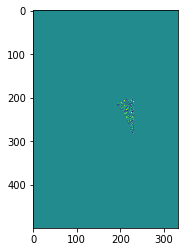

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_109_605_605.png
check t shape
(375, 500)


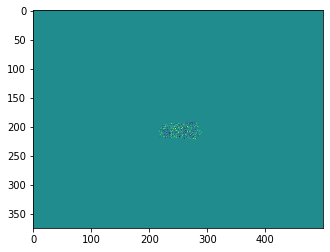

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_23538_988_988.png
check t shape
(478, 500)


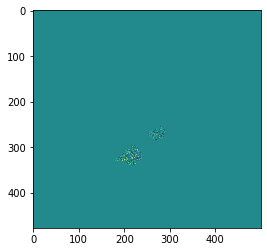

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_43940_840_840.png
check t shape
(500, 375)


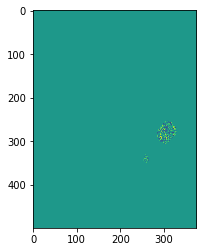

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_1741_896_896.png
check t shape
(300, 290)


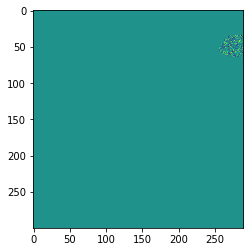

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_11484_713_713.png
check t shape
(375, 500)


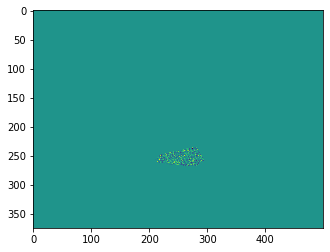

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_16024_361_361.png
check t shape
(333, 500)


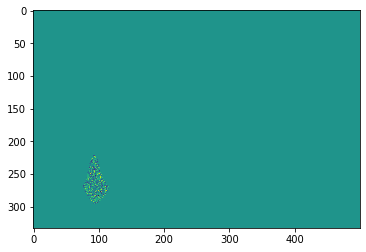

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_12636_31_31.png
check t shape
(375, 500)


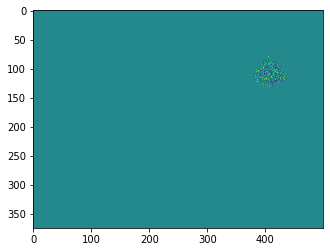

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_20188_982_982.png
check t shape
(357, 500)


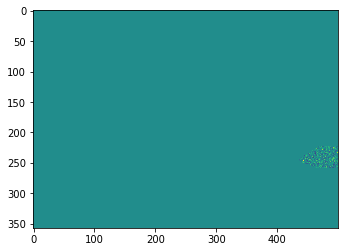

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_18731_432_432.png
check t shape
(450, 500)


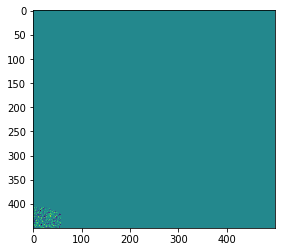

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_3140_550_550.png
check t shape
(280, 280)


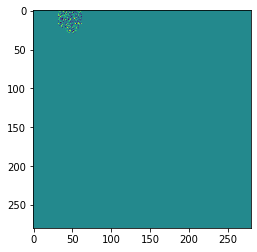

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_313_352_352.png
check t shape
(400, 275)


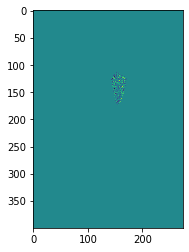

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_2238_605_605.png
check t shape
(450, 600)


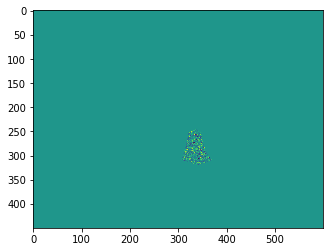

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_6323_21_21.png
check t shape
(500, 436)


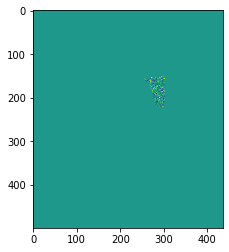

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_22130_670_670.png
check t shape
(465, 500)


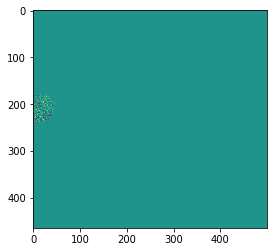

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_14380_886_886.png
check t shape
(375, 500)


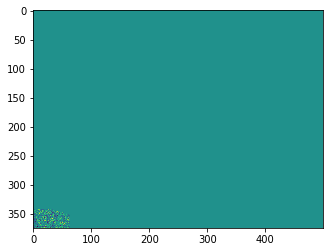

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_22716_840_840.png
check t shape
(500, 375)


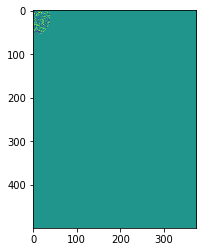

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_12439_982_982.png
check t shape
(500, 500)


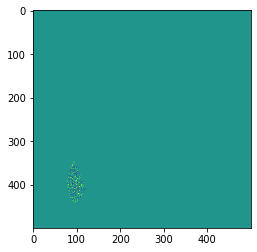

check the max index
987
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_21539_998_998.png
check t shape
(500, 364)


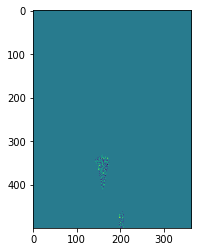

check the max index
317
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_23063_316_316.png
check t shape
(447, 640)


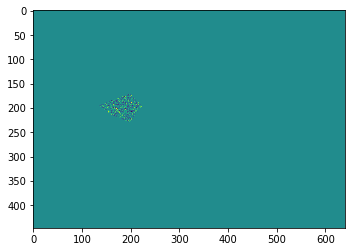

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_7544_404_404.png
check t shape
(215, 500)


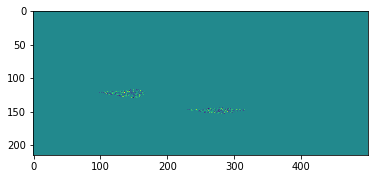

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_34163_469_469.png
check t shape
(287, 155)


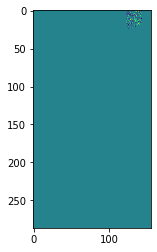

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_15016_913_913.png
check t shape
(375, 500)


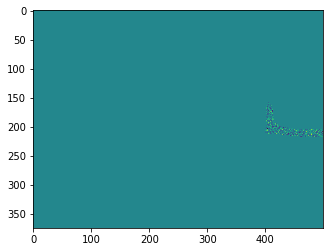

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_569_873_873.png
check t shape
(367, 500)


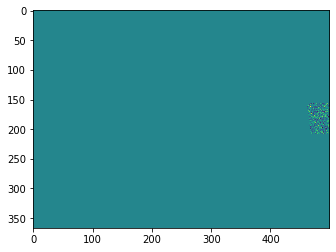

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_7993_428_428.png
check t shape
(375, 500)


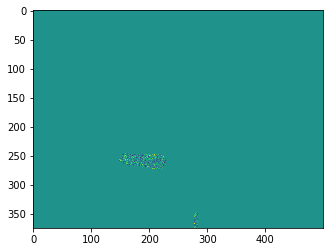

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_17606_896_896.png
check t shape
(600, 400)


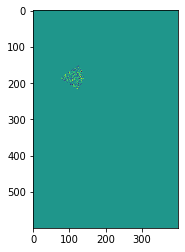

check the max index
987
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_79556_998_998.png
check t shape
(410, 300)


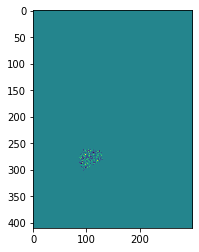

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_4260_218_218.png
check t shape
(524, 700)


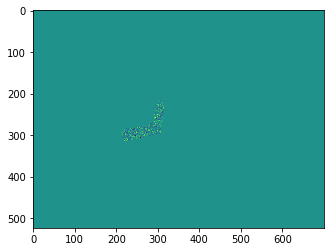

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_10368_316_316.png
check t shape
(375, 500)


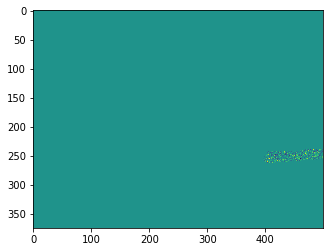

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_5718_885_885.png
check t shape
(300, 400)


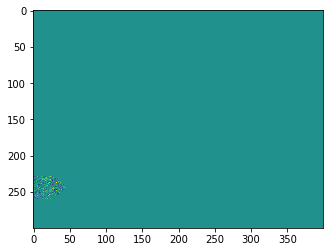

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_36000_566_566.png
check t shape
(500, 375)


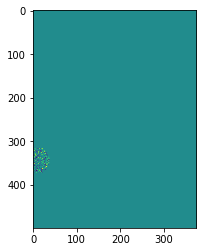

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_19162_886_886.png
check t shape
(375, 500)


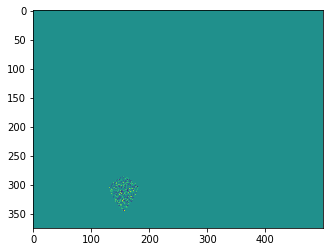

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_17630_885_885.png
check t shape
(500, 314)


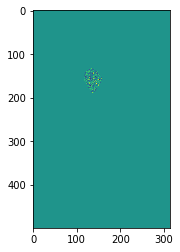

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_3509_648_648.png
check t shape
(400, 400)


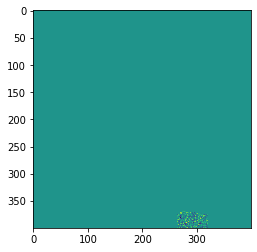

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_13488_998_998.png
check t shape
(500, 359)


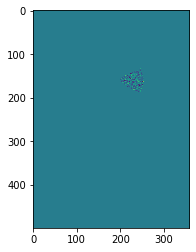

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_6311_428_428.png
check t shape
(375, 500)


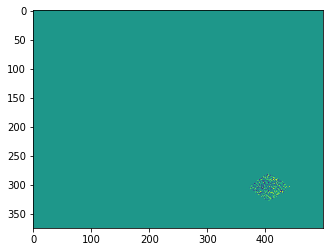

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_10622_31_31.png
check t shape
(1024, 683)


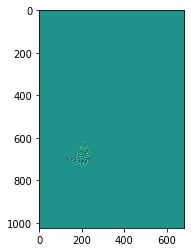

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_19865_886_886.png
check t shape
(1024, 1056)


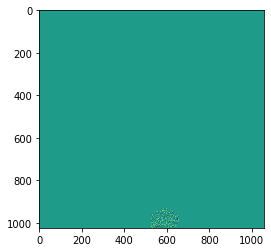

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_13801_885_885.png
check t shape
(192, 256)


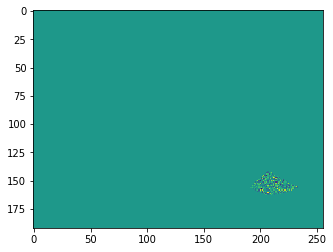

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_5632_550_550.png
check t shape
(111, 111)


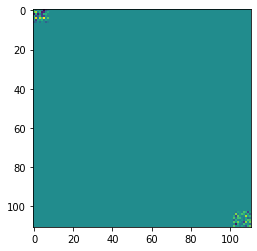

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_7872_31_31.png
check t shape
(472, 500)


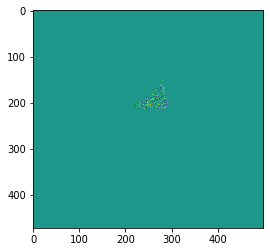

check the max index
526
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_1414_673_673.png
check t shape
(333, 500)


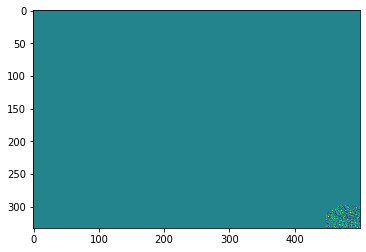

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_37968_21_21.png
check t shape
(358, 500)


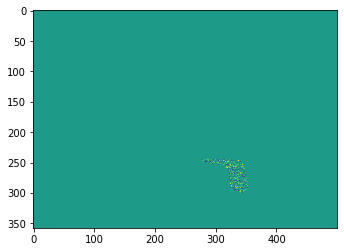

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_5486_218_218.png
check t shape
(375, 500)


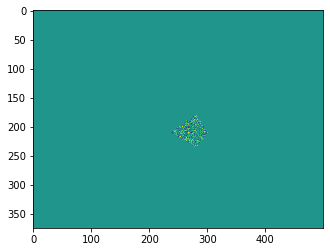

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_29111_33_33.png
check t shape
(600, 800)


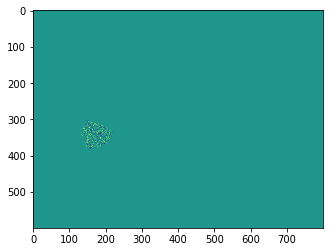

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_20717_215_215.png
check t shape
(500, 332)


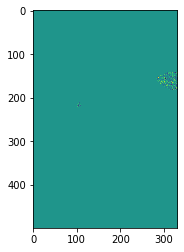

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_12569_696_696.png
check t shape
(333, 500)


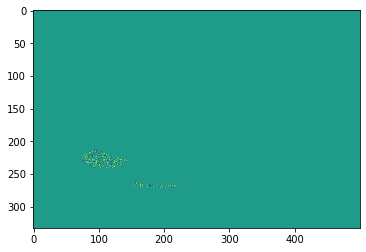

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_15908_432_432.png
check t shape
(333, 500)


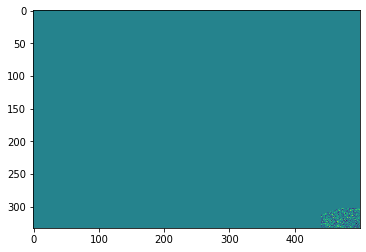

check the max index
961
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_3159_935_935.png
check t shape
(375, 500)


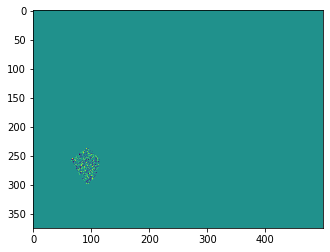

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_1037_804_804.png
check t shape
(271, 361)


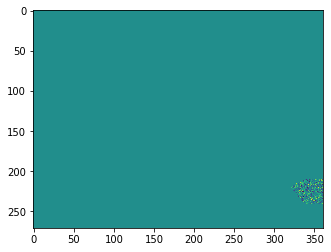

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_756_235_235.png
check t shape
(500, 391)


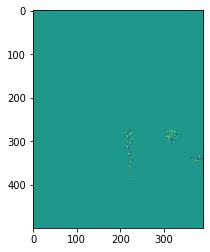

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_29595_896_896.png
check t shape
(500, 375)


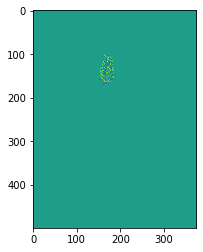

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_56384_469_469.png
check t shape
(281, 500)


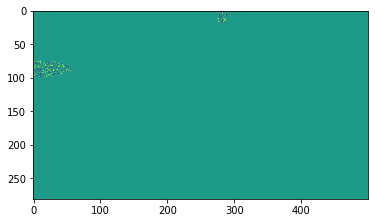

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_13472_448_448.png
check t shape
(375, 500)


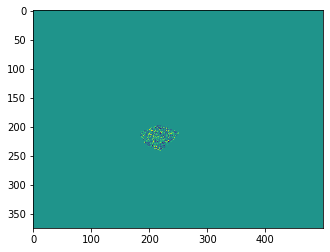

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_2847_935_935.png
check t shape
(333, 500)


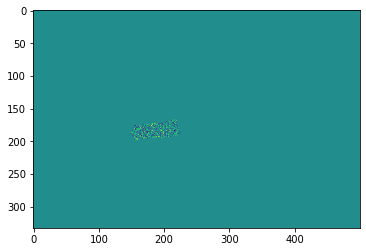

check the max index
91
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_4879_92_92.png
check t shape
(375, 500)


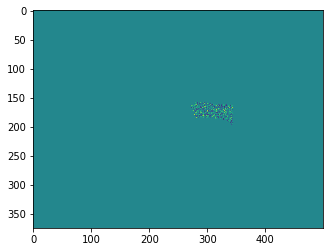

check the max index
766
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_8850_428_428.png
check t shape
(334, 500)


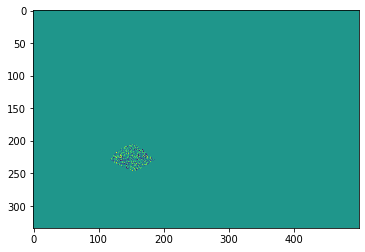

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_3821_404_404.png
check t shape
(332, 500)


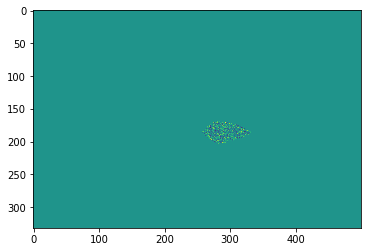

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_1845_232_232.png
check t shape
(426, 500)


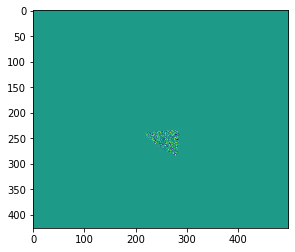

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_7949_310_310.png
check t shape
(363, 500)


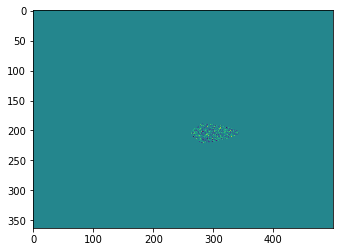

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_2864_605_605.png
check t shape
(500, 375)


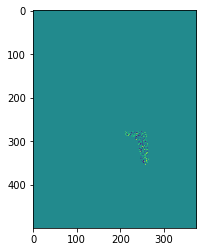

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_4208_27_27.png
check t shape
(335, 500)


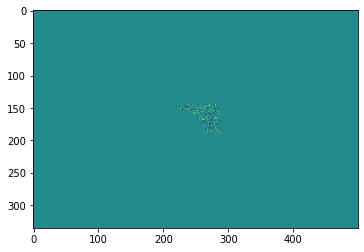

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_29469_670_670.png
check t shape
(480, 640)


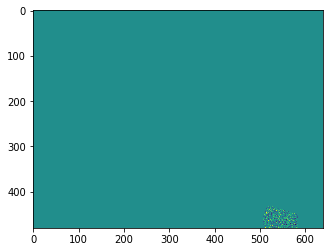

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_7193_92_92.png
check t shape
(500, 375)


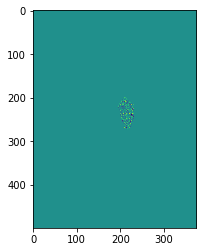

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_2572_27_27.png
check t shape
(375, 500)


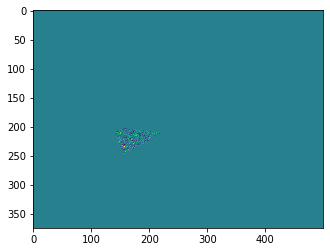

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_5418_218_218.png
check t shape
(333, 500)


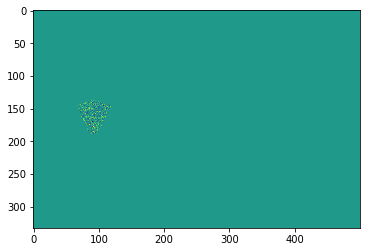

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_3190_982_982.png
check t shape
(500, 332)


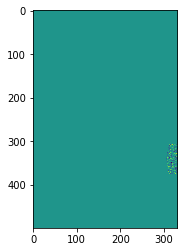

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_31635_429_429.png
check t shape
(500, 333)


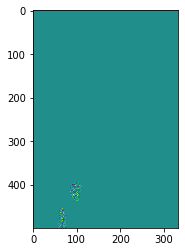

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_31357_361_361.png
check t shape
(493, 500)


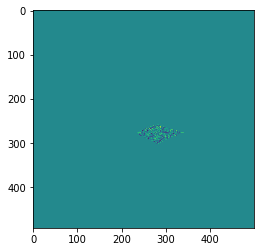

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_2362_352_352.png
check t shape
(600, 800)


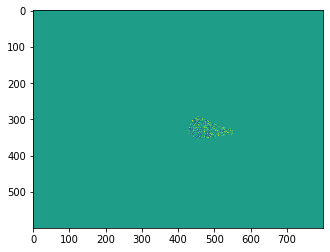

check the max index
824
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_22637_568_568.png
check t shape
(500, 333)


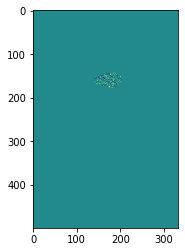

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_10508_432_432.png
check t shape
(242, 180)


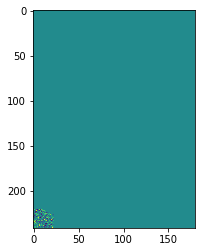

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_15739_432_432.png
check t shape
(500, 313)


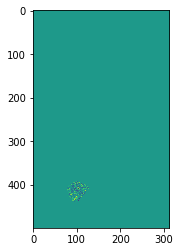

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_18621_696_696.png
check t shape
(375, 500)


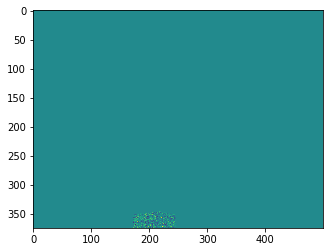

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_13665_630_630.png
check t shape
(333, 500)


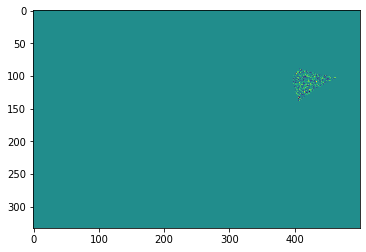

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_11846_713_713.png
check t shape
(371, 600)


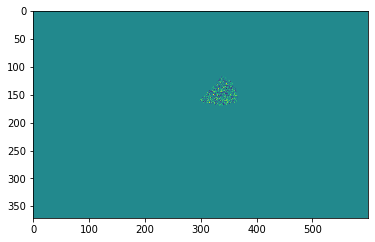

check the max index
436
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_168_581_581.png
check t shape
(375, 500)


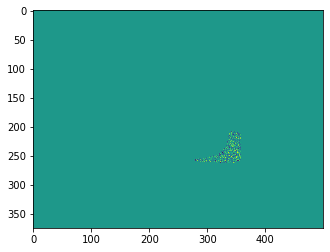

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_63429_998_998.png
check t shape
(334, 500)


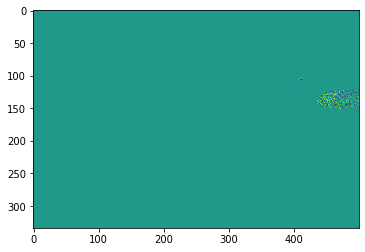

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_12_605_605.png
check t shape
(500, 375)


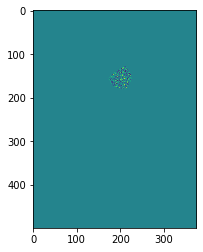

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_5643_363_363.png
check t shape
(375, 500)


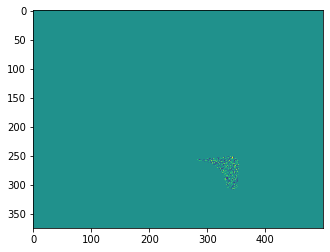

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_6304_469_469.png
check t shape
(500, 375)


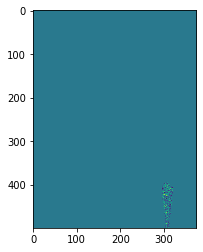

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_3803_913_913.png
check t shape
(375, 500)


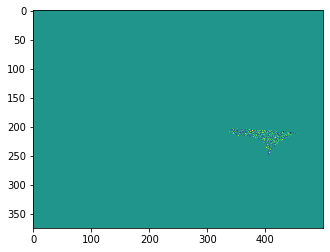

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_7366_31_31.png
check t shape
(333, 500)


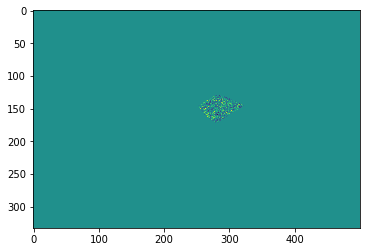

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_29758_982_982.png
check t shape
(366, 500)


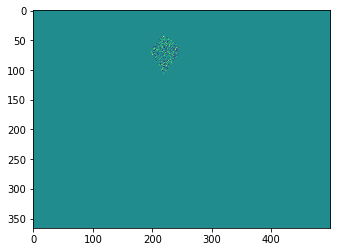

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_8529_27_27.png
check t shape
(291, 500)


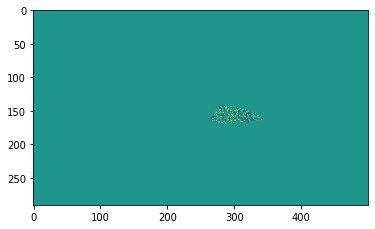

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_15135_568_568.png
check t shape
(332, 500)


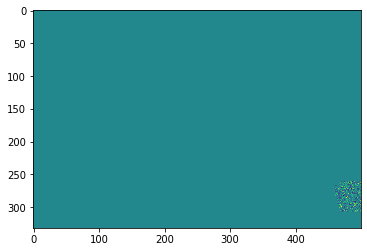

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_4843_630_630.png
check t shape
(435, 580)


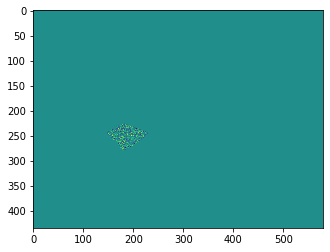

check the max index
975
975
./imagenet_fgsm/imagenet/fgsm/fgsm_n09332890_23380_975_975.png
check t shape
(375, 500)


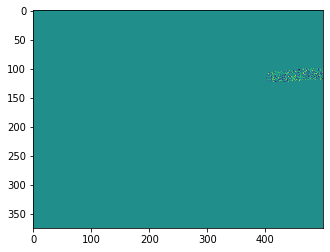

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_33736_696_696.png
check t shape
(500, 375)


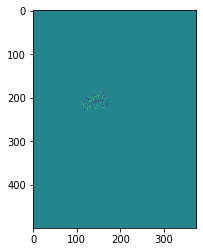

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_2183_804_804.png
check t shape
(400, 269)


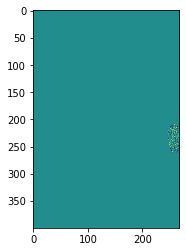

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_4153_886_886.png
check t shape
(225, 400)


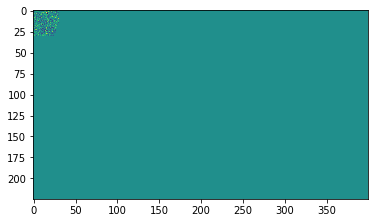

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_13126_913_913.png
check t shape
(500, 333)


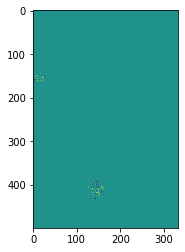

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_11321_630_630.png
check t shape
(288, 352)


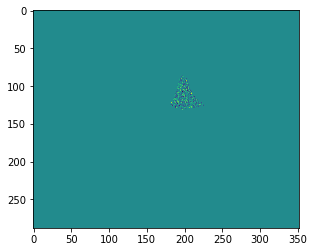

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_5195_215_215.png
check t shape
(198, 269)


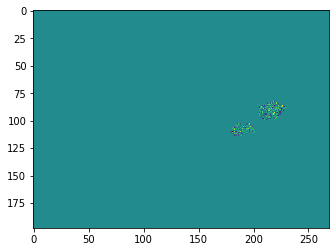

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_5635_218_218.png
check t shape
(375, 500)


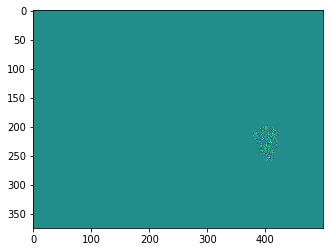

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_2388_218_218.png
check t shape
(375, 500)


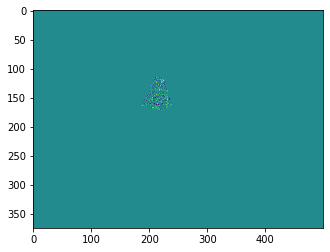

check the max index
539
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_24524_235_235.png
check t shape
(500, 375)


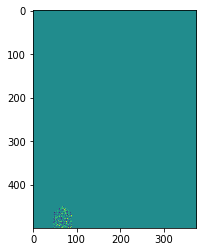

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_480_935_935.png
check t shape
(375, 500)


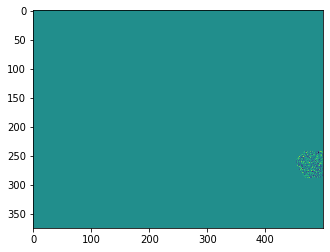

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_7237_429_429.png
check t shape
(500, 333)


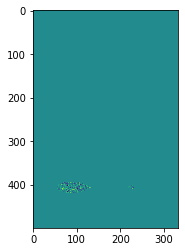

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_192_840_840.png
check t shape
(864, 1203)


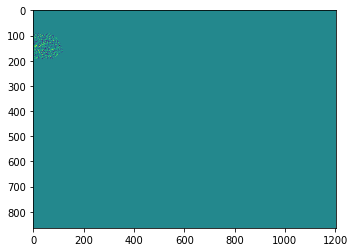

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_8558_33_33.png
check t shape
(323, 500)


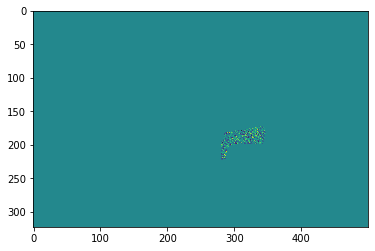

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_2094_673_673.png
check t shape
(405, 500)


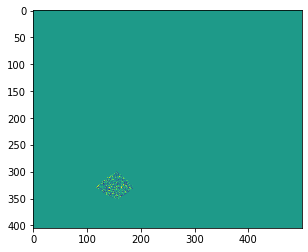

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_8692_31_31.png
check t shape
(342, 500)


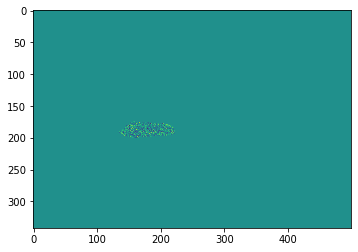

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_11307_581_581.png
check t shape
(391, 500)


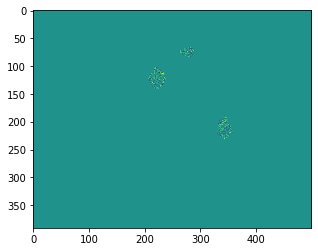

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_7694_885_885.png
check t shape
(360, 288)


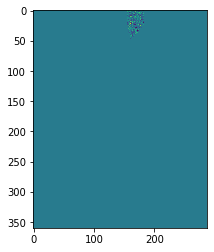

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_17293_432_432.png
check t shape
(500, 332)


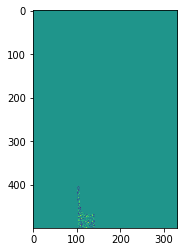

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_33246_840_840.png
check t shape
(353, 500)


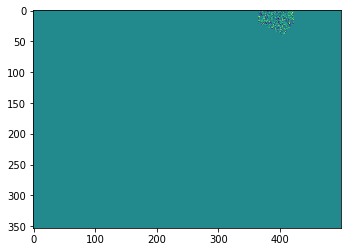

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_13918_886_886.png
check t shape
(500, 375)


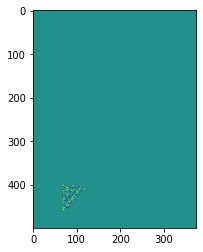

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_15062_713_713.png
check t shape
(716, 550)


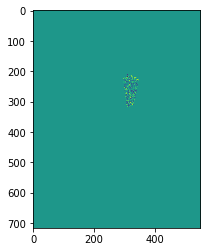

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_10203_21_21.png
check t shape
(480, 480)


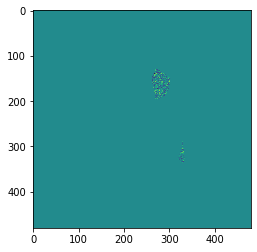

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_24106_873_873.png
check t shape
(500, 375)


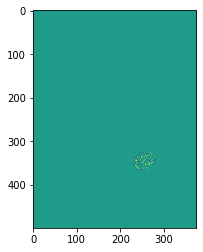

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_9604_429_429.png
check t shape
(359, 500)


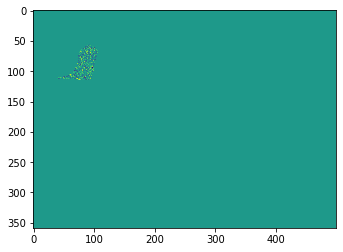

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_11476_428_428.png
check t shape
(500, 375)


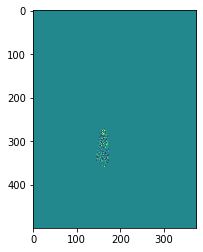

check the max index
655
638
./imagenet_fgsm/imagenet/fgsm/fgsm_n03710637_15177_638_638.png
check t shape
(550, 367)


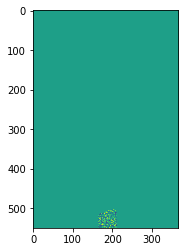

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_7291_92_92.png
check t shape
(1772, 1181)


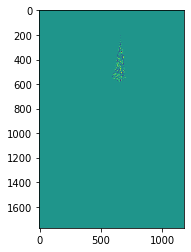

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_30683_513_513.png
check t shape
(172, 304)


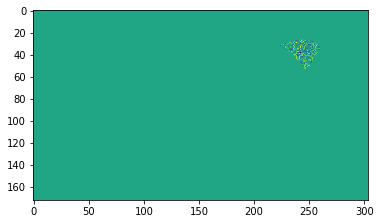

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_5597_218_218.png
check t shape
(365, 500)


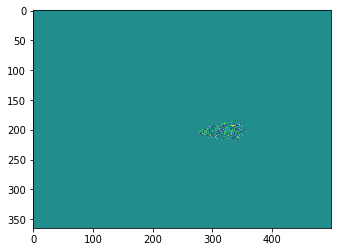

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_6172_873_873.png
check t shape
(375, 500)


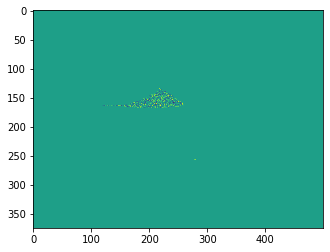

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_3524_470_470.png
check t shape
(774, 1195)


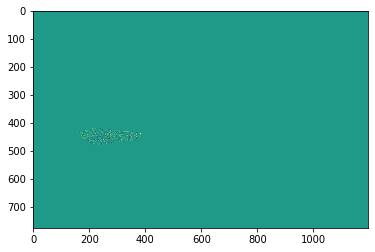

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_1111_630_630.png
check t shape
(441, 364)


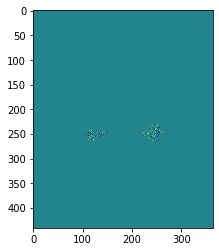

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_8371_27_27.png
check t shape
(313, 500)


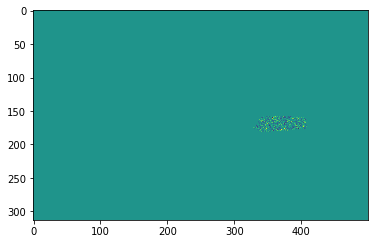

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_13270_235_235.png
check t shape
(413, 550)


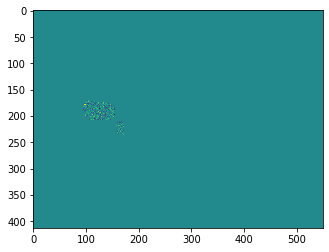

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_13056_913_913.png
check t shape
(375, 500)


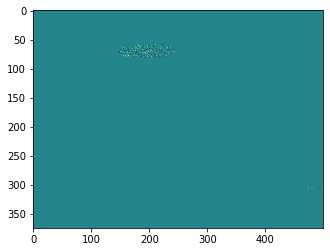

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_3049_432_432.png
check t shape
(480, 640)


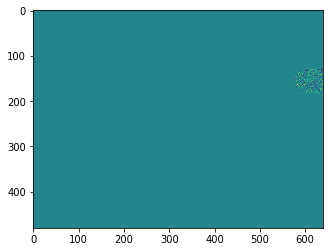

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_17064_696_696.png
check t shape
(500, 372)


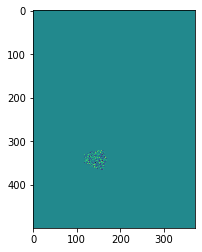

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_4335_404_404.png
check t shape
(333, 500)


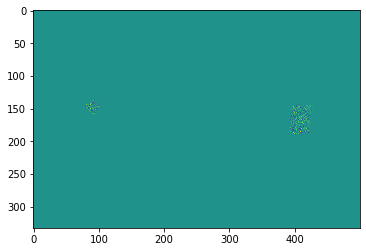

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_13804_363_363.png
check t shape
(249, 500)


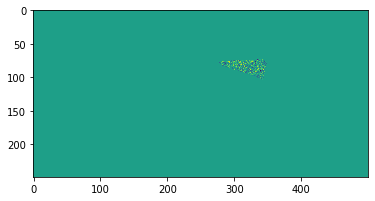

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_2540_404_404.png
check t shape
(333, 500)


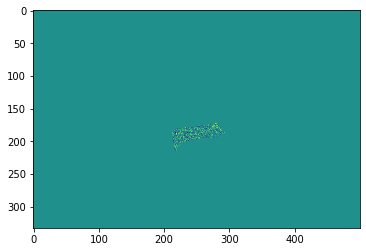

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_3994_873_873.png
check t shape
(375, 500)


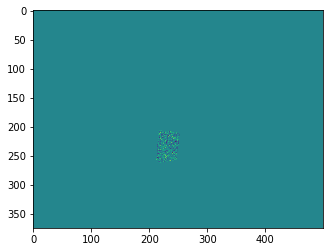

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_8439_361_361.png
check t shape
(375, 500)


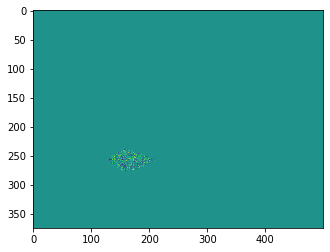

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_10511_363_363.png
check t shape
(500, 500)


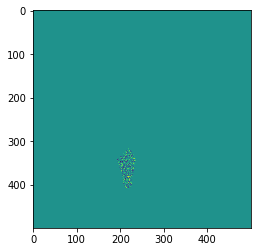

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_9423_568_568.png
check t shape
(500, 375)


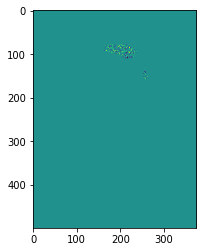

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_39171_470_470.png
check t shape
(500, 375)


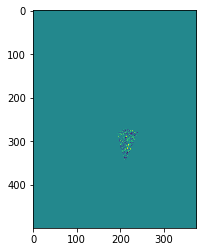

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_153_696_696.png
check t shape
(300, 300)


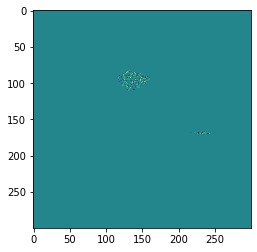

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_7650_713_713.png
check t shape
(300, 400)


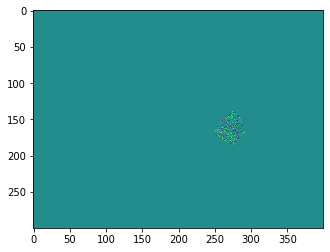

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_10081_92_92.png
check t shape
(800, 635)


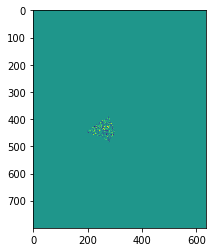

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_19190_630_630.png
check t shape
(375, 500)


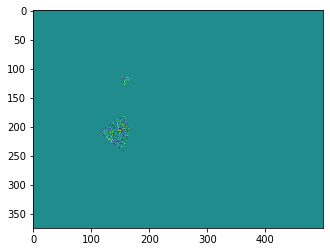

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_2113_605_605.png
check t shape
(375, 500)


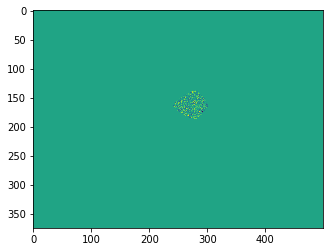

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_9506_568_568.png
check t shape
(500, 333)


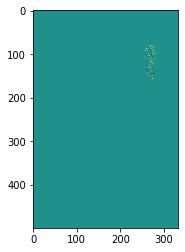

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_25191_429_429.png
check t shape
(333, 500)


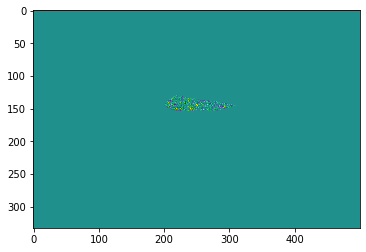

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_3977_363_363.png
check t shape
(338, 500)


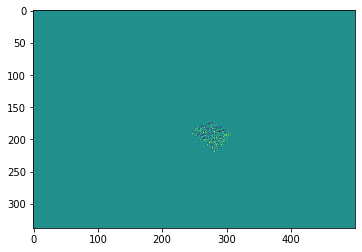

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_18202_448_448.png
check t shape
(375, 500)


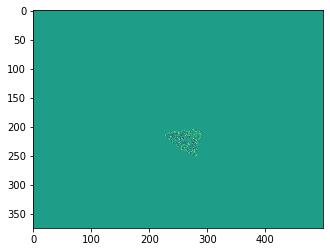

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_18772_470_470.png
check t shape
(300, 400)


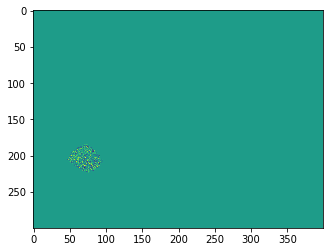

check the max index
375
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_7341_361_361.png
check t shape
(375, 500)


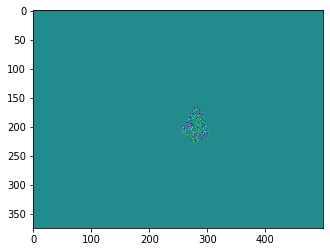

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_7464_713_713.png
check t shape
(455, 538)


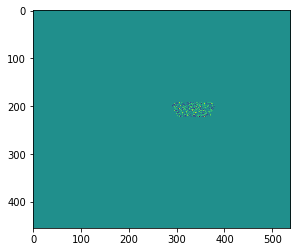

check the max index
670
670
./imagenet_fgsm/imagenet/fgsm/fgsm_n03791053_924_670_670.png
check t shape
(332, 500)


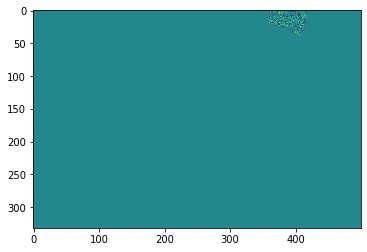

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_3638_935_935.png
check t shape
(375, 500)


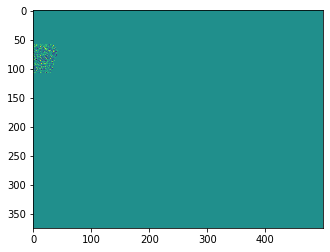

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_10217_363_363.png
check t shape
(263, 350)


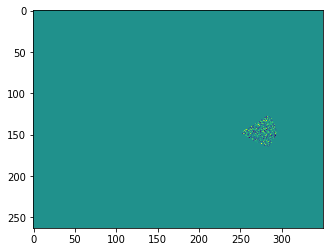

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_1187_804_804.png
check t shape
(500, 375)


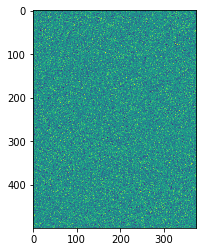

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_18759_470_470.png
check t shape
(375, 500)


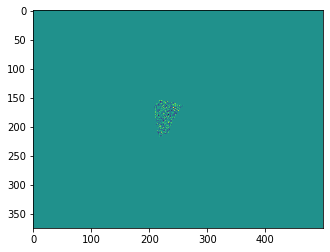

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_41692_21_21.png
check t shape
(333, 500)


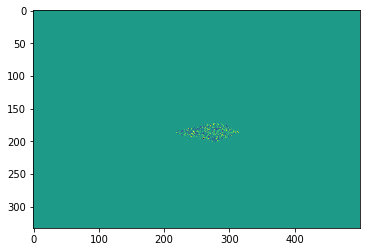

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_24181_363_363.png
check t shape
(381, 500)


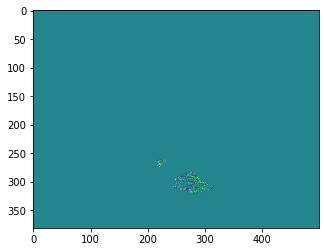

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_13669_581_581.png
check t shape
(375, 500)


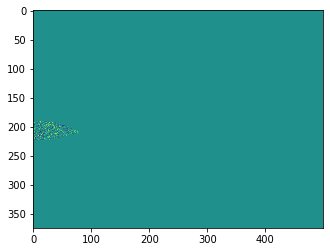

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_15707_470_470.png
check t shape
(375, 500)


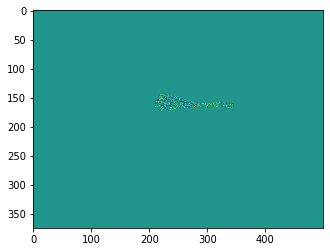

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_5083_361_361.png
check t shape
(240, 500)


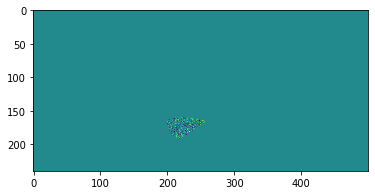

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_4329_432_432.png
check t shape
(374, 500)


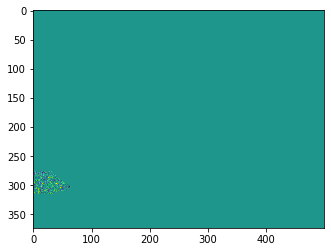

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_2824_92_92.png
check t shape
(500, 333)


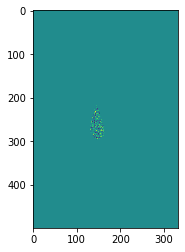

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_7887_581_581.png
check t shape
(375, 500)


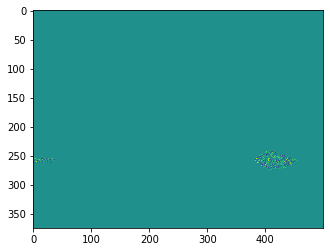

check the max index
581
581
./imagenet_fgsm/imagenet/fgsm/fgsm_n03459775_12761_581_581.png
check t shape
(375, 500)


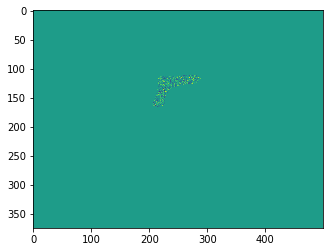

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_28864_310_310.png
check t shape
(453, 500)


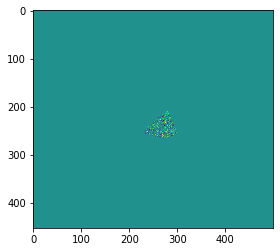

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_773_896_896.png
check t shape
(375, 500)


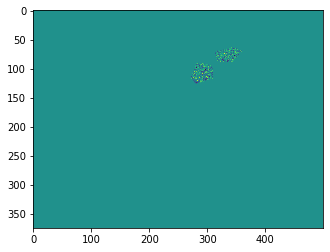

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_10770_352_352.png
check t shape
(333, 500)


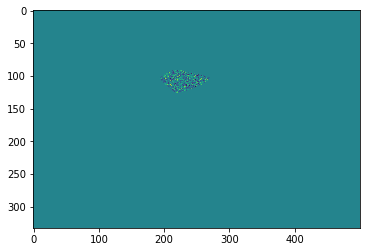

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_29251_513_513.png
check t shape
(371, 400)


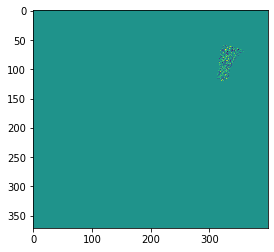

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_7649_448_448.png
check t shape
(375, 500)


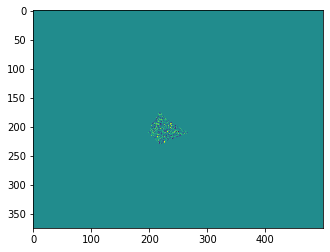

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_9816_92_92.png
check t shape
(375, 500)


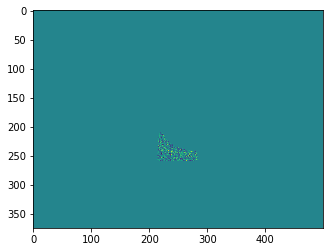

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_4163_630_630.png
check t shape
(500, 375)


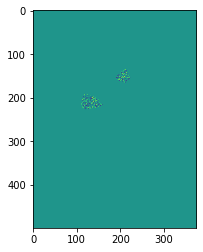

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_5761_27_27.png
check t shape
(363, 530)


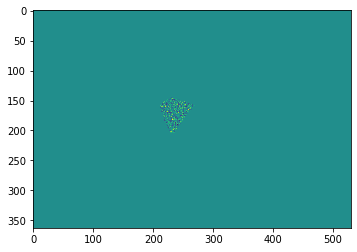

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_5732_428_428.png
check t shape
(375, 500)


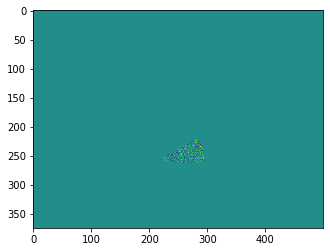

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_12262_429_429.png
check t shape
(500, 375)


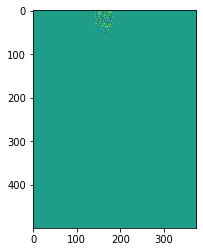

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_13927_630_630.png
check t shape
(358, 500)


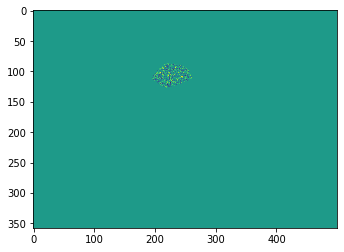

check the max index
605
605
./imagenet_fgsm/imagenet/fgsm/fgsm_n03584254_433_605_605.png
check t shape
(400, 532)


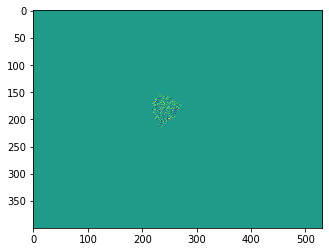

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_15940_470_470.png
check t shape
(334, 500)


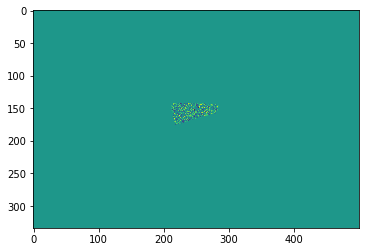

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_19362_363_363.png
check t shape
(375, 500)


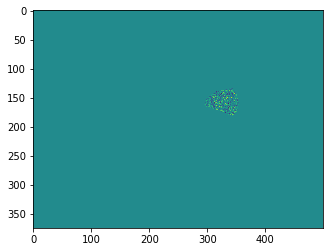

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_17544_998_998.png
check t shape
(332, 500)


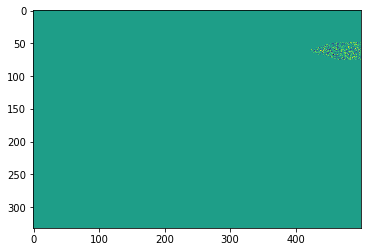

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_32705_896_896.png
check t shape
(252, 300)


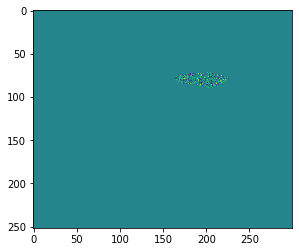

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_1918_232_232.png
check t shape
(192, 500)


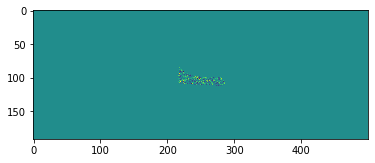

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_19294_988_988.png
check t shape
(333, 500)


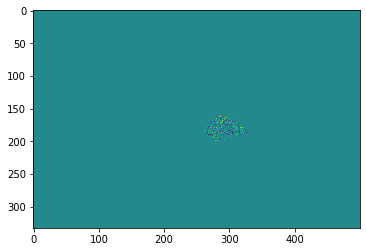

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_10793_27_27.png
check t shape
(333, 500)


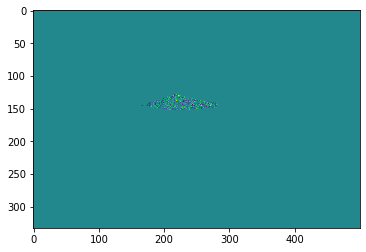

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_33581_432_432.png
check t shape
(375, 500)


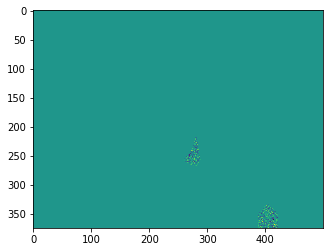

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_1302_33_33.png
check t shape
(375, 500)


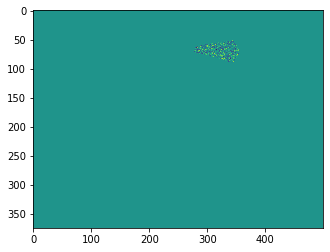

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_3930_886_886.png
check t shape
(623, 706)


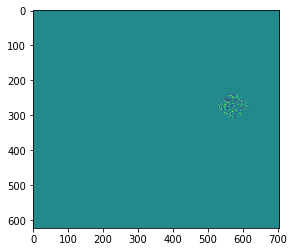

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_12294_361_361.png
check t shape
(500, 375)


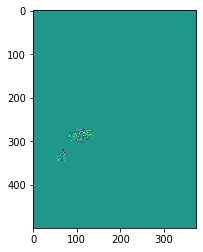

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_14144_361_361.png
check t shape
(500, 333)


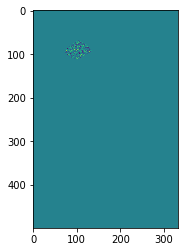

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_17694_404_404.png
check t shape
(332, 500)


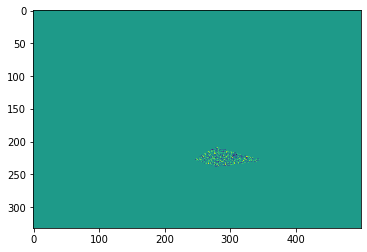

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_327_27_27.png
check t shape
(531, 800)


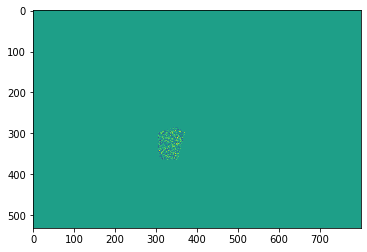

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_5584_363_363.png
check t shape
(308, 541)


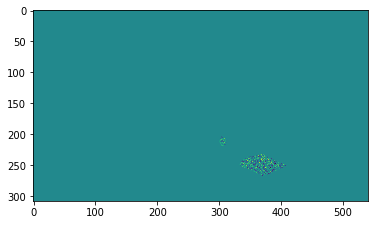

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_3017_804_804.png
check t shape
(500, 333)


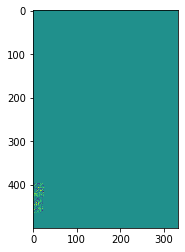

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_15706_361_361.png
check t shape
(378, 560)


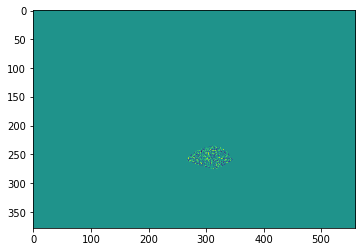

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_37447_896_896.png
check t shape
(500, 375)


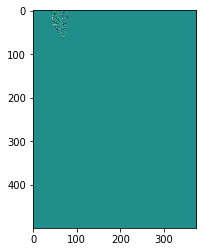

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_3722_873_873.png
check t shape
(375, 500)


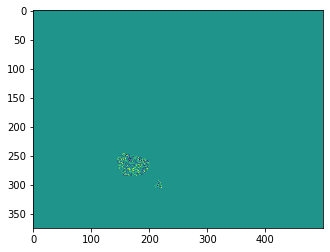

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_74139_513_513.png
check t shape
(375, 500)


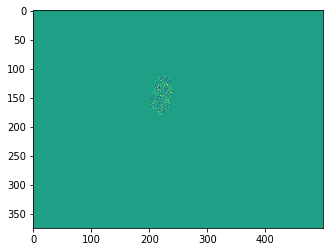

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_12047_713_713.png
check t shape
(334, 500)


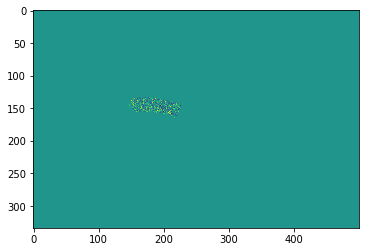

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_10229_873_873.png
check t shape
(375, 500)


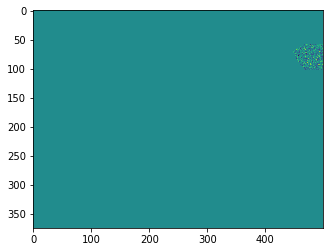

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_2590_630_630.png
check t shape
(82, 130)


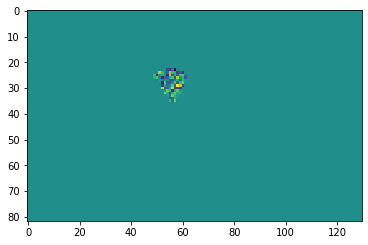

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_21597_310_310.png
check t shape
(375, 500)


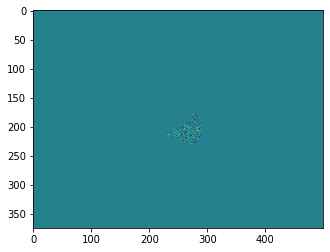

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_30072_566_566.png
check t shape
(333, 500)


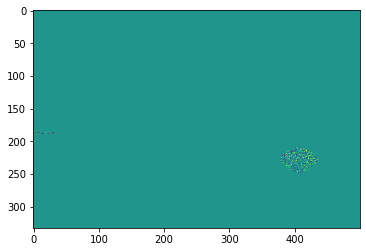

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_7879_27_27.png
check t shape
(375, 500)


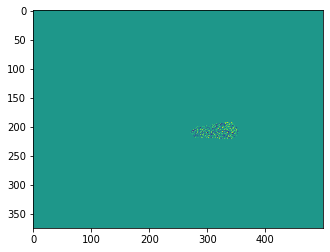

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_18056_361_361.png
check t shape
(373, 500)


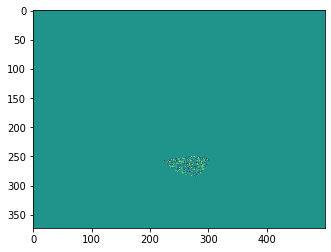

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_2762_550_550.png
check t shape
(200, 177)


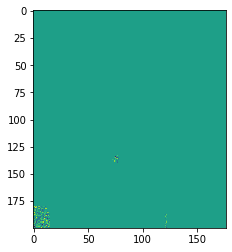

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_7523_935_935.png
check t shape
(333, 500)


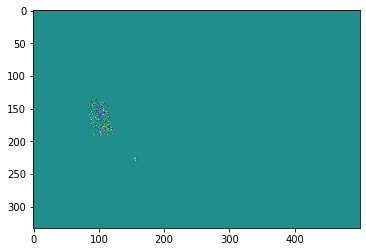

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_2692_92_92.png
check t shape
(349, 500)


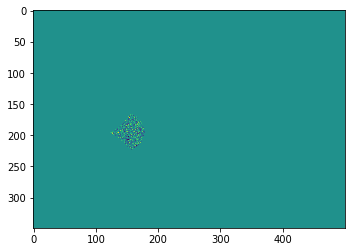

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_7399_913_913.png
check t shape
(375, 500)


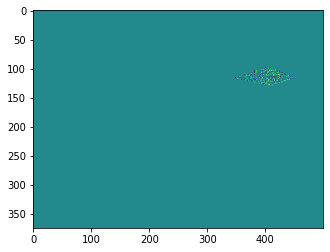

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_914_804_804.png
check t shape
(292, 292)


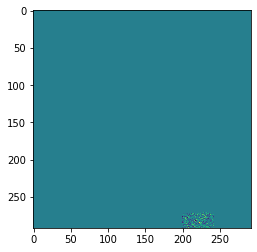

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_1459_363_363.png
check t shape
(248, 360)


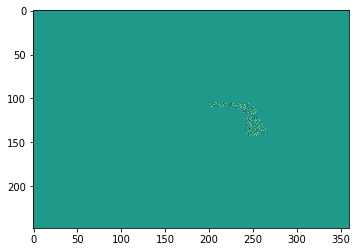

check the max index
27
27
./imagenet_fgsm/imagenet/fgsm/fgsm_n01631663_2387_27_27.png
check t shape
(166, 265)


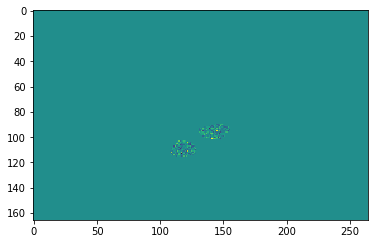

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_15028_982_982.png
check t shape
(333, 500)


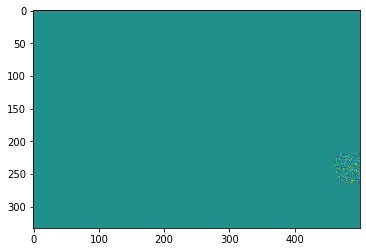

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_6770_429_429.png
check t shape
(500, 396)


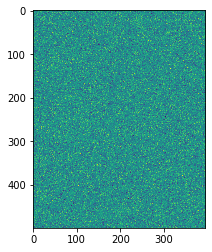

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_24831_630_630.png
check t shape
(500, 333)


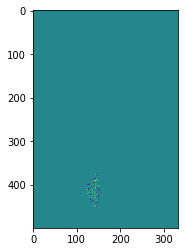

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_696_935_935.png
check t shape
(375, 500)


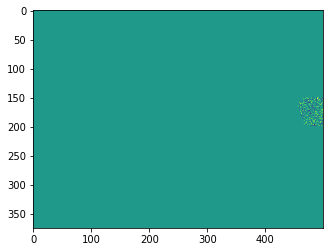

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_5690_429_429.png
check t shape
(500, 408)


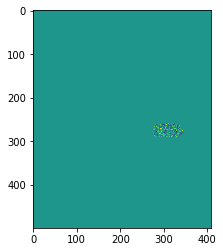

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_18356_630_630.png
check t shape
(500, 375)


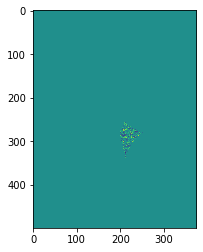

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_43368_840_840.png
check t shape
(506, 570)


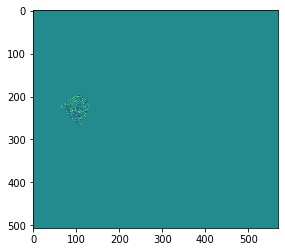

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_19698_979_979.png
check t shape
(480, 640)


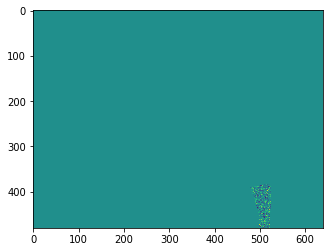

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_18628_432_432.png
check t shape
(332, 500)


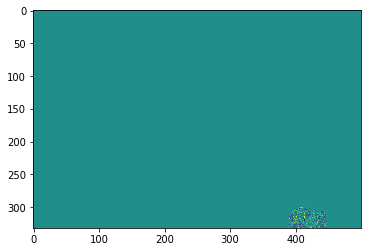

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_14840_886_886.png
check t shape
(500, 375)


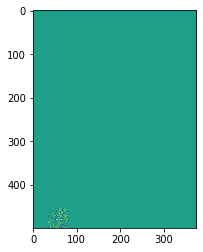

check the max index
638
638
./imagenet_fgsm/imagenet/fgsm/fgsm_n03710637_8872_638_638.png
check t shape
(500, 323)


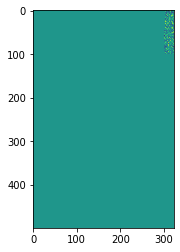

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_22496_648_648.png
check t shape
(1024, 759)


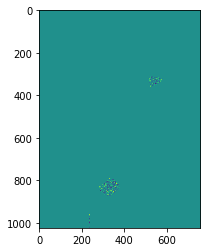

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_4233_404_404.png
check t shape
(375, 500)


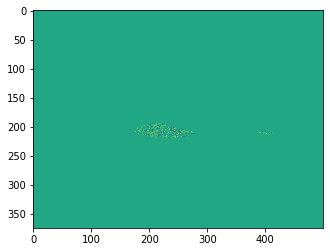

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_6125_218_218.png
check t shape
(500, 333)


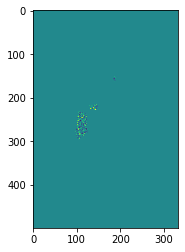

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_2843_664_664.png
check t shape
(332, 400)


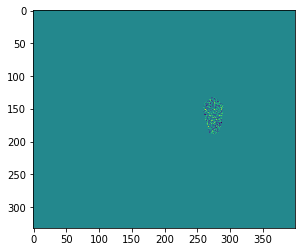

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_17339_979_979.png
check t shape
(1024, 1544)


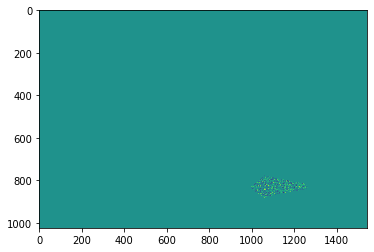

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_20785_568_568.png
check t shape
(500, 375)


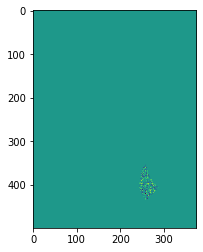

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_2000_988_988.png
check t shape
(500, 376)


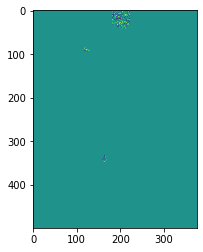

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_11959_840_840.png
check t shape
(332, 500)


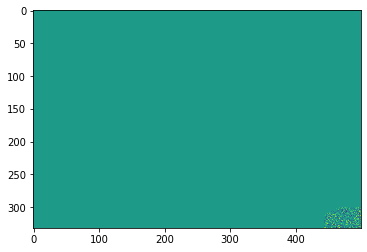

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_31326_429_429.png
check t shape
(333, 500)


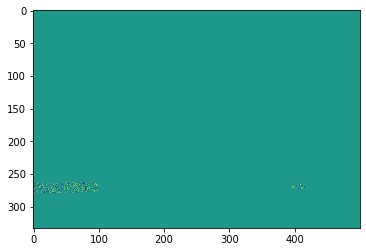

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_5419_352_352.png
check t shape
(161, 544)


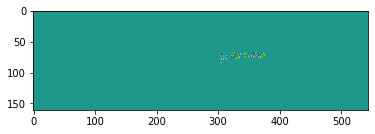

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_11614_215_215.png
check t shape
(500, 500)


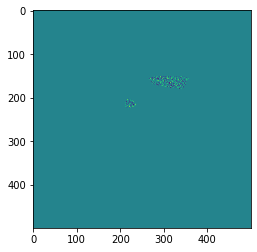

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_18232_232_232.png
check t shape
(333, 500)


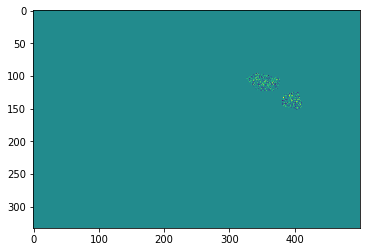

check the max index
648
648
./imagenet_fgsm/imagenet/fgsm/fgsm_n03742115_15976_648_648.png
check t shape
(500, 375)


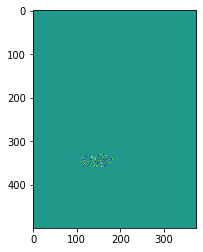

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_5255_696_696.png
check t shape
(375, 500)


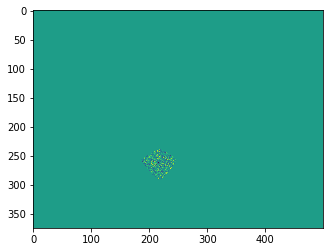

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_6601_804_804.png
check t shape
(500, 357)


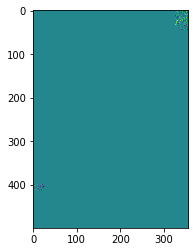

check the max index
987
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_26355_998_998.png
check t shape
(375, 500)


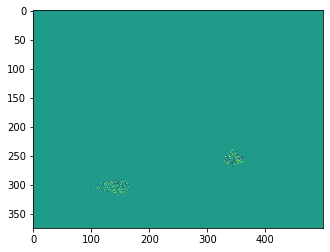

check the max index
923
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_4888_935_935.png
check t shape
(333, 500)


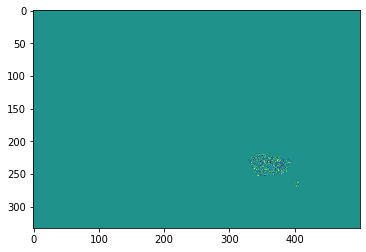

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_4289_886_886.png
check t shape
(563, 750)


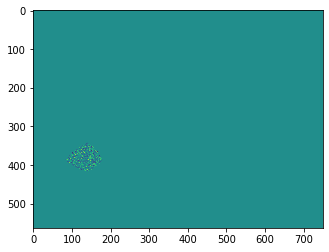

check the max index
21
21
./imagenet_fgsm/imagenet/fgsm/fgsm_n01608432_37769_21_21.png
check t shape
(333, 500)


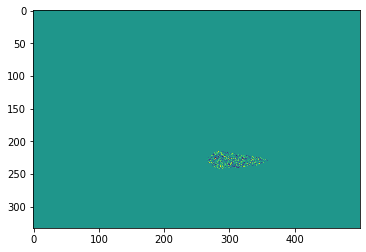

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_11813_363_363.png
check t shape
(327, 500)


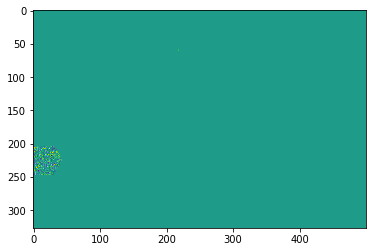

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_14869_235_235.png
check t shape
(375, 500)


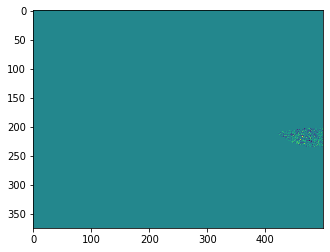

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_3960_804_804.png
check t shape
(250, 250)


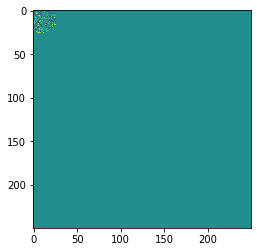

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_5233_696_696.png
check t shape
(500, 357)


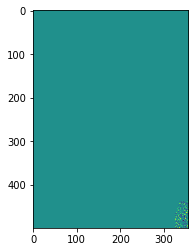

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_26457_352_352.png
check t shape
(333, 500)


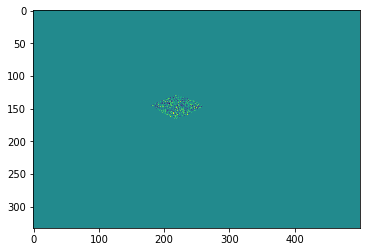

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_8253_935_935.png
check t shape
(375, 500)


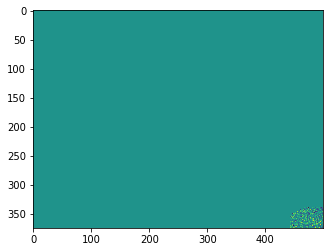

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_13883_429_429.png
check t shape
(375, 500)


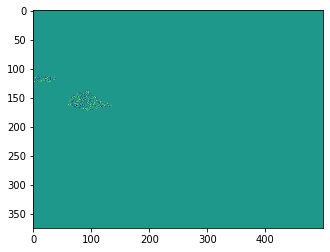

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_9006_92_92.png
check t shape
(336, 500)


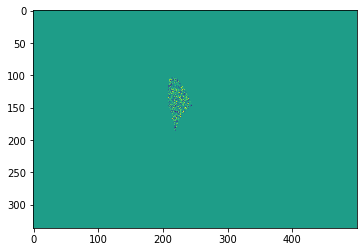

check the max index
840
840
./imagenet_fgsm/imagenet/fgsm/fgsm_n04367480_25982_840_840.png
check t shape
(375, 500)


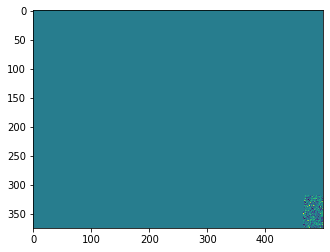

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_2134_470_470.png
check t shape
(500, 466)


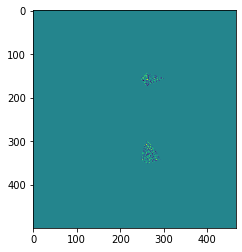

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_25901_310_310.png
check t shape
(330, 500)


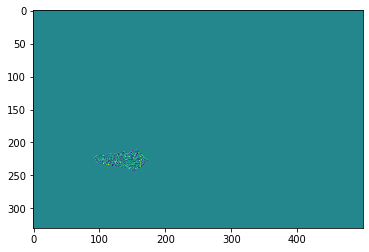

check the max index
664
664
./imagenet_fgsm/imagenet/fgsm/fgsm_n03782006_17741_664_664.png
check t shape
(375, 500)


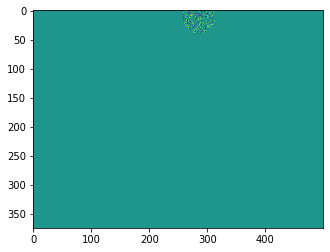

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_1624_469_469.png
check t shape
(333, 500)


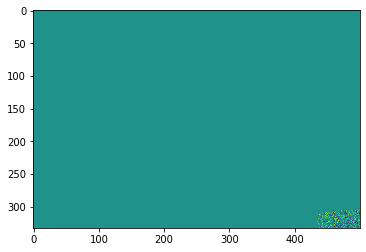

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_7257_935_935.png
check t shape
(375, 500)


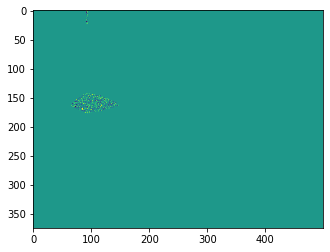

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_9286_513_513.png
check t shape
(450, 600)


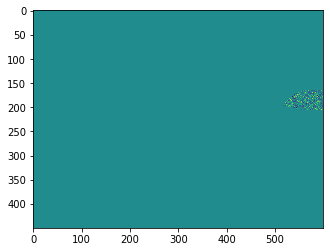

check the max index
713
713
./imagenet_fgsm/imagenet/fgsm/fgsm_n03924679_17552_713_713.png
check t shape
(480, 495)


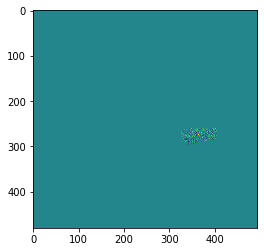

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_65320_513_513.png
check t shape
(375, 500)


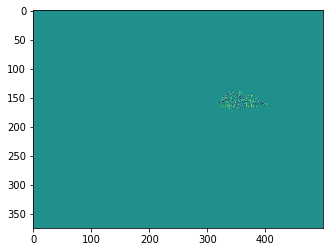

check the max index
33
33
./imagenet_fgsm/imagenet/fgsm/fgsm_n01664065_13827_33_33.png
check t shape
(800, 639)


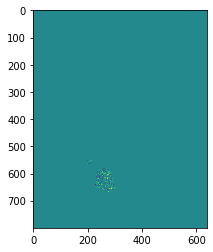

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_8476_550_550.png
check t shape
(375, 500)


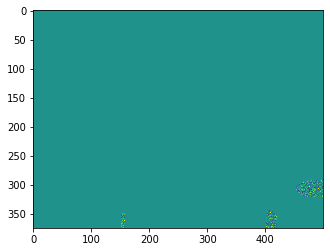

check the max index
997
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_29218_310_310.png
check t shape
(375, 500)


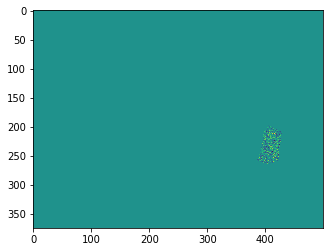

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_446_988_988.png
check t shape
(375, 500)


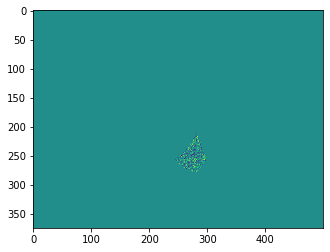

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_11880_363_363.png
check t shape
(375, 500)


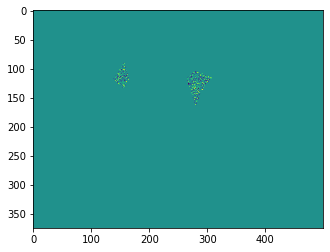

check the max index
448
448
./imagenet_fgsm/imagenet/fgsm/fgsm_n02843684_10220_448_448.png
check t shape
(500, 333)


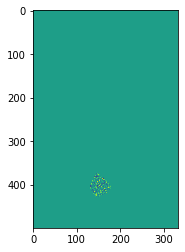

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_3355_804_804.png
check t shape
(375, 500)


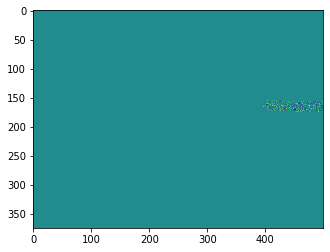

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_12055_92_92.png
check t shape
(334, 500)


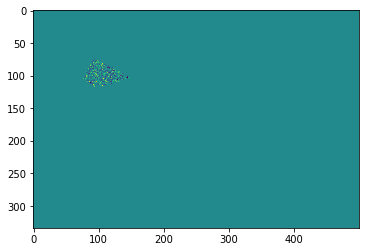

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_11552_513_513.png
check t shape
(876, 1168)


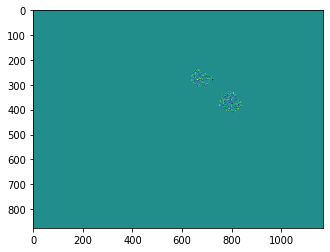

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_36360_988_988.png
check t shape
(573, 500)


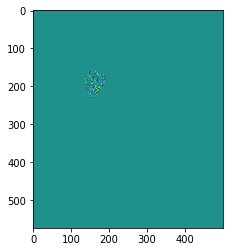

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_6192_873_873.png
check t shape
(333, 500)


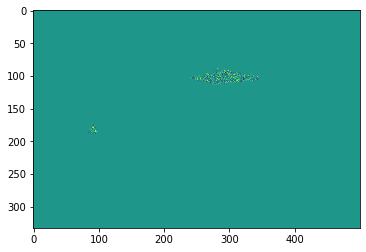

check the max index
232
232
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106166_3563_232_232.png
check t shape
(534, 800)


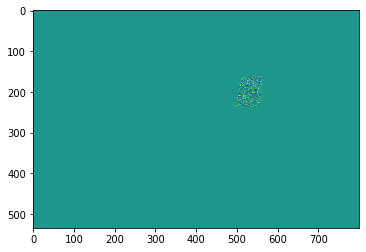

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_3861_316_316.png
check t shape
(375, 500)


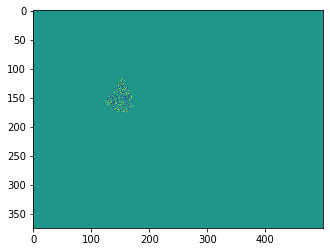

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_52790_998_998.png
check t shape
(2592, 1944)


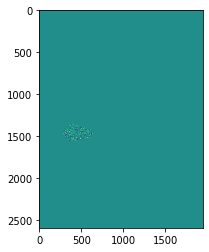

check the max index
428
428
./imagenet_fgsm/imagenet/fgsm/fgsm_n02797295_1665_428_428.png
check t shape
(375, 500)


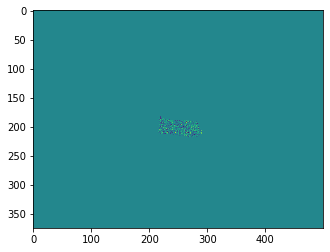

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_99_873_873.png
check t shape
(375, 500)


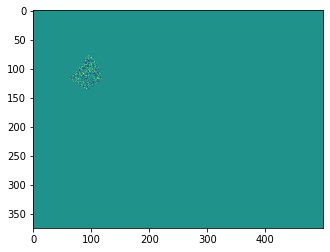

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_26792_310_310.png
check t shape
(500, 468)


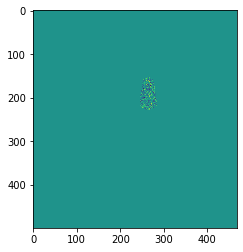

check the max index
630
630
./imagenet_fgsm/imagenet/fgsm/fgsm_n03680355_9672_630_630.png
check t shape
(375, 500)


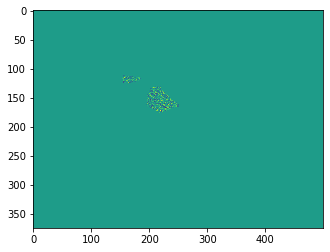

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_471_363_363.png
check t shape
(725, 483)


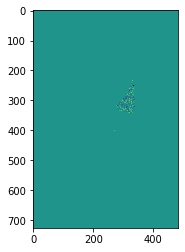

check the max index
566
566
./imagenet_fgsm/imagenet/fgsm/fgsm_n03394916_44819_566_566.png
check t shape
(333, 500)


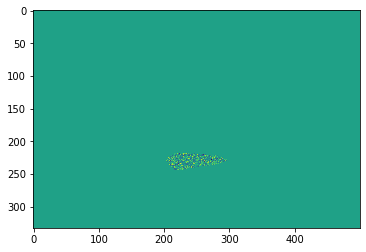

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_1395_363_363.png
check t shape
(375, 500)


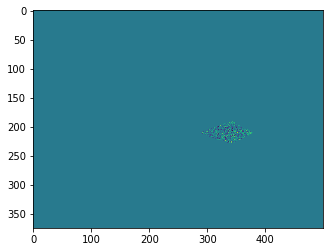

check the max index
875
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_62969_513_513.png
check t shape
(500, 335)


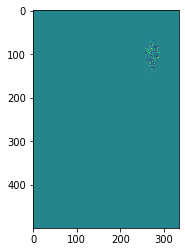

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_10827_982_982.png
check t shape
(500, 500)


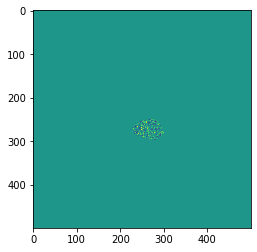

check the max index
469
469
./imagenet_fgsm/imagenet/fgsm/fgsm_n02939185_12868_469_469.png
check t shape
(600, 524)


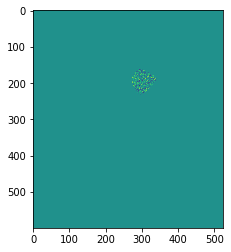

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_1558_935_935.png
check t shape
(500, 333)


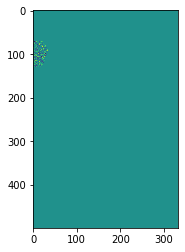

check the max index
235
235
./imagenet_fgsm/imagenet/fgsm/fgsm_n02106662_34458_235_235.png
check t shape
(500, 333)


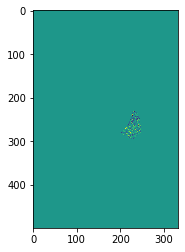

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_4936_935_935.png
check t shape
(375, 500)


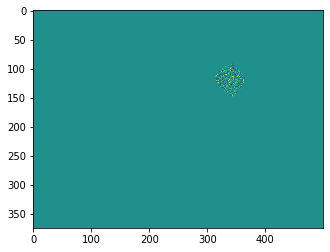

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_7427_470_470.png
check t shape
(1024, 847)


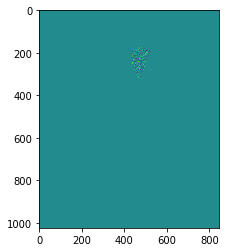

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_8118_673_673.png
check t shape
(333, 500)


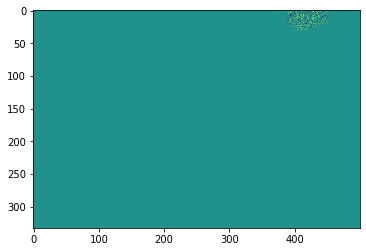

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_8387_896_896.png
check t shape
(500, 498)


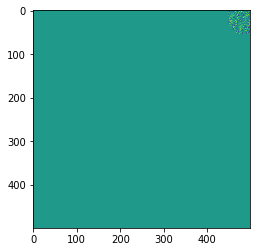

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_16012_352_352.png
check t shape
(354, 500)


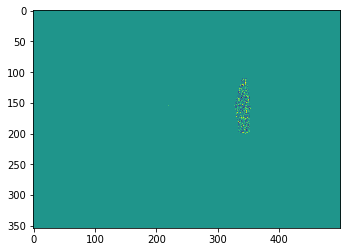

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_7334_31_31.png
check t shape
(336, 500)


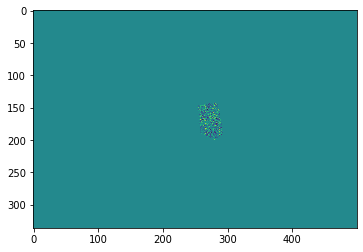

check the max index
896
896
./imagenet_fgsm/imagenet/fgsm/fgsm_n04553703_46769_896_896.png
check t shape
(567, 756)


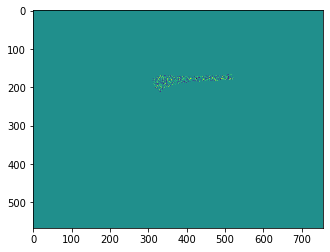

check the max index
824
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_8603_885_885.png
check t shape
(300, 300)


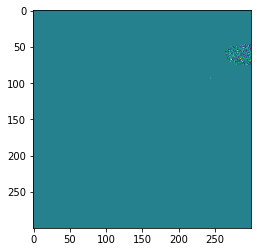

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_48813_513_513.png
check t shape
(656, 1200)


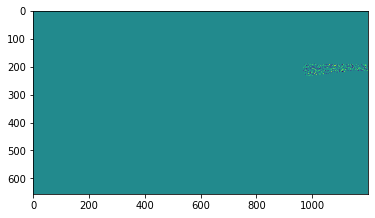

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_25261_310_310.png
check t shape
(374, 500)


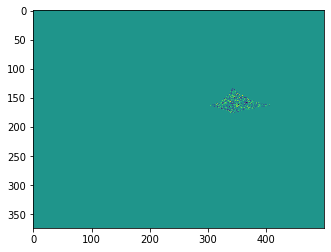

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_17898_513_513.png
check t shape
(395, 632)


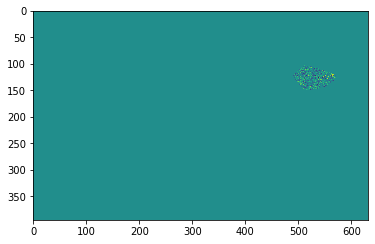

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_495_982_982.png
check t shape
(500, 345)


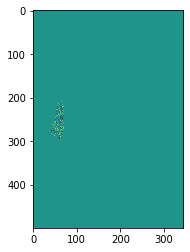

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_7542_361_361.png
check t shape
(500, 375)


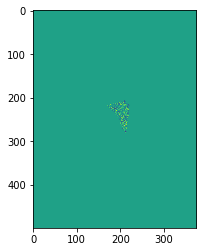

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_8518_215_215.png
check t shape
(500, 375)


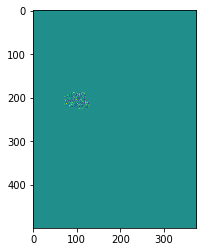

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_62736_513_513.png
check t shape
(500, 399)


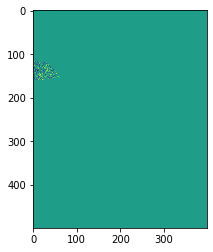

check the max index
568
568
./imagenet_fgsm/imagenet/fgsm/fgsm_n03404251_5627_568_568.png
check t shape
(391, 500)


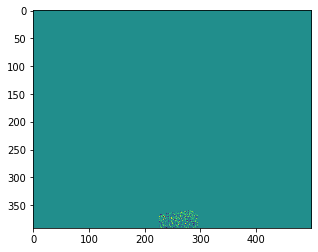

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_603_804_804.png
check t shape
(500, 333)


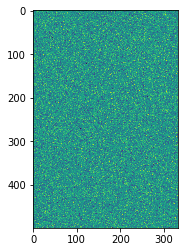

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_10609_886_886.png
check t shape
(400, 500)


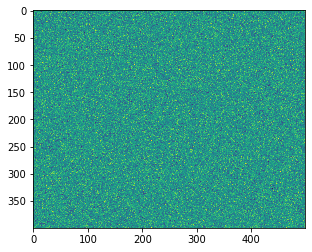

check the max index
215
215
./imagenet_fgsm/imagenet/fgsm/fgsm_n02101388_6690_215_215.png
check t shape
(214, 290)


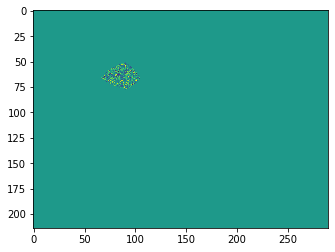

check the max index
804
804
./imagenet_fgsm/imagenet/fgsm/fgsm_n04254120_1536_804_804.png
check t shape
(500, 375)


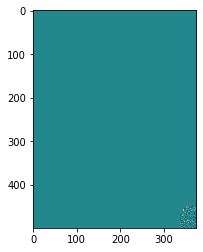

check the max index
218
218
./imagenet_fgsm/imagenet/fgsm/fgsm_n02102177_2695_218_218.png
check t shape
(333, 500)


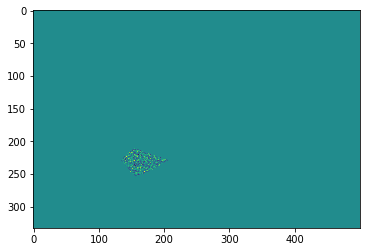

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_3908_886_886.png
check t shape
(500, 375)


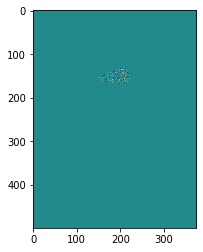

check the max index
316
316
./imagenet_fgsm/imagenet/fgsm/fgsm_n02256656_5578_316_316.png
check t shape
(375, 500)


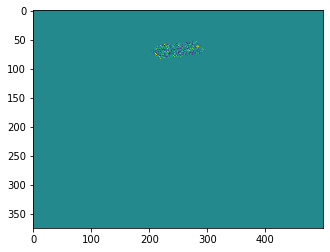

check the max index
935
935
./imagenet_fgsm/imagenet/fgsm/fgsm_n07711569_753_935_935.png
check t shape
(375, 500)


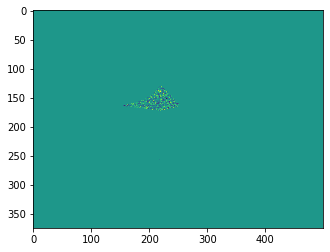

check the max index
638
638
./imagenet_fgsm/imagenet/fgsm/fgsm_n03710637_8182_638_638.png
check t shape
(512, 510)


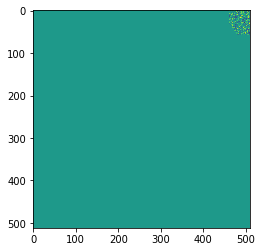

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_14502_31_31.png
check t shape
(375, 500)


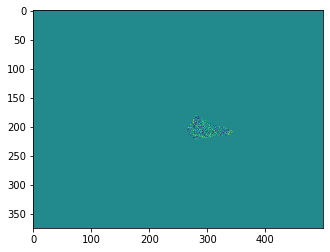

check the max index
873
873
./imagenet_fgsm/imagenet/fgsm/fgsm_n04486054_5665_873_873.png
check t shape
(375, 500)


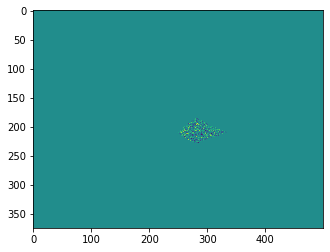

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_3831_988_988.png
check t shape
(375, 500)


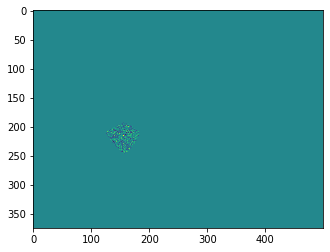

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_8687_673_673.png
check t shape
(375, 500)


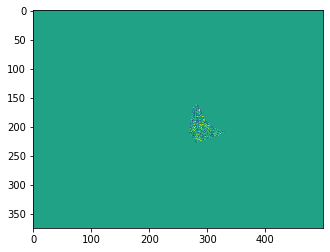

check the max index
885
885
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525038_13481_885_885.png
check t shape
(448, 432)


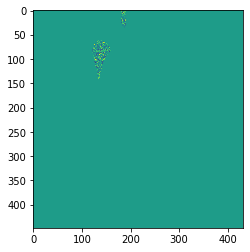

check the max index
432
432
./imagenet_fgsm/imagenet/fgsm/fgsm_n02804610_12887_432_432.png
check t shape
(372, 500)


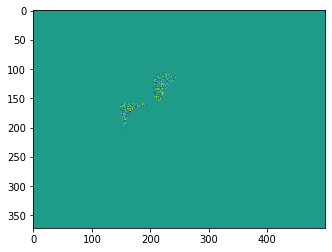

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_15326_31_31.png
check t shape
(334, 500)


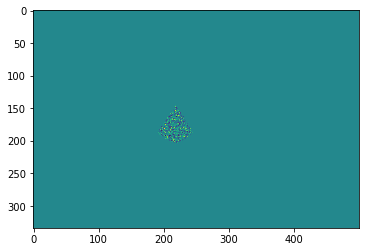

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_3094_886_886.png
check t shape
(500, 375)


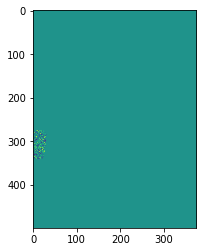

check the max index
470
470
./imagenet_fgsm/imagenet/fgsm/fgsm_n02948072_4145_470_470.png
check t shape
(452, 500)


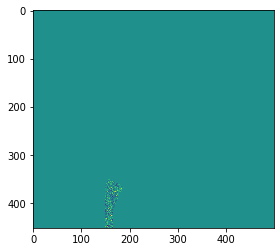

check the max index
913
913
./imagenet_fgsm/imagenet/fgsm/fgsm_n04606251_3672_913_913.png
check t shape
(332, 500)


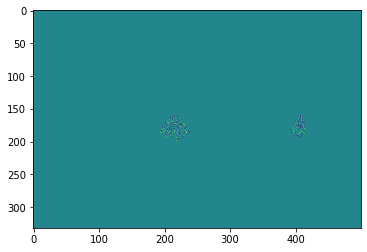

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_23603_310_310.png
check t shape
(500, 409)


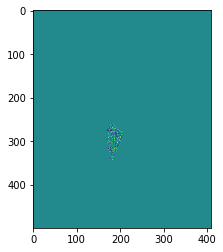

check the max index
550
550
./imagenet_fgsm/imagenet/fgsm/fgsm_n03297495_9563_550_550.png
check t shape
(111, 111)


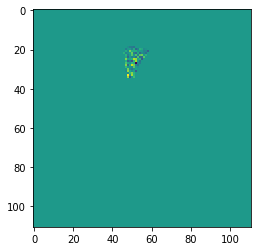

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_1037_31_31.png
check t shape
(500, 333)


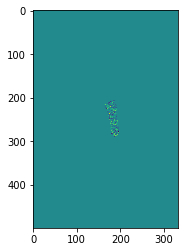

check the max index
92
92
./imagenet_fgsm/imagenet/fgsm/fgsm_n01828970_2348_92_92.png
check t shape
(500, 480)


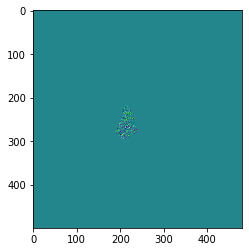

check the max index
404
404
./imagenet_fgsm/imagenet/fgsm/fgsm_n02690373_8872_404_404.png
check t shape
(333, 500)


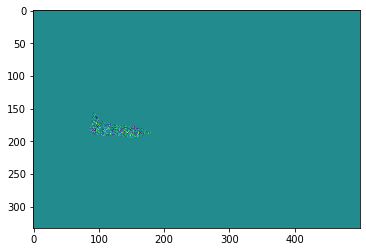

check the max index
696
696
./imagenet_fgsm/imagenet/fgsm/fgsm_n03876231_3692_696_696.png
check t shape
(350, 233)


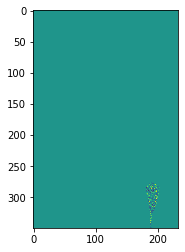

check the max index
998
998
./imagenet_fgsm/imagenet/fgsm/fgsm_n13133613_22014_998_998.png
check t shape
(375, 500)


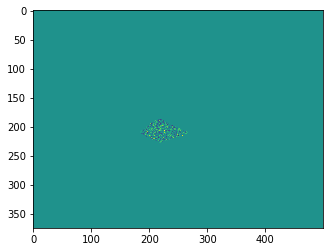

check the max index
982
982
./imagenet_fgsm/imagenet/fgsm/fgsm_n10148035_16703_982_982.png
check t shape
(500, 335)


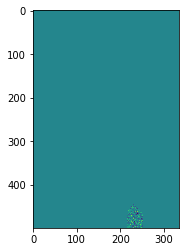

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_1454_886_886.png
check t shape
(375, 500)


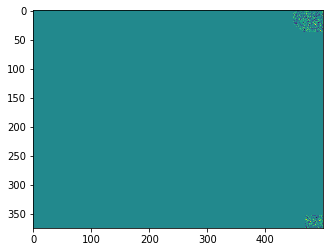

check the max index
429
429
./imagenet_fgsm/imagenet/fgsm/fgsm_n02799071_27940_429_429.png
check t shape
(336, 500)


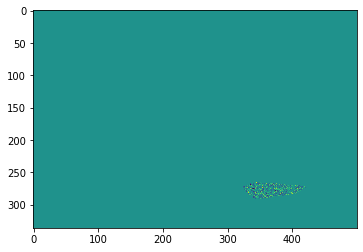

check the max index
31
31
./imagenet_fgsm/imagenet/fgsm/fgsm_n01644373_15722_31_31.png
check t shape
(333, 500)


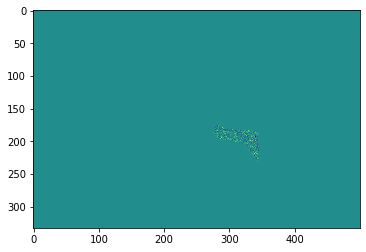

check the max index
673
673
./imagenet_fgsm/imagenet/fgsm/fgsm_n03793489_10994_673_673.png
check t shape
(474, 632)


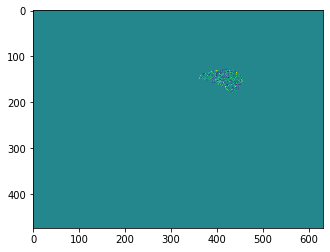

check the max index
361
361
./imagenet_fgsm/imagenet/fgsm/fgsm_n02445715_17142_361_361.png
check t shape
(375, 500)


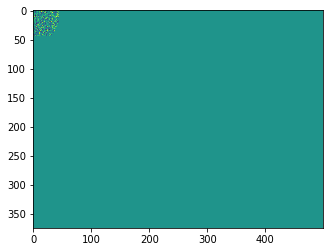

check the max index
513
513
./imagenet_fgsm/imagenet/fgsm/fgsm_n03110669_5922_513_513.png
check t shape
(856, 1144)


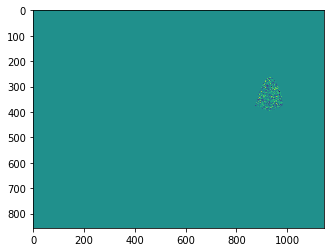

check the max index
310
310
./imagenet_fgsm/imagenet/fgsm/fgsm_n02219486_28648_310_310.png
check t shape
(341, 510)


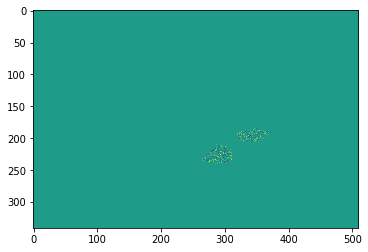

check the max index
352
352
./imagenet_fgsm/imagenet/fgsm/fgsm_n02422699_861_352_352.png
check t shape
(426, 640)


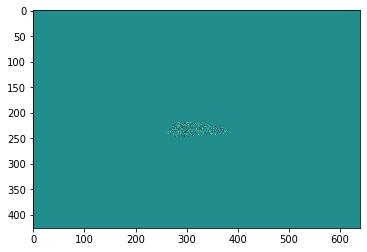

check the max index
363
363
./imagenet_fgsm/imagenet/fgsm/fgsm_n02454379_548_363_363.png
check t shape
(335, 500)


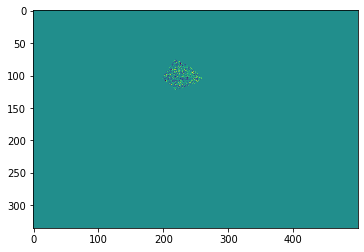

check the max index
979
979
./imagenet_fgsm/imagenet/fgsm/fgsm_n09468604_41189_979_979.png
check t shape
(375, 500)


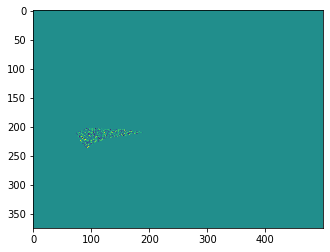

check the max index
988
988
./imagenet_fgsm/imagenet/fgsm/fgsm_n12267677_29882_988_988.png
check t shape
(333, 500)


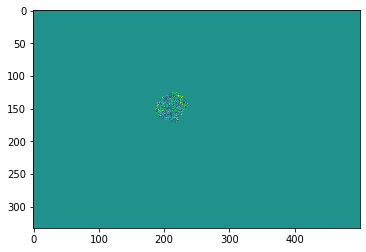

check the max index
886
886
./imagenet_fgsm/imagenet/fgsm/fgsm_n04525305_9627_886_886.png
check t shape
(400, 500)


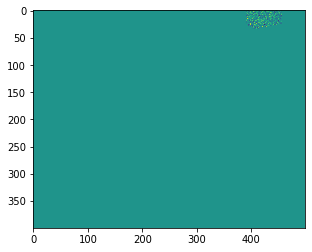

In [11]:
#plt.imshow(data["img"])
for data in testloader:
    #net1 = net1.to(DEVICE)
    #net2 = net2.to(DEVICE)
    img1 = data['img'].to(DEVICE)
    #print("check the image")
    #print(img1.shape)
    path = data['path']

    #img1 = img1.float()
    img1 = img1.view(-1,img1.shape[-3],img1.shape[-2],img1.shape[-1])
    #print(img1.shape)
    img1 = img1.float()
    #print(img1.shape)
    label = data['label'].to(DEVICE)
    mislabel = data['mislabel'].to(DEVICE)
   
    resnet = ResNet()
    resnet = resnet.to(DEVICE)
    resnet.eval()
    #print("check the image sizes")
    #print(img1.shape)
    img1 = Variable(img1.cuda(), requires_grad=True)
    pred, acts = resnet(img1)
    max_index = pred.argmax(dim=1) 
    print("check the max index")
    print(max_index.item())
    print(label.item())
    ##############################################################for max_index
    pred[:,(max_index.item()-1)].backward()
    gradients = resnet.get_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = resnet.get_activations(img1).detach()
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = F.relu(torch.sum(activations, dim=1)).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap.squeeze())
    heatmap = heatmap.numpy()
    #print(np.unique(heatmap))
    print(path[0])
    img = io.imread(path[0])
    if(img.shape.__len__() == 2):
                img = np.repeat(img[:, :, np.newaxis], 3, axis=2) 
    #print("check original shape")
    #print(img.shape)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    p = np.percentile(heatmap, 99)
    heatmap[heatmap>=p]=1
    heatmap[heatmap<p]=0
    heatmap = heatmap.astype(int)
    x = copy.deepcopy(heatmap)
    t = np.random.normal(0,0.025,(img.shape[0],img.shape[1]))
    print("check t shape")
    print(t.shape)
    k=1
    #plt.imshow((img))
    #plt.show()
    var = t*x*k
    plt.imshow(var)
    plt.show()
    #print("check var")
    #print(np.unique(var))
    #print("check unique img")
    #print(np.unique(img))
    #b=b*255
    b = np.repeat(var[:, :, np.newaxis], 3, axis=2)
    b = b*255
    #k =1
    #r_temp = img[:,:,0]*(x*(-1))
    #img[:,:,0] = img[:,:,0] +r_temp +(t*x*img[:,:,0]*k)
    #img[:,:,0] = img[:,:,0]  +(t*x*k)
    #g_temp = img[:,:,1]*(x*(-1))
    #img[:,:,1] = img[:,:,1] +g_temp +(t*x*img[:,:,1]*k)
    #img[:,:,1] = img[:,:,1]  +(t*x*k)
    #b_temp = img[:,:,2]*(x*(-1))
    #img[:,:,2] = img[:,:,2] +b_temp +(t*x*img[:,:,2]*k)
    #img[:,:,2] = img[:,:,2]  +(t*x*k)
    img = img+b
    #heatmap = np.uint8(255 * heatmap)
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #superimposed_img = heatmap * 0.4 + img
    name = path[0].split('/')[-1].split('.')[-2]
    #print("check the name")
    #print(name)
    
    cv2.imwrite('./test/'+str(name)+'.png', img)
    #plt.imshow(img)
    #break
    #########################################################################for label
   
    
    
    

for data in testloader:
    #net1 = net1.to(DEVICE)
    #net2 = net2.to(DEVICE)
    img1 = data['img'].to(DEVICE)
    print("check the image")
    print(img1.shape)
    path = data['path']

    #img1 = img1.float()
    img1 = img1.view(-1,img1.shape[-3],img1.shape[-2],img1.shape[-1])
    print(img1.shape)
    img1 = img1.float()
    #print(img1.shape)
    label = data['label'].to(DEVICE)
    print("CHECK THE PATH")
    print(path[0])   
    resnet = ResNet()
    resnet = resnet.to(DEVICE)
    resnet.eval()
    print("check the image sizes")
    print(img1.shape)
    img1 = Variable(img1.cuda(), requires_grad=True)
    pred, acts = resnet(img1)
    max_index = pred.argmax(dim=1) 
    print("check the max index")
    print(max_index)
    pred[:,(max_index.item())].backward()
    gradients = resnet.get_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = resnet.get_activations(img1).detach()
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = F.relu(torch.sum(activations, dim=1)).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap.squeeze())
    heatmap = heatmap.numpy()
    #print(np.unique(heatmap))
    
    print(np.unique(heatmap))
    
    print(label.item())
    img = io.imread(path[0])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    p = np.percentile(heatmap, 70)
    heatmap[heatmap>=p]=1
    heatmap[heatmap<p]=0
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    name = path[0].split('/')[-1].split('.')[-2]
    cv2.imwrite('./originallabel_camfiles/'+str(name)+'_'+str(max_index.item()+1)+'.jpg', superimposed_img)
    

#plt.imshow(data["img"])
for data in testloader:
    #net1 = net1.to(DEVICE)
    #net2 = net2.to(DEVICE)
    img1 = data['img'].to(DEVICE)
    print("check the image")
    print(img1.shape)
    path = data['path']

    #img1 = img1.float()
    img1 = img1.view(-1,img1.shape[-3],img1.shape[-2],img1.shape[-1])
    print(img1.shape)
    img1 = img1.float()
    #print(img1.shape)
    label = data['label'].to(DEVICE)
    mislabel = data['mislabel'].to(DEVICE)
   
    resnet = ResNet()
    resnet = resnet.to(DEVICE)
    resnet.eval()
    print("check the image sizes")
    print(img1.shape)
    img1 = Variable(img1.cuda(), requires_grad=True)
    pred, acts = resnet(img1)
    max_index = pred.argmax(dim=1) 
    print("check the max index")
    print(max_index)
    ##############################################################for actual label
    pred[:,(label.item())].backward()
    gradients = resnet.get_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = resnet.get_activations(img1).detach()
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = F.relu(torch.sum(activations, dim=1)).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap.squeeze())
    heatmap = heatmap.numpy()
    #print(np.unique(heatmap))
    p = np.percentile(heatmap, 97)
    heatmap[heatmap>=p]=1
    heatmap[heatmap<p]=0
    print(np.unique(heatmap))
    print("CHECK THE PATH")
    print(path[0])
    print(label.item())
    img = io.imread(path[0])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    name = path[0].split('/')[-1].split('.')[-2]
    print("check the name")
    print(name)
    
    cv2.imwrite('./originallabel_camfiles/'+str(name)+'_'+str(label.item())+'.jpg', superimposed_img)
    #########################################################################for label
   

In [ ]:
|